# Cleaned up version

Here we load all data files, but keep them on different days in order to not blow up the bouyancy gradient. CT and SA are derived according to TEOS-10, we then interpolate them to a regular grid. After that the bouyancy and bouyancy gradient are computed. The alongfront windstress is taken as the difference in the angle of the wind direction and the depth averaged current direction. Alpha is computed using GSW. Then Q_EBF is computed

In [201]:
# --- Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
from pathlib import Path
from pyproj import Geod
import gsw
import xarray as xr
import datetime as dt
import pytz
from windrose import WindroseAxes

In [202]:

# --- Constants ---
g = 9.81
Cp = 4000  # J/kg/K
rho_air = 1.2  # kg/m^3
Cd = 1.5e-3  # drag coefficient
f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
geod = Geod(ellps="WGS84")
dx = 200  # horizontal interpolation step in meters

# --- Load FerryBox data ---
def load_ferrybox(filepath):
    filepath = Path(filepath)
    with filepath.open('r', encoding='latin1') as f:
        for i, line in enumerate(f):
            if line.strip().startswith("Date") and "Time" in line:
                skiprows = i
                break
    df = pd.read_csv(filepath, sep=r'\s+', skiprows=skiprows, encoding='latin1')
    df = df.iloc[1:]
    df['datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])
    return df

ferry_files = [
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\224_2025-05-06_07.35.09__to_Skagen_741601.txt", #Dag 1 ,
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\225_2025-05-07_07.11.44_Skagen_to_Skagen_741601.txt", # Hela dag 2
    r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\2025-05-08_07.24.29_Skagen_to__741601.txt" #Dag 3
]
df_ferry = pd.concat([load_ferrybox(f) for f in ferry_files], ignore_index=True)


In [203]:
# --- Preprocess FerryBox ---
df_ferry['Temp_in_SBE38'] = df_ferry['Temp_in_SBE38'].mask(df_ferry['Temp_in_SBE38'] > 100)
df_ferry = df_ferry.set_index('datetime')
df_ferry['Temp_in_SBE38'] = df_ferry['Temp_in_SBE38'].interpolate('time')
df_ferry = df_ferry.reset_index()

SP = df_ferry['Salinity_SBE45'].to_numpy()
T = df_ferry['Temp_in_SBE38'].to_numpy()
p = df_ferry['pressure'].to_numpy() / 100.0
lon = df_ferry['Longitude'].to_numpy()
lat = df_ferry['Latitude'].to_numpy()

SA = gsw.SA_from_SP(SP, p, lon, lat)
CT = gsw.CT_from_t(SA, T, p)
sigma0 = gsw.sigma0(SA, CT)
depth = -gsw.z_from_p(p, lat)

df_ferry['SA'] = SA
df_ferry['CT'] = CT
df_ferry['sigma0'] = sigma0
df_ferry['depth'] = depth

# --- Filter around target depth ---
target_depth = 2.0
depth_window = 0.5
mask = np.abs(df_ferry['depth'] - target_depth) <= depth_window
df_filtered = df_ferry[mask].copy()

# --- Compute buoyancy and gradient per day ---
buoyancy_all = []
df_buoy_base = []

day_groups = df_filtered.groupby(df_filtered['datetime'].dt.date)

for date, group in day_groups:
    group = group.sort_values('datetime').copy()
    lon = group['Longitude'].to_numpy()
    lat = group['Latitude'].to_numpy()
    _, _, step = geod.inv(lon[:-1], lat[:-1], lon[1:], lat[1:])
    dist = np.concatenate(([0], np.cumsum(step)))
    group['dist_m'] = dist

    d_reg = np.arange(0, dist[-1], dx)

    SA_i = interp1d(dist, group['SA'], bounds_error=False, fill_value=np.nan)(d_reg)
    CT_i = interp1d(dist, group['CT'], bounds_error=False, fill_value=np.nan)(d_reg)

    #rho = gsw.rho(SA_i, CT_i, p=0)
    #rho0 = np.nanmean(rho)
    rho = gsw.sigma0(SA_i, CT_i) + 1000
    rho0 = 1025
    
    b = g * (1 - rho / rho0)
    b_smooth = gaussian_filter1d(b, sigma=2)
    dbdx = np.gradient(b_smooth, dx)

    df_day = pd.DataFrame({
        'date': date,
        'distance_m': d_reg,
        'SA': SA_i,
        'CT': CT_i,
        'b': b_smooth,
        'dbdx': dbdx
    })
    buoyancy_all.append(df_day)
    df_buoy_base.append(group)

buoy_data = pd.concat(buoyancy_all, ignore_index=True)
df_buoy_base = pd.concat(df_buoy_base, ignore_index=True)

In [204]:
# --- Load and process wind ---
df_wind = pd.read_csv(r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\sk_weather.csv")
df_wind['datetime'] = pd.to_datetime(df_wind['ts'])
wind_speed = df_wind['windspeed'].to_numpy()
wind_dir_to_rad = np.deg2rad((df_wind['winddir'] + 180) % 360)

# --- Load ADCP ---
def load_adcp(filepath):
    raw = pd.read_csv(filepath, sep="\t", skiprows=12, engine="python").iloc[3:-3].reset_index(drop=True)
    raw = raw.map(lambda x: str(x).replace(",", "."))
    numeric_cols = raw.columns.drop(['    "FLat"', '    "FLon"', '    "LLat"', '    "LLon"'])
    raw[numeric_cols] = raw[numeric_cols].astype(float)
    t = [dt.datetime(2000+int(y), int(m), int(d), int(HH), int(MM), int(SS)) for y,m,d,HH,MM,SS in raw[['YR','MO','DA','HH','MM','SS']].to_numpy()]
    t_utc = [pytz.timezone('Europe/Stockholm').localize(time).astimezone(pytz.utc).replace(tzinfo=None) for time in t]
    east = raw[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()
    north = raw[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].to_numpy()
    depth = np.arange(8, 8+4*10, 4)
    ds = xr.Dataset({
        "east_velocity": (['time', 'depth'], east / 1000),
        "north_velocity": (['time', 'depth'], north / 1000)
    }, coords={"time": t_utc, "depth": depth})
    return ds.where(np.abs(ds) < 500)

adcp_files = [r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\adcp_data_6_maj.txt',
              r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\adcp0507_postpro20may.txt", 
              r"C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data\adcp0508_postpro20may.txt"]
adcp_datasets = [load_adcp(f) for f in adcp_files]

In [205]:
# --- Compute Q_EBF ---
Q_EBF_all = []

depth_avg_current_by_day = {}  # Store direction and speed per day
wind_interp_by_day = {}        # Store interpolated wind direction and speed per day

for ds, (date, buoy_day) in zip(adcp_datasets, day_groups):
    u = ds['east_velocity'].mean(dim='depth')
    v = ds['north_velocity'].mean(dim='depth')
    theta_current = np.arctan2(v, u)
    speed_current = np.sqrt(u**2 + v**2)

    adcp_time = pd.to_datetime(ds['time'].values)
    wind_interp_time = df_wind['datetime'].astype(np.int64)
    adcp_time_ns = adcp_time.astype(np.int64)

    theta_wind_interp = np.interp(adcp_time_ns, wind_interp_time, wind_dir_to_rad)
    wind_speed_interp = np.interp(adcp_time_ns, wind_interp_time, wind_speed)

    # Store for later plotting
    depth_avg_current_by_day[date] = {
        'dir_deg': (np.rad2deg(theta_current) + 360) % 360,
        'speed': speed_current.values
    }
    wind_interp_by_day[date] = {
        'dir_deg': (np.rad2deg(theta_wind_interp) + 360) % 360,
        'speed': wind_speed_interp
    }

    tau = Cd * rho_air * wind_speed_interp**2
    delta_theta = theta_wind_interp - theta_current.values
    tau_along = tau * np.cos(delta_theta)

    dist_adcp = np.interp(adcp_time_ns, df_buoy_base['datetime'].astype(np.int64), df_buoy_base['dist_m'])
    buoy_day_df = buoy_data[buoy_data['date'] == date]
    tau_reg = np.interp(buoy_day_df['distance_m'], dist_adcp, tau_along)

    alpha = gsw.alpha(buoy_day_df['SA'].to_numpy(), buoy_day_df['CT'].to_numpy(), 0)
    Q_EBF = -(buoy_day_df['dbdx'].to_numpy() * tau_reg) * (Cp / (alpha * g * f))

    df_q = pd.DataFrame({
        'date': date,
        'distance_m': buoy_day_df['distance_m'],
        'Q_EBF': Q_EBF
    })
    Q_EBF_all.append(df_q)


Q_EBF_combined = pd.concat(Q_EBF_all, ignore_index=True)


# Trim the edges to exclude Gothenburg inlet/outlet

In [206]:
# --- Trim first 20 km of Day 1 and last 20 km of Day 3 ---
def trim_day_data(df, day, min_dist=None, max_dist=None):
    mask = df['date'] == day
    day_data = df[mask]
    if min_dist is not None:
        mask &= df['distance_m'] >= min_dist
    if max_dist is not None:
        mask &= df['distance_m'] <= max_dist
    return df[mask]

# Get dates
dates = buoy_data['date'].unique()
day1, day2, day3 = dates[0], dates[1], dates[2]

# Get max distance for day 3
day3_max_dist = buoy_data[buoy_data['date'] == day3]['distance_m'].max()

# Apply trims
buoy_data = pd.concat([
    trim_day_data(buoy_data, day1, min_dist= 26_000),
    buoy_data[buoy_data['date'] == day2],
    trim_day_data(buoy_data, day3, max_dist=day3_max_dist - 18_000)
], ignore_index=True)

# Trim Q_EBF_all accordingly
Q_EBF_all_trimmed = []
for df_q in Q_EBF_all:
    date = df_q['date'].iloc[0]
    if date == day1:
        df_q = df_q[df_q['distance_m'] >= 26_000]
    elif date == day3:
        max_dist = df_q['distance_m'].max()
        df_q = df_q[df_q['distance_m'] <= max_dist - 18_000]
    Q_EBF_all_trimmed.append(df_q)
Q_EBF_all = Q_EBF_all_trimmed

# Also trim df_buoy_base
df_buoy_base_trimmed = []
for date in [day1, day2, day3]:
    base_day = df_buoy_base[pd.to_datetime(df_buoy_base['datetime']).dt.date == date]
    if date == day1:
        base_day = base_day[base_day['dist_m'] >= 26_000]
    elif date == day3:
        max_dist = base_day['dist_m'].max()
        base_day = base_day[base_day['dist_m'] <= max_dist - 18_000]
    df_buoy_base_trimmed.append(base_day)
df_buoy_base = pd.concat(df_buoy_base_trimmed, ignore_index=True)


tau_along_reg values for Day 2 (plotted):
Mean: -0.01714119244827359
Max:  0.03994092140617309
Min:  -0.10776313761807448

First 20 values:
[        nan         nan         nan         nan         nan         nan
 -0.09775894 -0.0994263  -0.10109367 -0.10276104 -0.1044284  -0.10609577
 -0.10776314 -0.10565713 -0.10347452 -0.10129192 -0.09910932 -0.09692671
 -0.09474411 -0.0925615 ]

Last 20 values:
[0.03994092 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092
 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092
 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092
 0.03994092 0.03994092]
(333,)


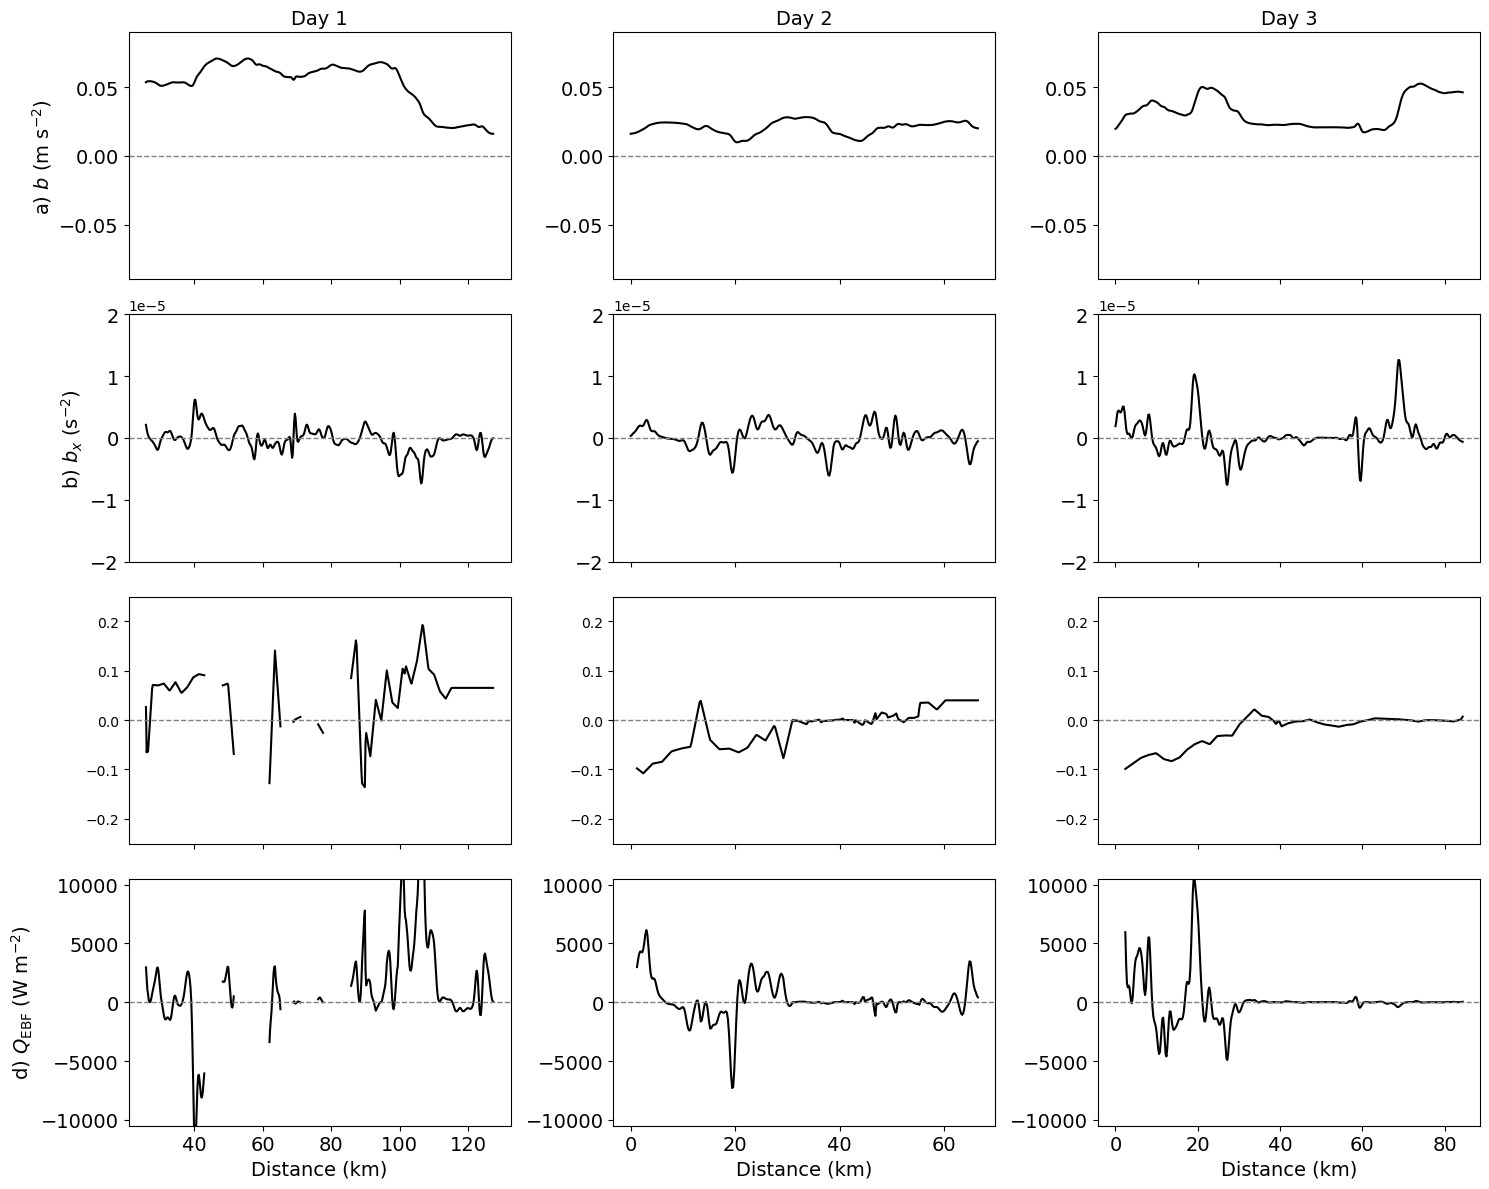

In [211]:
# Plot
b_range = [-9e-2, 9e-2]
dbdx_range = [-2e-5, 2e-5]
tau_range = [-0.25, 0.25]
q_range = [-10500, 10500]

n_days = len(Q_EBF_all)
fig, axs = plt.subplots(4, n_days, figsize=(5 * n_days, 12), sharex='col')

# # Define x-limits per day/column (in km)
# xlims_by_column = [
#     (-2, 135),   # Day 1
#     (-2, 135),    # Day 2
#     (-2, 135)    # Day 3
# ]


# Add direction labels for each day segment in df_buoy_base


for i, (df_q, ds) in enumerate(zip(Q_EBF_all, adcp_datasets)):
    day = df_q['date'].iloc[0]
    buoy_day = buoy_data[buoy_data['date'] == day]
    u = ds['east_velocity'].mean(dim='depth')
    v = ds['north_velocity'].mean(dim='depth')
    theta_current = np.arctan2(v, u)

    adcp_time = pd.to_datetime(ds['time'].values)
    adcp_time_ns = adcp_time.astype(np.int64)
    wind_interp_time = df_wind['datetime'].astype(np.int64)
    wind_speed_interp = np.interp(adcp_time_ns, wind_interp_time, wind_speed)
    theta_wind_interp = np.interp(adcp_time_ns, wind_interp_time, wind_dir_to_rad)
    tau = Cd * rho_air * wind_speed_interp**2
    delta_theta = theta_wind_interp - theta_current.values
    tau_along = tau * np.cos(delta_theta)
    dist_adcp = np.interp(adcp_time_ns, df_buoy_base['datetime'].astype(np.int64), df_buoy_base['dist_m'])
    tau_along_reg = np.interp(buoy_day['distance_m'], dist_adcp, tau_along)

    distance_km = buoy_day['distance_m'] / 1000
    q_distance_km = df_q['distance_m'] / 1000
    #xlim = xlims_by_column[i]

    # Buoyancy
    axs[0, i].plot(distance_km, buoy_day['b'], color='black')
    axs[0, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[0, i].set_ylim(b_range)
    #axs[0, i].set_xlim(*xlim)
    axs[0, i].set_title(f'Day {i+1}', fontsize=14)
    if i == 0:
        axs[0, i].set_ylabel(r'a) $b$ (m s$^{-2}$)', fontsize=14)
    axs[0, i].tick_params(axis='both', labelsize=14)

    # Gradient 
    axs[1, i].plot(distance_km, buoy_day['dbdx'], color='black')
    axs[1, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[1, i].set_ylim(dbdx_range)
    #axs[1, i].set_xlim(*xlim)
    if i == 0:
        axs[1, i].set_ylabel(r'b) $b_x$ (s$^{-2}$)', fontsize=14)
    axs[1, i].tick_params(axis='both', labelsize=14)

    # Alongfront windstress
    # axs[2, i].plot(distance_km, tau_along_reg, color='black')
    # axs[2, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    # axs[2, i].set_ylim(tau_range)
    # #axs[2, i].set_xlim(*xlim)
    # if i == 0:
    #     axs[2, i].set_ylabel(r'c) $\tau^y$ (N m$^{-2}$)', fontsize=14)
    # axs[2, i].tick_params(axis='both', labelsize=14)

        # Plot tau_along_reg
    axs[2, i].plot(distance_km, tau_along_reg, color='black')
    axs[2, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[2, i].set_ylim(tau_range)

    if i == 1:
        print("tau_along_reg values for Day 2 (plotted):")
        print("Mean:", np.nanmean(tau_along_reg))
        print("Max: ", np.nanmax(tau_along_reg))
        print("Min: ", np.nanmin(tau_along_reg))


            # Print first and last 20 values
        print("\nFirst 20 values:")
        print(tau_along_reg[:20])

        print("\nLast 20 values:")
        print(tau_along_reg[-20:])
        print(tau_along_reg.shape)



    

    # Q_EBF
    axs[3, i].plot(q_distance_km, df_q['Q_EBF'], color='black')
    axs[3, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[3, i].set_ylim(q_range)
    #axs[3, i].set_xlim(*xlim)
    if i == 0:
        axs[3, i].set_ylabel(r'd) $Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=14)
    axs[3, i].set_xlabel('Distance (km)', fontsize=14)
    axs[3, i].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()


C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\136028532.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['southward' 'southward' 'southward' 'southward' 'southward' 'northward'
 'northward' 'northward' 'southward' 'northward' 'northward' 'southward'
 'northward' 'southward' 'southward' 'northward' 'northward' 'southward'
 'southward' 'southward' 'southward' 'northward' 'northward' 'southward'
 'southward' 'northward' 'northward' 'northward' 'southward' 'southward'
 'northward' 'southward' 'southward' 'northward' 'northward' 'southward'
 'southward' 'southward' 'southward' 'southward' 'southward' 'southward'
 'southward' 'southward' 'southward' 'southward' 'southward' 'southward'
 'southward' 'southward' 'southward' 'southward' 'southward' 'southward'
 'southward' 'southward' 'southward' 'southward' 'southward' 'southward'
 'southward' 'southward' 'southward' 'southward' 'southward' 'southward'
 'southward'

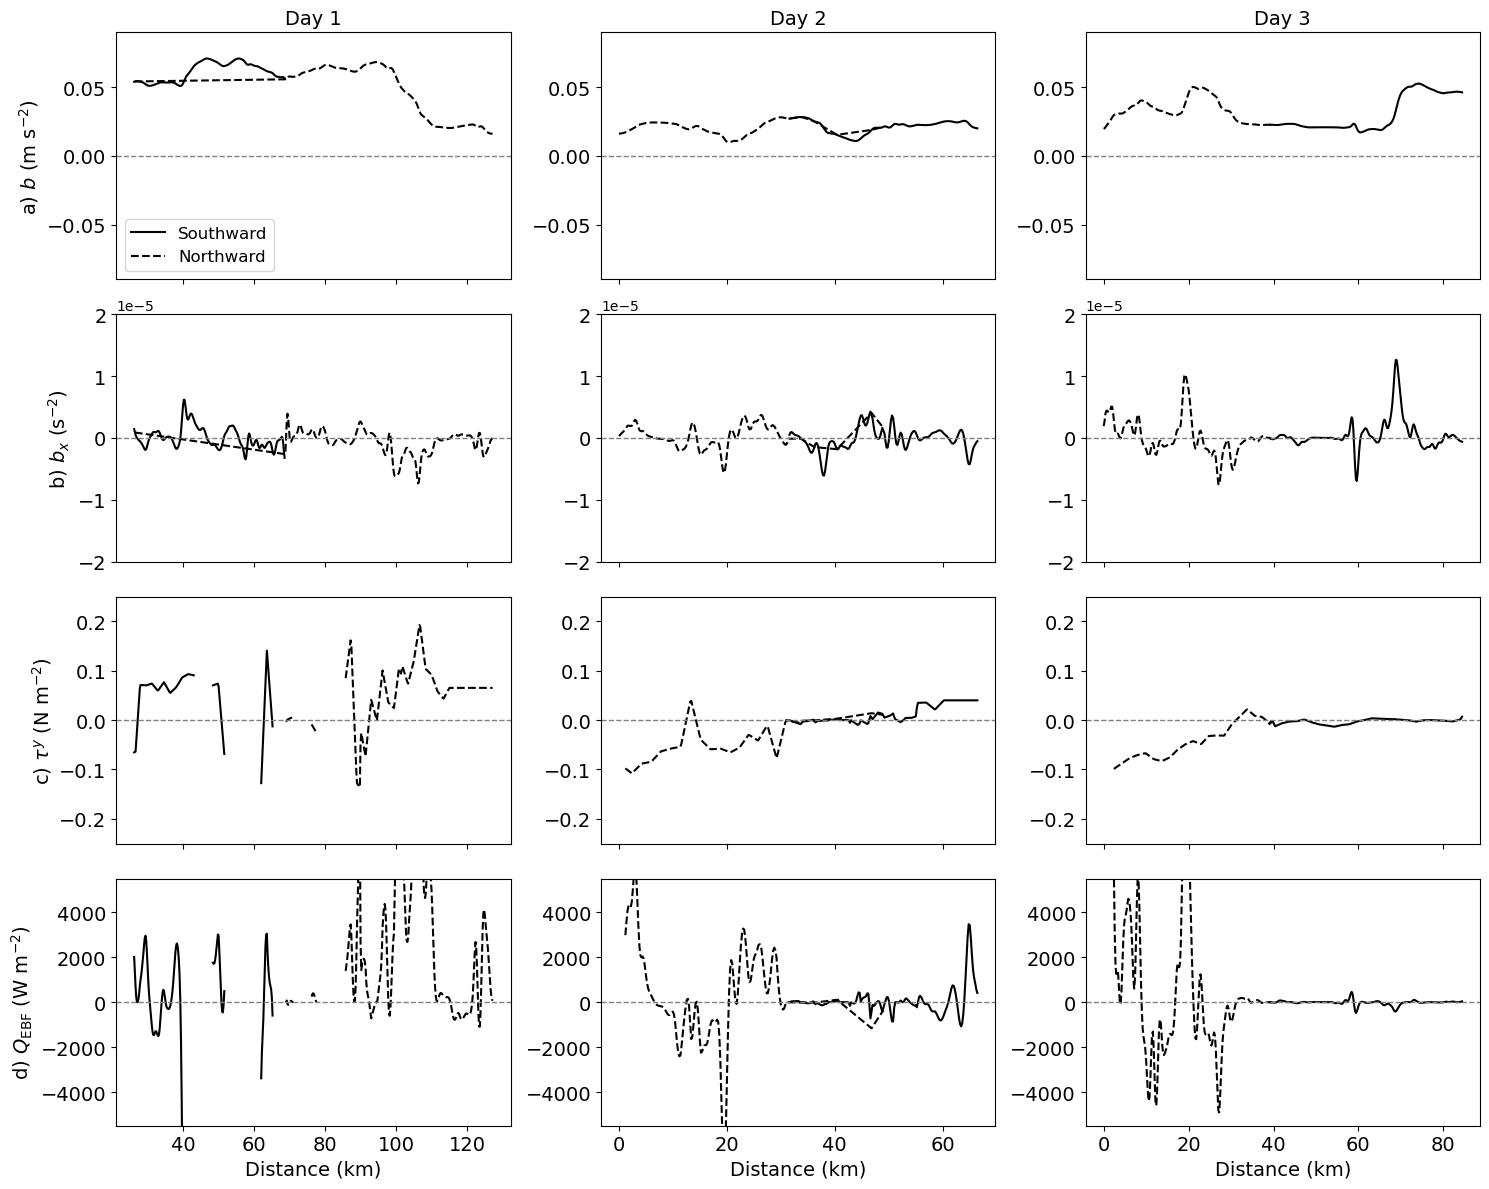

In [216]:
# Trying to plot northward and southward transect as solid and dashed line but its not quite working, 
# something with the interpolation gone wrong

# Plot segmented by direction ---
b_range = [-9e-2, 9e-2]
dbdx_range = [-2e-5, 2e-5]
tau_range = [-0.25, 0.25]
q_range = [-5500, 5500]

# Assign direction labels in df_buoy_base
df_buoy_base['direction'] = np.nan
for date in df_buoy_base['datetime'].dt.date.unique():
    df_day = df_buoy_base[df_buoy_base['datetime'].dt.date == date].copy()
    df_day = df_day.sort_values('datetime')
    lat_diff = np.gradient(df_day['Latitude'].to_numpy())
    direction = np.where(lat_diff > 0, 'northward', 'southward')
    df_buoy_base.loc[df_day.index, 'direction'] = direction

# Plot
n_days = len(Q_EBF_all)
fig, axs = plt.subplots(4, n_days, figsize=(5 * n_days, 12), sharex='col')

for i, (df_q, ds) in enumerate(zip(Q_EBF_all, adcp_datasets)):
    day = df_q['date'].iloc[0]
    buoy_day = buoy_data[buoy_data['date'] == day].reset_index(drop=True)
    df_q = df_q.reset_index(drop=True)

    # Recalculate interpolated tau_along_reg for this day
    u = ds['east_velocity'].mean(dim='depth')
    v = ds['north_velocity'].mean(dim='depth')
    theta_current = np.arctan2(v, u)

    adcp_time = pd.to_datetime(ds['time'].values)
    adcp_time_ns = adcp_time.astype(np.int64)
    wind_interp_time = df_wind['datetime'].astype(np.int64)
    wind_speed_interp = np.interp(adcp_time_ns, wind_interp_time, wind_speed)
    theta_wind_interp = np.interp(adcp_time_ns, wind_interp_time, wind_dir_to_rad)
    tau = Cd * rho_air * wind_speed_interp**2
    delta_theta = theta_wind_interp - theta_current.values
    tau_along = tau * np.cos(delta_theta)
    dist_adcp = np.interp(adcp_time_ns, df_buoy_base['datetime'].astype(np.int64), df_buoy_base['dist_m'])
    tau_along_reg = np.interp(buoy_day['distance_m'], dist_adcp, tau_along)

    # Interpolate direction onto buoy_day distances safely
    base_day = df_buoy_base[df_buoy_base['datetime'].dt.date == day].copy()
    base_day = base_day.sort_values('dist_m')
    direction_numeric = np.where(base_day['direction'] == 'northward', 1, 0)

    # Create arrays for direction labels
    interpolated_dir = np.full(buoy_day.shape[0], np.nan)
    valid_range = (buoy_day['distance_m'] >= base_day['dist_m'].min()) & \
                  (buoy_day['distance_m'] <= base_day['dist_m'].max())

    interpolated_dir[valid_range] = np.interp(
        buoy_day['distance_m'][valid_range],
        base_day['dist_m'],
        direction_numeric
    )
    direction_labels = np.full(buoy_day.shape[0], None, dtype=object)
    direction_labels[valid_range] = np.where(
        np.round(interpolated_dir[valid_range]) == 1, 'northward', 'southward'
    )

    # Distances for plotting
    distance_km = buoy_day['distance_m'] / 1000
    q_distance_km = df_q['distance_m'] / 1000

    for dir_label, linestyle in zip(['southward', 'northward'], ['-', '--']):
        mask = direction_labels == dir_label
        if not np.any(mask):
            continue
        axs[0, i].plot(distance_km[mask], buoy_day['b'][mask], linestyle, color='black')
        axs[1, i].plot(distance_km[mask], buoy_day['dbdx'][mask], linestyle, color='black')
        axs[2, i].plot(distance_km[mask], tau_along_reg[mask], linestyle, color='black')
        axs[3, i].plot(q_distance_km[mask], df_q['Q_EBF'][mask], linestyle, color='black')

    # Format axes
    axs[0, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[0, i].set_ylim(b_range)
    axs[0, i].set_title(f'Day {i+1}', fontsize=14)
    if i == 0:
        axs[0, i].set_ylabel(r'a) $b$ (m s$^{-2}$)', fontsize=14)
    axs[0, i].tick_params(axis='both', labelsize=14)

    axs[1, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[1, i].set_ylim(dbdx_range)
    if i == 0:
        axs[1, i].set_ylabel(r'b) $b_x$ (s$^{-2}$)', fontsize=14)
    axs[1, i].tick_params(axis='both', labelsize=14)

    axs[2, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[2, i].set_ylim(tau_range)
    if i == 0:
        axs[2, i].set_ylabel(r'c) $\tau^y$ (N m$^{-2}$)', fontsize=14)
    axs[2, i].tick_params(axis='both', labelsize=14)

    axs[3, i].axhline(0, color='gray', linestyle='--', linewidth=1)
    axs[3, i].set_ylim(q_range)
    if i == 0:
        axs[3, i].set_ylabel(r'd) $Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=14)
    axs[3, i].set_xlabel('Distance (km)', fontsize=14)
    axs[3, i].tick_params(axis='both', labelsize=14)

# Add legend to first subplot
axs[0, 0].plot([], [], '-', color='black', label='Southward')
axs[0, 0].plot([], [], '--', color='black', label='Northward')
axs[0, 0].legend(fontsize=12)

plt.tight_layout()
plt.show()


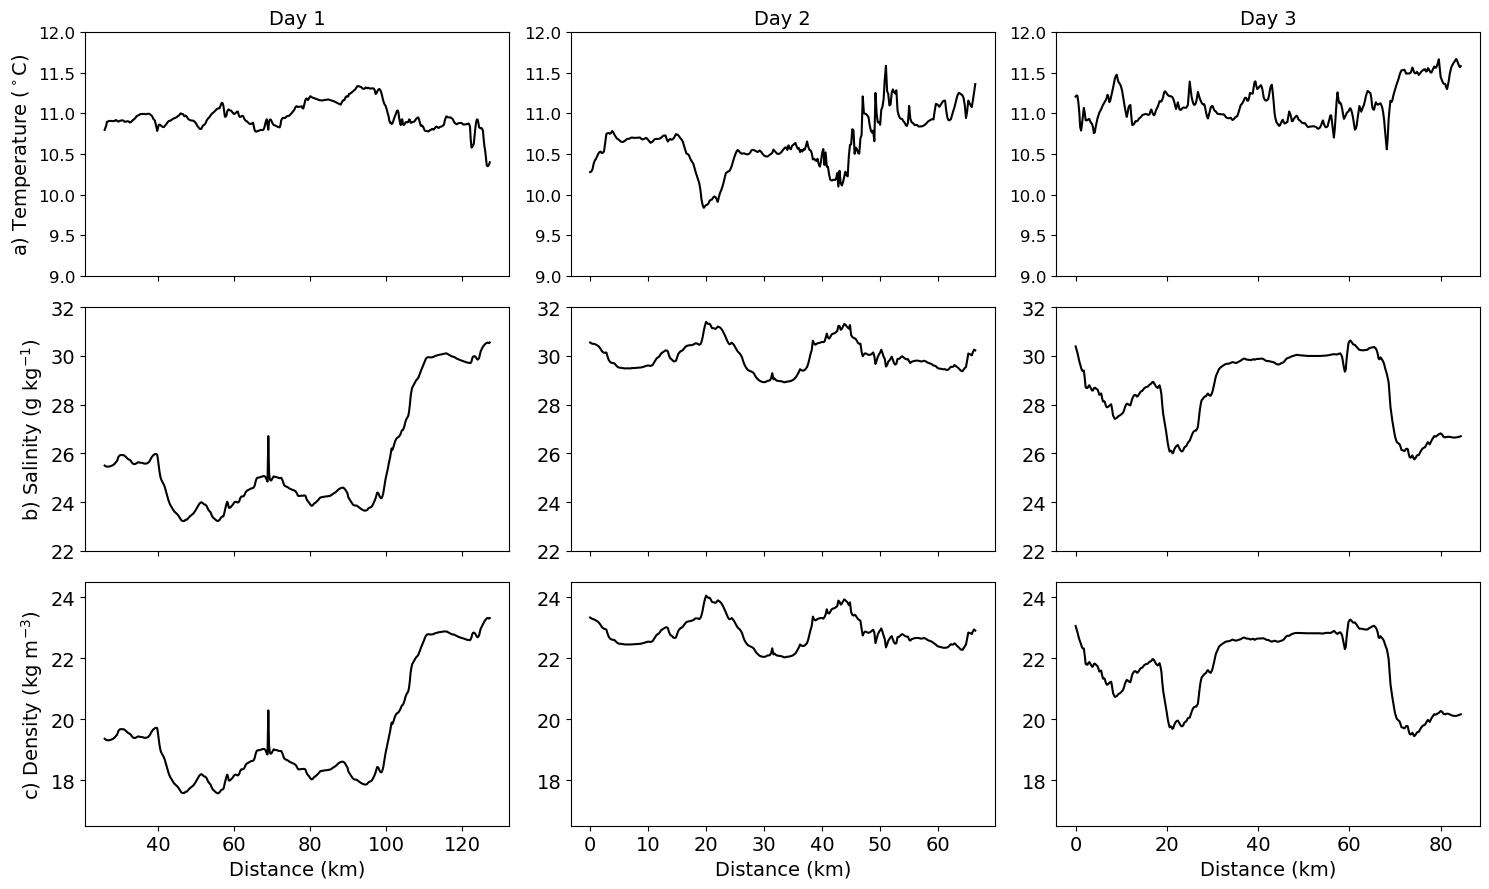

In [16]:
# --- Additional Plot: SA, CT, Density vs Distance ---
fig2, axs2 = plt.subplots(3, n_days, figsize=(5 * n_days, 9), sharex='col')

# Define manual y-axis limits per row
ylim_CT = (9, 12)         # Temperature in °C
ylim_SA = (22, 32)        # Salinity in g/kg
ylim_rho = (16.5, 24.5)   # Density in kg/m³


# Define individual x-limits per subplot
# Define x-axis limits for each day/column
# xlims_by_column = [
#     (-2, 130),   # Day 1
#     (-2, 130),  # Day 2
#     (-2, 130)   # Day 3
# ]


for i in range(n_days):
    date = Q_EBF_all[i]['date'].iloc[0]
    buoy_day = buoy_data[buoy_data['date'] == date]
    distance_km = buoy_day['distance_m'] / 1000
    CT = buoy_day['CT']
    SA = buoy_day['SA']
    rho = gsw.sigma0(SA, CT)

    # Row 0: CT
    axs2[0, i].plot(distance_km, CT, color='black')
    axs2[0, i].set_ylim(*ylim_CT)
    axs2[0, i].set_title(f'Day {i+1}', fontsize=14)

    if i == 0:
        axs2[0, i].set_ylabel(r'a) Temperature ($^\circ$C)', fontsize=14)
    axs2[0, i].tick_params(axis='both', labelsize=12)

    # Row 1: SA
    axs2[1, i].plot(distance_km, SA, color='black')
    axs2[1, i].set_ylim(*ylim_SA)
    if i == 0:
        axs2[1, i].set_ylabel(r'b) Salinity (g kg$^{-1}$)', fontsize=14)
    axs2[1, i].tick_params(axis='both', labelsize=14)

    # Row 2: Density
    axs2[2, i].plot(distance_km, rho, color='black')
    axs2[2, i].set_ylim(*ylim_rho)
    if i == 0:
        axs2[2, i].set_ylabel(r'c) Density (kg m$^{-3}$)', fontsize=14)
    axs2[2, i].set_xlabel(r'Distance (km)', fontsize=14)
    axs2[2, i].tick_params(axis='both', labelsize=14)

plt.tight_layout()
plt.show()


# Plot map of Q_EBF

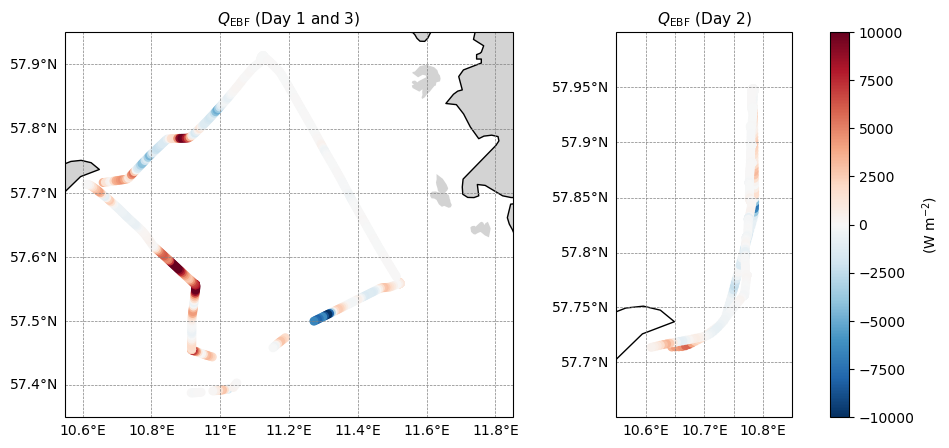

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# Define different extents for each subplot
extent_day13 = [10.55, 11.85, 57.35, 57.95]  # For Day 1 + 3 (wider path)
extent_day2 = [10.55, 10.85, 57.65, 58.0]    # For Day 2 (narrower path)

# Create figure and GridSpec with custom width ratios
fig = plt.figure(figsize=(12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2.2, 1], wspace=0.05)

# Create axes with Cartopy projection
axs = [
    fig.add_subplot(gs[0], projection=ccrs.Mercator()),
    fig.add_subplot(gs[1], projection=ccrs.Mercator())
]

# Prepare data
lon_all = df_buoy_base['Longitude'].to_numpy()
lat_all = df_buoy_base['Latitude'].to_numpy()
SA_all = df_buoy_base['SA'].to_numpy()
CT_all = df_buoy_base['CT'].to_numpy()

# Interpolate Q_EBF to positions
Q_EBF_interp = np.full_like(SA_all, np.nan)
for df_q in Q_EBF_all:
    date = df_q['date'].iloc[0]
    day_mask = pd.to_datetime(df_buoy_base['datetime']).dt.date == date
    dist_ref = df_buoy_base[day_mask]['dist_m']
    q_vals = np.interp(dist_ref, df_q['distance_m'], df_q['Q_EBF'])
    Q_EBF_interp[day_mask.values] = q_vals

# Get day masks
dates = [df_q['date'].iloc[0] for df_q in Q_EBF_all]
day1_mask = pd.to_datetime(df_buoy_base['datetime']).dt.date == dates[0]
day2_mask = pd.to_datetime(df_buoy_base['datetime']).dt.date == dates[1]
day3_mask = pd.to_datetime(df_buoy_base['datetime']).dt.date == dates[2]
mask_combined = day1_mask | day3_mask

# Plot Day 1 + 3
axs[0].set_extent(extent_day13, crs=ccrs.PlateCarree())
axs[0].add_feature(cfeature.COASTLINE)
axs[0].add_feature(cfeature.LAND, facecolor='lightgray')
#axs[0].set_facecolor('#fdf6f0')  # Light beige for Day 1 + 3
axs[0].add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)
gl0 = axs[0].gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl0.top_labels = False
gl0.right_labels = False
gl0.left_labels = True
gl0.bottom_labels = True
sc1 = axs[0].scatter(lon_all[mask_combined], lat_all[mask_combined], c=Q_EBF_interp[mask_combined],
                     cmap='RdBu_r', vmin=-10000, vmax=10000, s=30, transform=ccrs.PlateCarree())
axs[0].set_title(r'$Q_{\mathrm{EBF}}$ (Day 1 and 3)', fontsize=11)

# Plot Day 2
axs[1].set_extent(extent_day2, crs=ccrs.PlateCarree())
axs[1].add_feature(cfeature.COASTLINE)
#axs[1].add_feature(cfeature.LAND, facecolor='lightgray')
#axs[1].set_facecolor('#fdf6f0')  # Light beige for Day 2
axs[1].add_feature(cfeature.BORDERS, linestyle='--', linewidth=0.5)
gl1 = axs[1].gridlines(draw_labels=True, linewidth=0.5, color='gray', linestyle='--')
gl1.top_labels = False
gl1.right_labels = False
gl1.left_labels = True
gl1.bottom_labels = True
sc2 = axs[1].scatter(lon_all[day2_mask], lat_all[day2_mask], c=Q_EBF_interp[day2_mask],
                     cmap='RdBu_r', vmin=-10000, vmax=10000, s=30, transform=ccrs.PlateCarree())
axs[1].set_title(r'$Q_{\mathrm{EBF}}$ (Day 2)', fontsize=11)

# Shared colorbar
cbar = fig.colorbar(sc2, ax=axs, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('(W m$^{-2}$)')

plt.show()


# Now plotting roses of wind and depth averaged current, first rotating the wind back again

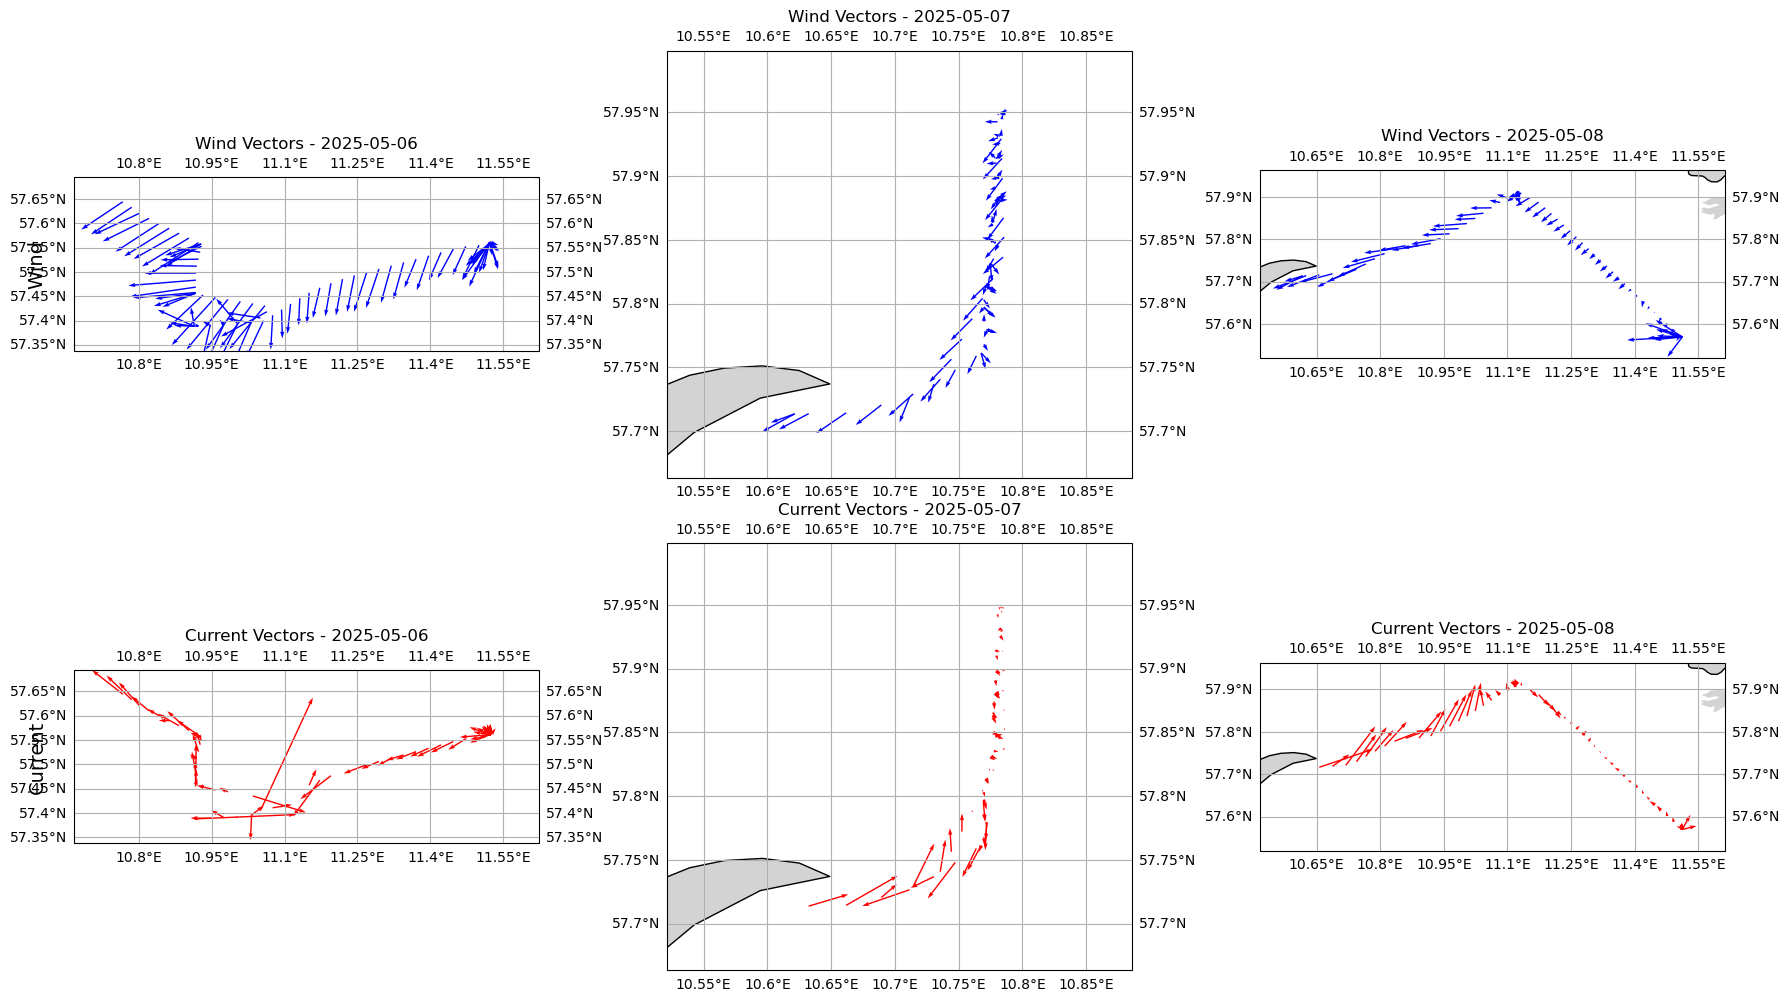

In [118]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, axes = plt.subplots(2, 3, figsize=(18, 10),
                         subplot_kw={'projection': ccrs.PlateCarree()})

dates = list(depth_avg_current_by_day.keys())

for col, date in enumerate(dates):
    # --- 1. ADCP time (used in interpolation) ---
    ds = adcp_datasets[col]
    adcp_time = pd.to_datetime(ds['time'].values)
    adcp_time_ns = adcp_time.astype(np.int64)

    # --- 2. Interpolate FerryBox GPS to ADCP time ---
    base_day = df_buoy_base[pd.to_datetime(df_buoy_base['datetime']).dt.date == date]
    ferry_time_ns = pd.to_datetime(base_day['datetime']).astype(np.int64)
    lons = np.interp(adcp_time_ns, ferry_time_ns, base_day['Longitude'])
    lats = np.interp(adcp_time_ns, ferry_time_ns, base_day['Latitude'])

    # --- 3. Get wind (already interpolated to ADCP time) ---
    wind_data = wind_interp_by_day[date]
    wind_dir_rad = np.deg2rad(wind_data['dir_deg'])
    wind_u = wind_data['speed'] * np.cos(wind_dir_rad)
    wind_v = wind_data['speed'] * np.sin(wind_dir_rad)

    # --- 4. Get current (already averaged) ---
    current_data = depth_avg_current_by_day[date]
    current_dir_rad = np.deg2rad(current_data['dir_deg'])
    current_u = current_data['speed'] * np.cos(current_dir_rad)
    current_v = current_data['speed'] * np.sin(current_dir_rad)

    # --- 5. Plot Wind ---
    ax_wind = axes[0, col]
    ax_wind.set_title(f"Wind Vectors - {date}")
    ax_wind.add_feature(cfeature.COASTLINE)
    ax_wind.add_feature(cfeature.LAND, facecolor='lightgray')
    ax_wind.add_feature(cfeature.BORDERS, linestyle=':')
    ax_wind.quiver(lons, lats, wind_u, wind_v,
                   scale=100, width=0.003, color='blue', transform=ccrs.PlateCarree())
    ax_wind.set_extent([lons.min() - 0.1, lons.max() + 0.1, lats.min() - 0.05, lats.max() + 0.05])
    ax_wind.gridlines(draw_labels=True)

    # --- 6. Plot Current ---
    ax_current = axes[1, col]
    ax_current.set_title(f"Current Vectors - {date}")
    ax_current.add_feature(cfeature.COASTLINE)
    ax_current.add_feature(cfeature.LAND, facecolor='lightgray')
    ax_current.add_feature(cfeature.BORDERS, linestyle=':')
    ax_current.quiver(lons, lats, current_u, current_v,
                      scale=10, width=0.003, color='red', transform=ccrs.PlateCarree())
    ax_current.set_extent([lons.min() - 0.1, lons.max() + 0.1, lats.min() - 0.05, lats.max() + 0.05])
    ax_current.gridlines(draw_labels=True)

    if col == 0:
        axes[0, col].text(-0.08, 0.5, 'Wind', va='center', ha='center',
                          rotation='vertical', transform=axes[0, col].transAxes, fontsize=14)
        axes[1, col].text(-0.08, 0.5, 'Current', va='center', ha='center',
                          rotation='vertical', transform=axes[1, col].transAxes, fontsize=14)

plt.tight_layout()
plt.show()


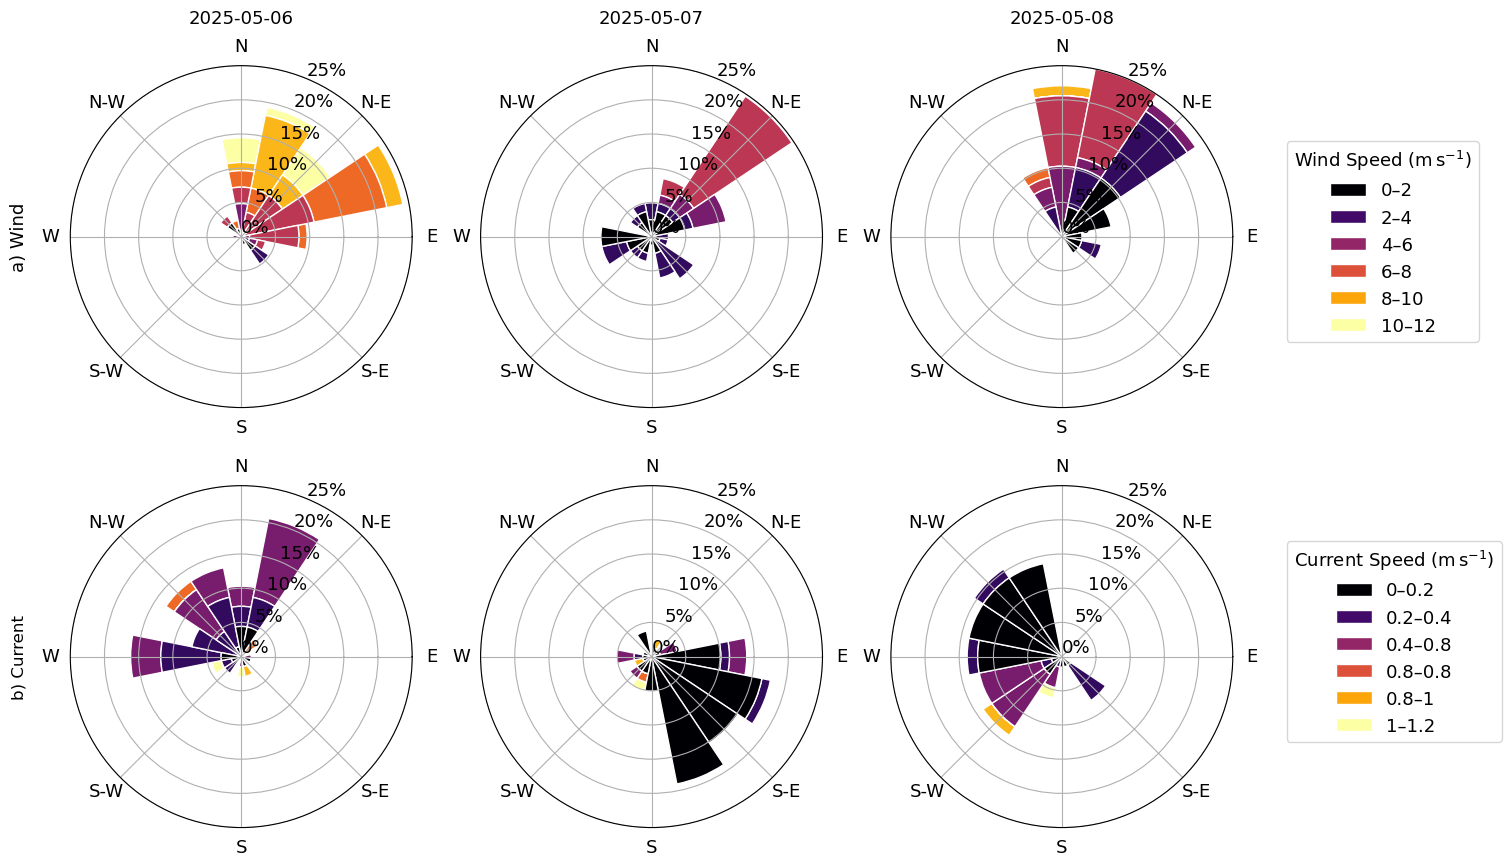

In [103]:
# Define consistent bins and colormaps
speed_bins = [0, 2, 4, 6, 8, 10, 12]
speed_bins_curr = [0, 0.2, 0.4, 0.8, 0.8, 1, 1.2]

# Larger figure to make room for shared legends
fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, 3)
dates = [df_q['date'].iloc[0] for df_q in Q_EBF_all]

# Placeholders to store legend handles
from matplotlib.patches import Patch

colors_wind = plt.cm.inferno(np.linspace(0, 1, len(speed_bins) - 1))
colors_curr = plt.cm.inferno(np.linspace(0, 1, len(speed_bins_curr) - 1))
labels = [f"{speed_bins[i]}–{speed_bins[i+1]}" for i in range(len(speed_bins) - 1)]
handles_wind = [Patch(facecolor=colors_wind[i], edgecolor='white') for i in range(len(labels))]
labels_curr = [f"{speed_bins_curr[i]}–{speed_bins_curr[i+1]}" for i in range(len(speed_bins_curr) - 1)]
handles_curr = [Patch(facecolor=colors_curr[i], edgecolor='white') for i in range(len(labels_curr))]

# Set a fixed max radius for consistent radial scale across plots
max_radius = 25  # Adjust based on your data's typical max percentage
yticks = [0, 5, 10, 15, 20, 25]

for i, date in enumerate(dates):
    # --- Windrose: Wind ---
    wind = wind_interp_by_day[date]
    wind_dir = (wind['dir_deg'] + 180) % 360  # Convert back to 'from' direction for plotting
    wind_speed = wind['speed']
    mask_wind = (~np.isnan(wind_dir)) & (~np.isnan(wind_speed))

    ax_wind = WindroseAxes.from_ax(fig=fig, rect=gs[0, i].get_position(fig))
    ax_wind.tick_params(labelsize=13)
    fig.add_axes(ax_wind)
    ax_wind.bar(wind_dir[mask_wind], wind_speed[mask_wind],
                bins=speed_bins, cmap=plt.cm.inferno, normed=True,
                opening=1, edgecolor='white')
    ax_wind.set_ylim(0, max_radius)
    ax_wind.set_yticks(yticks)
    ax_wind.set_yticklabels([f"{y}%" for y in yticks], fontsize=13)
    ax_wind.set_title(f"{date}", fontsize=13, y=1.1)
    if i == 0:
        ax_wind.text(-0.15, 0.5, 'a) Wind', rotation='vertical',
                     va='center', ha='center', fontsize=13, transform=ax_wind.transAxes)

    if handles_wind is None:
        handles_wind, labels_wind = ax_wind.get_legend_handles_labels()

    # --- Windrose: Depth-averaged current ---
    current = depth_avg_current_by_day[date]
    current_dir = current['dir_deg']
    current_dir = (current['dir_deg'] + 180) % 360  # Convert to 'from' direction for plotting
    current_speed = current['speed']
    mask_curr = (~np.isnan(current_dir)) & (~np.isnan(current_speed))

    ax_curr = WindroseAxes.from_ax(fig=fig, rect=gs[1, i].get_position(fig))
    ax_curr.tick_params(labelsize=13)
    fig.add_axes(ax_curr)
    ax_curr.bar(current_dir[mask_curr], current_speed[mask_curr],
                bins=speed_bins_curr, cmap=plt.cm.inferno, normed=True,
                opening=1, edgecolor='white')
    ax_curr.set_ylim(0, max_radius)
    ax_curr.set_yticks(yticks)
    ax_curr.set_yticklabels([f"{y}%" for y in yticks], fontsize=13)
    #ax_curr.set_title(f"{date}", fontsize=12, y=1.066)
    if i == 0:
        ax_curr.text(-0.15, 0.5, 'b) Current', rotation='vertical',
                     va='center', ha='center', fontsize=12, transform=ax_curr.transAxes)

    if handles_curr is None:
        handles_curr, labels_curr = ax_curr.get_legend_handles_labels()

# Adjust space to make room for legends
plt.subplots_adjust(top=0.88, bottom=0.15, hspace=1.2, wspace=0.3)

# Add shared legends
fig.legend(handles_wind, labels,
           loc='center left', bbox_to_anchor=(0.93, 0.70),
           ncol=1, title='Wind Speed ($\mathrm{m\,s^{-1}}$)', fontsize=13, title_fontsize=13)

fig.legend(handles_curr, labels_curr,
           loc='center left', bbox_to_anchor=(0.93, 0.30),
           ncol=1, title='Current Speed ($\mathrm{m\,s^{-1}}$)', fontsize=13, title_fontsize=13)

plt.show()

In [11]:
print("Wind speed summary:")
for date in dates:
    wind = wind_interp_by_day[date]
    speed = wind['speed']
    mean_speed = np.nanmean(speed)
    max_speed = np.nanmax(speed)
    print(f"{date} - Mean: {mean_speed:.3f} m/s, Max: {max_speed:.3f} m/s")


Wind speed summary:
2025-05-06 - Mean: 7.960 m/s, Max: 14.580 m/s
2025-05-07 - Mean: 3.118 m/s, Max: 7.953 m/s
2025-05-08 - Mean: 3.985 m/s, Max: 11.883 m/s


In [12]:
print("Current speed summary:")
for date in dates:
    current = depth_avg_current_by_day[date]
    speed = current['speed']
    mean_speed = np.nanmean(speed)
    max_speed = np.nanmax(speed)
    print(f"{date} - Mean: {mean_speed:.3f} m/s, Max: {max_speed:.3f} m/s")



Current speed summary:
2025-05-06 - Mean: 0.430 m/s, Max: 2.678 m/s
2025-05-07 - Mean: 0.208 m/s, Max: 1.281 m/s
2025-05-08 - Mean: 0.290 m/s, Max: 1.220 m/s


# Full pipeline CTD, day 2, 2 m bouyancy grad

In [138]:

# --- Load and process CTD files ---

# --- Load CTD data files into memory ---
from pathlib import Path

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')

def load_cnv(filepath):
    def dms_to_decimal(degrees, minutes, direction):
        decimal = float(degrees) + float(minutes) / 60
        if direction.upper() in ['S', 'W']:
            decimal *= -1
        return decimal

    with open(filepath, 'r', encoding='latin1') as f:
        lines = f.readlines()

    data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
    df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
    df.columns = [f'col_{i}' for i in range(df.shape[1])]

    lat = lon = None
    time_local = None
    for line in lines:
        if 'latitude' in line.lower():
            parts = line.split()
            try:
                lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'longitude' in line.lower():
            parts = line.split()
            try:
                lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'start time' in line.lower():
            try:
                time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
            except:
                continue

    time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
    return df, lat, lon, time_utc


def process_ctd_casts(folder_path):
    filenames = [
        'CTD_05_avg.cnv', 'CTD_06_avg.cnv', 'CTD_07_avg.cnv', 'CTD_08_avg.cnv',
        'CTD_09_avg.cnv', 'CTD_10_avg.cnv', 'CTD_11_avg.cnv', 'CTD_12_avg.cnv',
        'CTD_13_avg.cnv', 'CTD_14_avg.cnv', 'CTD_15_avg.cnv', 'CTD_16_avg.cnv'
    ]
    cast_data = []
    for file in filenames:
        full_path = Path(folder_path) / file
        df, lat, lon, time_utc = load_cnv(full_path)

        SP = df['col_9'].to_numpy()
        T = df['col_2'].to_numpy()
        p = df['col_1'].to_numpy()

        SA = gsw.SA_from_SP(SP, p, lon, lat)
        CT = gsw.CT_from_t(SA, T, p)
        rho = gsw.rho(SA, CT, p=0)

        cast_data.append({
            'time': time_utc,
            'lat': lat,
            'lon': lon,
            'SA': SA,
            'CT': CT,
            'p': p,
            'rho': rho
        })
    return cast_data

ctd_casts = process_ctd_casts(folder_path)

In [139]:
# --- Load Wind and ADCP data ---
def load_wind_adcp(wind_file, adcp_file):
    df_wind = pd.read_csv(wind_file)
    df_wind['datetime'] = pd.to_datetime(df_wind['ts'])
    wind_speed = df_wind['windspeed'].to_numpy()
    wind_dir_rad = np.deg2rad((df_wind['winddir'] + 180) % 360)

    adcp = pd.read_csv(adcp_file, sep="\t", skiprows=12, engine="python").iloc[3:-3].reset_index(drop=True)
    adcp = adcp.map(lambda x: str(x).replace(",", "."))

    def parse_int(x):
        try:
            return int(float(x))
        except:
            return 0

    ymdhms = adcp[['YR', 'MO', 'DA', 'HH', 'MM', 'SS']].apply(lambda col: col.map(parse_int)).to_numpy()
    adcp_time = [dt.datetime(2000 + y, m, d, hh, mm, ss) for y, m, d, hh, mm, ss in ymdhms]
    adcp_time = [pytz.timezone('Europe/Stockholm').localize(t).astimezone(pytz.utc).replace(tzinfo=None) for t in adcp_time]

    u = adcp[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
    v = adcp[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
    theta_current = np.arctan2(v, u)

    df_adcp = pd.DataFrame({
        'datetime': adcp_time,
        'theta_current': theta_current
    })

    df_interp = pd.DataFrame({
        'datetime': df_wind['datetime'],
        'wind_speed': np.interp(df_wind['datetime'].astype(np.int64), df_wind['datetime'].astype(np.int64), wind_speed),
        'wind_dir_rad': np.interp(df_wind['datetime'].astype(np.int64), df_wind['datetime'].astype(np.int64), wind_dir_rad),
        'current_dir_rad': np.interp(df_wind['datetime'].astype(np.int64), df_adcp['datetime'].astype(np.int64), df_adcp['theta_current'])
    })
    return df_interp


# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# --- Load wind and ADCP data ---
wind_file = folder_path / 'sk_weather.csv'
adcp_file = folder_path / 'adcp0507_postpro20may.txt'
df_env = load_wind_adcp(wind_file, adcp_file)


In [17]:
# --- Interpolate buoyancy onto regular grid ---
def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=40):
    from scipy.interpolate import interp1d
    from scipy.ndimage import gaussian_filter1d

    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)  # 1 m vertical resolution

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)
    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    b_2m = b_grid[np.argmin(np.abs(z_reg - 2))]
    b_2m_smooth = gaussian_filter1d(b_2m, sigma=8)
    dbdx = np.gradient(b_2m_smooth, dx)

    return d_reg, b_2m_smooth, dbdx, z_reg, b_grid


# # --- Compute Ekman Buoyancy Flux using updated interpolation ---
# def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
#     # Constants
#     g = 9.81
#     Cp = 4000  # J/kg/K
#     rho_air = 1.2  # kg/m^3
#     Cd = 1.5e-3  # drag coefficient
#     f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))

#     # Wind stress and along-front component
#     tau = Cd * rho_air * wind_speed ** 2
#     delta_theta = wind_dir_rad - current_dir_rad
#     tau_along = tau * np.cos(delta_theta)

#     # Thermal expansion coefficient (assume at 2m depth)
#     alpha = gsw.alpha(SA_i, CT_i, 0)

#     # Ekman buoyancy flux (converted to heat flux units)
#     Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

#     return pd.DataFrame({
#         'distance_m': dist_grid,
#         'Q_EBF': Q_EBF,
#         'b_2m': b_smooth,
#         'dbdx': dbdx,
#         'tau_along': tau_along
#     })



def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
    # Constants
    g = 9.81
    Cp = 4000  # J/kg/K
    rho_air = 1.2  # kg/m^3
    Cd = 1.5e-3  # drag coefficient
    f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))

    # Wind stress and along-front component
    tau = Cd * rho_air * wind_speed ** 2
    delta_theta = wind_dir_rad - current_dir_rad
    tau_along = tau * np.cos(delta_theta)

    # Thermal expansion coefficient (assume at 2m depth)
    alpha = gsw.alpha(SA_i, CT_i, 0)

    # Print α and f for inspection
    print("Mean α (thermal expansion coefficient):", np.nanmean(alpha))
    print("Coriolis parameter f:", f)

    # Ekman buoyancy flux (converted to heat flux units)
    Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

    return pd.DataFrame({
        'distance_m': dist_grid,
        'Q_EBF': Q_EBF,
        'b_2m': b_smooth,
        'dbdx': dbdx,
        'tau_along': tau_along
    })


# --- Interpolate SA and CT onto regular grid ---
def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
    from scipy.interpolate import griddata

    sa_points = []
    ct_points = []
    sa_values = []
    ct_values = []

    for i, cast in enumerate(cast_data):
        p = cast['p']
        SA = cast['SA']
        CT = cast['CT']
        z = gsw.z_from_p(p, cast['lat']) * -1  # convert to depth in meters
        mask = (z >= 0) & (z <= np.max(depth_grid))
        z = z[mask]
        SA = SA[mask]
        CT = CT[mask]

        for zi, sai, cti in zip(z, SA, CT):
            sa_points.append([distances[i], zi])
            ct_points.append([distances[i], zi])
            sa_values.append(sai)
            ct_values.append(cti)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
    CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')

    return SA_grid, CT_grid



# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# Step 1: Generate interpolation grids for buoyancy, SA, and CT
from pyproj import Geod

dx = 1500  # increase interpolation step to reduce oversmoothing and match station spacing

dist_grid, b_smooth_2m, dbdx, depth_grid, b_grid = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# Step 2: Compute distances from CTD casts
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

# Step 3: Interpolate SA and CT
SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

# Step 4: Extract SA and CT at 2m
SA_i = SA_grid[np.argmin(np.abs(depth_grid - 2)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 2)), :]

# Step 5: Compute Q_EBF
df_ctd = compute_Q_EBF_ctd(
    dist_grid, SA_i, CT_i, b_smooth_2m, dbdx,
    wind_speed=df_env['wind_speed'].iloc[0],
    wind_dir_rad=df_env['wind_dir_rad'].iloc[0],
    current_dir_rad=df_env['current_dir_rad'].iloc[0]
)

NameError: name 'df_env' is not defined

C:\Users\Sussi\AppData\Local\Temp\ipykernel_16368\3764206552.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


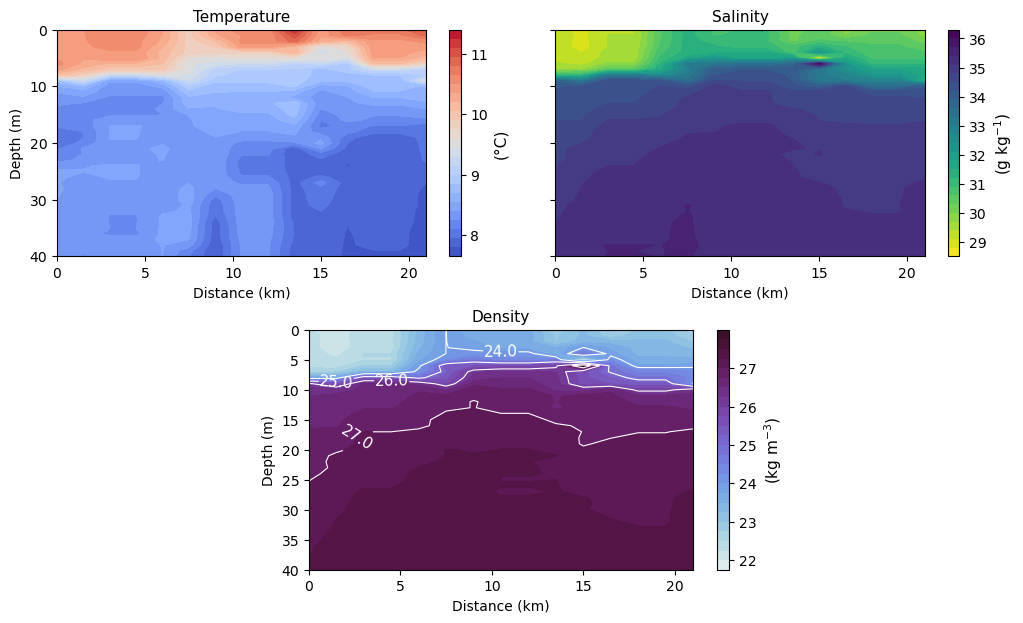

In [ ]:
# Step 6: Plot CT, SA, and Sigma0 fields
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cmocean as cmo

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

fig = plt.figure(figsize=(12, 6))

# Unified GridSpec layout
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], hspace=0.25, wspace=0.08, left=0.1, right=0.9, top=0.95, bottom=0.1)

# Top row for Temperature and Salinity
ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])

# Bottom row: Density spans both columns
ax_dens = fig.add_axes([0.31, 0.05, 0.4, 0.4])


# Plot Temperature
cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=11)
ax_temp.set_xlabel('Distance (km)')
ax_temp.set_ylabel('Depth (m)')
ax_temp.set_ylim(40, 0)
ax_temp.set_yticks(np.arange(0, 41, 10))
cb1 = plt.colorbar(cs1, ax=ax_temp, ticks=np.arange(int(np.nanmin(CT_grid)), int(np.nanmax(CT_grid)) + 1))
cb1.set_label('(°C)', fontsize=11)

# Plot Salinity
cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=11)
ax_sali.set_xlabel('Distance (km)')
ax_sali.set_ylim(40, 0)
ax_sali.tick_params(axis='y', labelleft=False)
ax_sali.set_yticks(np.arange(0, 41, 10))
#cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2 = plt.colorbar(cs2, ax=ax_sali, ticks=np.arange(int(np.nanmin(SA_grid)), int(np.nanmax(SA_grid)) + 1))
cb2.set_label(r'(g kg$^{-1}$)', fontsize=11)



# Plot Sigma0
cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
# Define desired contour levels
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),  # For 24
    (dist_grid[len(dist_grid) // 11] / 1000, 9),  # For 25
    (dist_grid[len(dist_grid) //5] / 1000, 11),  # For 26
    (dist_grid[len(dist_grid) // 10] / 1000, 15),  # For 27
    #(dist_grid[len(dist_grid) * 3 // 4] / 1000, 30),  # For 28
]

# manual_positions = [
#     (dist_grid[len(dist_grid) // 6] / 1000, 3),  # For 24
#     (dist_grid[len(dist_grid) // 10] / 1000, 9),  # For 25
#     (dist_grid[len(dist_grid) //5] / 1000, 11),  # For 26
#     (dist_grid[len(dist_grid) // 8] / 1000, 15),  # For 27
#     #(dist_grid[len(dist_grid) * 3 // 4] / 1000, 30),  # For 28
# ]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=11, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=11)
ax_dens.set_xlabel('Distance (km)')
ax_dens.set_ylabel('Depth (m)')
ax_dens.set_ylim(40, 0)
ax_dens.set_xticks(np.arange(0, 21, 5))
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=11)

plt.tight_layout()
plt.show()

# Full CTD pipline, Day 2, 5 m bouyancy grad

In [15]:
# --- Load CTD data files into memory ---
from pathlib import Path
import pandas as pd
import numpy as np
import datetime as dt
import pytz
import gsw

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')

def load_cnv(filepath):
    def dms_to_decimal(degrees, minutes, direction):
        decimal = float(degrees) + float(minutes) / 60
        if direction.upper() in ['S', 'W']:
            decimal *= -1
        return decimal

    with open(filepath, 'r', encoding='latin1') as f:
        lines = f.readlines()

    data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
    df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
    df.columns = [f'col_{i}' for i in range(df.shape[1])]

    lat = lon = None
    time_local = None
    for line in lines:
        if 'latitude' in line.lower():
            parts = line.split()
            try:
                lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'longitude' in line.lower():
            parts = line.split()
            try:
                lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'start time' in line.lower():
            try:
                time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
            except:
                continue

    time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
    return df, lat, lon, time_utc

def process_ctd_casts(folder_path):
    filenames = [
        'CTD_05_avg.cnv', 'CTD_06_avg.cnv', 'CTD_07_avg.cnv', 'CTD_08_avg.cnv',
        'CTD_09_avg.cnv', 'CTD_10_avg.cnv', 'CTD_11_avg.cnv', 'CTD_12_avg.cnv',
        'CTD_13_avg.cnv', 'CTD_14_avg.cnv', 'CTD_15_avg.cnv', 'CTD_16_avg.cnv'
    ]
    cast_data = []
    for file in filenames:
        full_path = Path(folder_path) / file
        df, lat, lon, time_utc = load_cnv(full_path)

        SP = df['col_9'].to_numpy()
        T = df['col_2'].to_numpy()
        p = df['col_1'].to_numpy()

        SA = gsw.SA_from_SP(SP, p, lon, lat)
        CT = gsw.CT_from_t(SA, T, p)
        rho = gsw.rho(SA, CT, p=0)

        cast_data.append({
            'time': time_utc,
            'lat': lat,
            'lon': lon,
            'SA': SA,
            'CT': CT,
            'p': p,
            'rho': rho
        })
    return cast_data

ctd_casts = process_ctd_casts(folder_path)

# --- Interpolate buoyancy onto regular grid ---
from pyproj import Geod
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d

def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=40):
    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)
    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    b_5m = b_grid[np.argmin(np.abs(z_reg - 5))]
    b_5m_smooth = gaussian_filter1d(b_5m, sigma=8)
    dbdx = np.gradient(b_5m_smooth, dx)

    return d_reg, b_5m_smooth, dbdx, z_reg, b_grid

# --- Interpolate SA and CT onto regular grid ---
from scipy.interpolate import griddata

def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
    sa_points = []
    ct_points = []
    sa_values = []
    ct_values = []

    for i, cast in enumerate(cast_data):
        p = cast['p']
        SA = cast['SA']
        CT = cast['CT']
        z = gsw.z_from_p(p, cast['lat']) * -1
        mask = (z >= 0) & (z <= np.max(depth_grid))
        z = z[mask]
        SA = SA[mask]
        CT = CT[mask]

        for zi, sai, cti in zip(z, SA, CT):
            sa_points.append([distances[i], zi])
            ct_points.append([distances[i], zi])
            sa_values.append(sai)
            ct_values.append(cti)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
    CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')

    return SA_grid, CT_grid

# --- Compute Q_EBF ---
def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
    g = 9.81
    Cp = 4000
    rho_air = 1.2
    Cd = 1.5e-3
    f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))

    tau = Cd * rho_air * wind_speed ** 2
    delta_theta = wind_dir_rad - current_dir_rad
    tau_along = tau * np.cos(delta_theta)

    alpha = gsw.alpha(SA_i, CT_i, 0)

    Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

    return pd.DataFrame({
        'distance_m': dist_grid,
        'Q_EBF': Q_EBF,
        'b_5m': b_smooth,
        'dbdx': dbdx,
        'tau_along': tau_along
    })

In [18]:
# --- Load Wind and ADCP data ---
def load_wind_adcp(wind_file, adcp_file):
    df_wind = pd.read_csv(wind_file)
    df_wind['datetime'] = pd.to_datetime(df_wind['ts'])
    wind_speed = df_wind['windspeed'].to_numpy()
    wind_dir_rad = np.deg2rad((df_wind['winddir'] + 180) % 360)

    adcp = pd.read_csv(adcp_file, sep="\t", skiprows=12, engine="python").iloc[3:-3].reset_index(drop=True)
    adcp = adcp.map(lambda x: str(x).replace(",", "."))

    def parse_int(x):
        try:
            return int(float(x))
        except:
            return 0

    ymdhms = adcp[['YR', 'MO', 'DA', 'HH', 'MM', 'SS']].apply(lambda col: col.map(parse_int)).to_numpy()
    adcp_time = [dt.datetime(2000 + y, m, d, hh, mm, ss) for y, m, d, hh, mm, ss in ymdhms]
    adcp_time = [pytz.timezone('Europe/Stockholm').localize(t).astimezone(pytz.utc).replace(tzinfo=None) for t in adcp_time]

    u = adcp[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
    v = adcp[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
    theta_current = np.arctan2(v, u)

    df_adcp = pd.DataFrame({
        'datetime': adcp_time,
        'theta_current': theta_current
    })

    df_interp = pd.DataFrame({
        'datetime': df_wind['datetime'],
        'wind_speed': np.interp(df_wind['datetime'].astype(np.int64), df_wind['datetime'].astype(np.int64), wind_speed),
        'wind_dir_rad': np.interp(df_wind['datetime'].astype(np.int64), df_wind['datetime'].astype(np.int64), wind_dir_rad),
        'current_dir_rad': np.interp(df_wind['datetime'].astype(np.int64), df_adcp['datetime'].astype(np.int64), df_adcp['theta_current'])
    })
    return df_interp


# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# --- Load wind and ADCP data ---
wind_file = folder_path / 'sk_weather.csv'
adcp_file = folder_path / 'adcp0507_postpro20may.txt'
df_env = load_wind_adcp(wind_file, adcp_file)


In [19]:
# --- Run pipeline ---
dist_grid, b_smooth_5m, dbdx, depth_grid, b_grid = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

distances = [0]
geod = Geod(ellps="WGS84")
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

SA_i = SA_grid[np.argmin(np.abs(depth_grid - 5)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 5)), :]

# Assuming df_env is already loaded earlier
df_ctd = compute_Q_EBF_ctd(
    dist_grid, SA_i, CT_i, b_smooth_5m, dbdx,
    wind_speed=df_env['wind_speed'].iloc[0],
    wind_dir_rad=df_env['wind_dir_rad'].iloc[0],
    current_dir_rad=df_env['current_dir_rad'].iloc[0]
)


Mean α (thermal expansion coefficient): 0.00015547929695846106
Coriolis parameter f: 0.00012231339297029653


C:\Users\Sussi\AppData\Local\Temp\ipykernel_15672\436716646.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


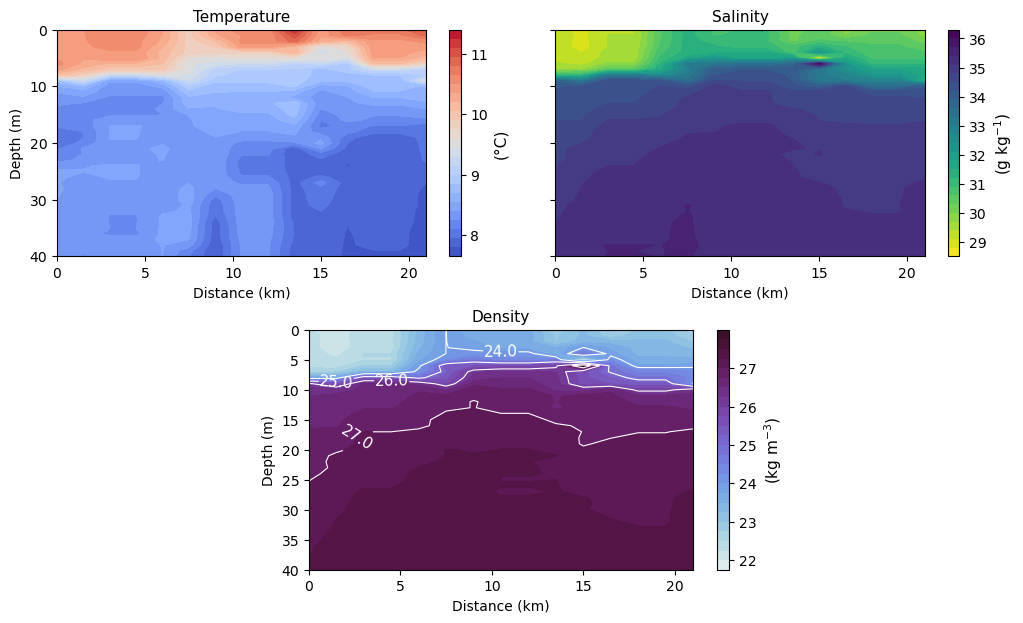

In [21]:
import cmocean as cmo
# --- Plot CT, SA, and Sigma0 ---
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], hspace=0.25, wspace=0.08, left=0.1, right=0.9, top=0.95, bottom=0.1)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_axes([0.31, 0.05, 0.4, 0.4])

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=11)
ax_temp.set_xlabel('Distance (km)')
ax_temp.set_ylabel('Depth (m)')
ax_temp.set_ylim(40, 0)
ax_temp.set_yticks(np.arange(0, 41, 10))
cb1 = plt.colorbar(cs1, ax=ax_temp, ticks=np.arange(int(np.nanmin(CT_grid)), int(np.nanmax(CT_grid)) + 1))
cb1.set_label('(°C)', fontsize=11)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=11)
ax_sali.set_xlabel('Distance (km)')
ax_sali.set_ylim(40, 0)
ax_sali.tick_params(axis='y', labelleft=False)
ax_sali.set_yticks(np.arange(0, 41, 10))
cb2 = plt.colorbar(cs2, ax=ax_sali, ticks=np.arange(int(np.nanmin(SA_grid)), int(np.nanmax(SA_grid)) + 1))
cb2.set_label(r'(g kg$^{-1}$)', fontsize=11)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=11, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=11)
ax_dens.set_xlabel('Distance (km)')
ax_dens.set_ylabel('Depth (m)')
ax_dens.set_ylim(40, 0)
ax_dens.set_xticks(np.arange(0, 21, 5))
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=11)

plt.tight_layout()
plt.show()

C:\Users\Sussi\AppData\Local\Temp\ipykernel_15672\1048977028.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


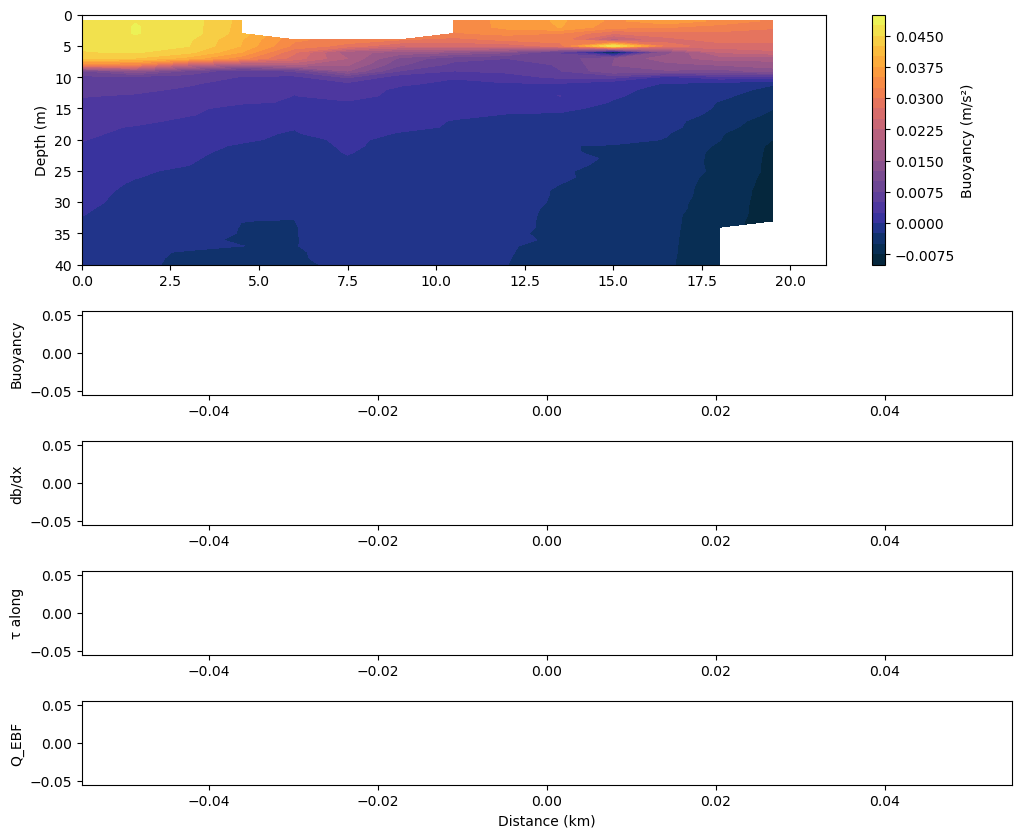

In [23]:
from scipy.interpolate import UnivariateSpline

def compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=10, delta_sigma=0.03):
    ref_index = np.argmin(np.abs(depth_grid - ref_depth))
    ref_density = sigma0_grid[ref_index, :]

    mld_array = np.full(sigma0_grid.shape[1], np.nan)
    for i in range(sigma0_grid.shape[1]):
        profile = sigma0_grid[:, i]
        if np.all(np.isnan(profile)) or np.isnan(ref_density[i]):
            continue

        delta = profile - ref_density[i]
        try:
            spline = UnivariateSpline(depth_grid, delta - delta_sigma, s=0)
            roots = spline.roots()
            if roots.size > 0:
                mld_array[i] = roots[0]
        except:
            continue
    return mld_array


# --- Plot MLD, buoyancy, gradients, and Q_EBF ---
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(5, 1, height_ratios=[3, 1, 1, 1, 1], hspace=0.4)

# Full vertical buoyancy profile
ax0 = fig.add_subplot(gs[0])
bf = ax0.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb = fig.colorbar(bf, ax=ax0, orientation='vertical')
cb.set_label('Buoyancy (m/s²)')
ax0.set_ylabel('Depth (m)')
ax0.set_ylim(40, 0)

# Buoyancy at 5 m
ax1 = fig.add_subplot(gs[1])
ax1.plot(dist_grid / 1000, b_smooth_5m, label='Buoyancy (5m)')
ax1.set_ylabel('Buoyancy')

# Gradient db/dx
ax2 = fig.add_subplot(gs[2])
ax2.plot(dist_grid / 1000, dbdx, label='db/dx', color='tab:orange')
ax2.set_ylabel('db/dx')

# Tau Along
ax3 = fig.add_subplot(gs[3])
ax3.plot(dist_grid / 1000, df_ctd['tau_along'], label='Tau Along', color='tab:green')
ax3.set_ylabel('τ along')

# Q_EBF
ax4 = fig.add_subplot(gs[4])
ax4.plot(dist_grid / 1000, df_ctd['Q_EBF'], label='Q_EBF', color='tab:red')
ax4.set_ylabel('Q_EBF')
ax4.set_xlabel('Distance (km)')

plt.tight_layout()
plt.show()

C:\Users\Sussi\AppData\Local\Temp\ipykernel_15672\4078065878.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


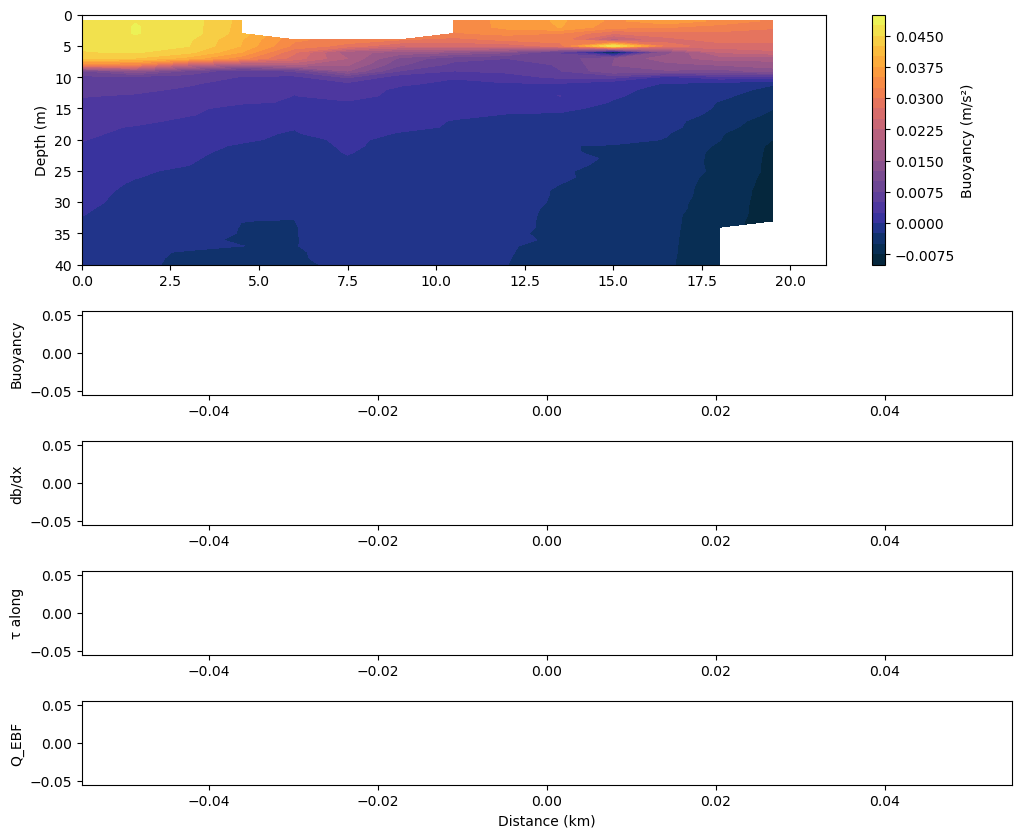

In [25]:
# --- Plot MLD, buoyancy, gradients, and Q_EBF ---
fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(5, 1, height_ratios=[3, 1, 1, 1, 1], hspace=0.4)

# Full vertical buoyancy profile
ax0 = fig.add_subplot(gs[0])
bf = ax0.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb = fig.colorbar(bf, ax=ax0, orientation='vertical')
cb.set_label('Buoyancy (m/s²)')
ax0.set_ylabel('Depth (m)')
ax0.set_ylim(40, 0)

# Buoyancy at 5 m
ax1 = fig.add_subplot(gs[1])
mask_b = ~np.isnan(b_smooth_5m)
ax1.plot(dist_grid[mask_b] / 1000, b_smooth_5m[mask_b], label='Buoyancy (5m)')
ax1.set_ylabel('Buoyancy')

# Gradient db/dx
ax2 = fig.add_subplot(gs[2])
mask_dbdx = ~np.isnan(dbdx)
ax2.plot(dist_grid[mask_dbdx] / 1000, dbdx[mask_dbdx], label='db/dx', color='tab:orange')
ax2.set_ylabel('db/dx')

# Tau Along
ax3 = fig.add_subplot(gs[3])
mask_tau = ~df_ctd['tau_along'].isna()
ax3.plot(dist_grid[mask_tau] / 1000, df_ctd['tau_along'][mask_tau], label='Tau Along', color='tab:green')
ax3.set_ylabel('τ along')

# Q_EBF
ax4 = fig.add_subplot(gs[4])
mask_q = ~df_ctd['Q_EBF'].isna()
ax4.plot(dist_grid[mask_q] / 1000, df_ctd['Q_EBF'][mask_q], label='Q_EBF', color='tab:red')
ax4.set_ylabel('Q_EBF')
ax4.set_xlabel('Distance (km)')

plt.tight_layout()
plt.show()

Some changes:

In [142]:
for idx in [4]:  # Apply vertical interpolation to CTD_09
    for var in ['SA', 'CT']:
        profile = ctd_casts[idx][var]
        p = ctd_casts[idx]['p']
        z = gsw.z_from_p(p, ctd_casts[idx]['lat']) * -1

        print(f"\nOriginal {var} (CTD_09) at depths near 2 m:")
        for zi, vi in zip(z, profile):
            if 1.0 <= zi <= 3.0:
                print(f"  z = {zi:.2f} m, value = {vi:.3f}")

        if np.sum(~np.isnan(profile)) > 1:
            z_valid = z[~np.isnan(profile)]
            profile_valid = profile[~np.isnan(profile)]
            interp_fn = interp1d(z_valid, profile_valid, bounds_error=False, fill_value=np.nan)
            profile_interp = interp_fn(z)
            ctd_casts[idx][var] = profile_interp

            print(f"\nInterpolated {var} (CTD_09) at depths near 2 m:")
            for zi, vi in zip(z, profile_interp):
                if 1.0 <= zi <= 3.0:
                    print(f"  z = {zi:.2f} m, value = {vi:.3f}")



Original SA (CTD_09) at depths near 2 m:

Interpolated SA (CTD_09) at depths near 2 m:

Original CT (CTD_09) at depths near 2 m:

Interpolated CT (CTD_09) at depths near 2 m:


In [143]:
# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# Step 1: Generate interpolation grids for buoyancy, SA, and CT
from pyproj import Geod

dx = 1500  # increase interpolation step to reduce oversmoothing and match station spacing

def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=40):
    from scipy.interpolate import interp1d
    from scipy.ndimage import gaussian_filter1d

    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)  # 1 m vertical resolution

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)

    # # Fill in 2m buoyancy only for CTD_09 (index 4) using neighbors CTD_08 and CTD_10
    # z_index_2m = np.argmin(np.abs(z_reg - 2))
    # if np.isnan(b_profiles[4, z_index_2m]):
    #     neighbors = [3, 5]  # CTD_08 and CTD_10
    #     valid_neighbors = [i for i in neighbors if not np.isnan(b_profiles[i, z_index_2m])]
    #     if valid_neighbors:
    #         b_profiles[4, z_index_2m] = np.mean([b_profiles[i, z_index_2m] for i in valid_neighbors])


    
        # Interpolate vertically at CTD_09 (index 4) if 2m value is missing
    z_index_2m = np.argmin(np.abs(z_reg - 2))
    if np.isnan(b_profiles[4, z_index_2m]):
        # Use vertical profile at CTD_09 to interpolate at 2m
        profile = b_profiles[4, :]
        if np.sum(~np.isnan(profile)) > 1:
            z_vals = z_reg[~np.isnan(profile)]
            b_vals = profile[~np.isnan(profile)]
            b_interp = interp1d(z_vals, b_vals, bounds_error=False, fill_value=np.nan)
            b_profiles[4, z_index_2m] = b_interp(z_reg[z_index_2m])


    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    b_2m = b_grid[np.argmin(np.abs(z_reg - 2))]

    # Interpolate to fill NaNs before smoothing
    mask = ~np.isnan(b_2m)
    b_2m_interp = np.interp(np.arange(len(b_2m)), np.flatnonzero(mask), b_2m[mask])
    b_2m_smooth = gaussian_filter1d(b_2m_interp, sigma=8)
    dbdx = np.gradient(b_2m_smooth, dx)

    return d_reg, b_2m_smooth, dbdx, z_reg, b_grid

dist_grid, b_smooth_2m, dbdx, depth_grid, b_grid = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# Step 2: Compute distances from CTD casts
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

# Step 3: Interpolate SA and CT
SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

# Step 4: Extract SA and CT at 2m
SA_i = SA_grid[np.argmin(np.abs(depth_grid - 2)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 2)), :]

# Clean up current_dir_rad: fill missing values
if df_env['current_dir_rad'].isna().any():
    df_env['current_dir_rad'].fillna(method='ffill', inplace=True)
    df_env['current_dir_rad'].fillna(method='bfill', inplace=True)

# Step 5: Filter valid indices
valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_2m) & ~np.isnan(dbdx)

dist_grid_clean = dist_grid[valid_mask]
SA_i_clean = SA_i[valid_mask]
CT_i_clean = CT_i[valid_mask]
b_smooth_clean = b_smooth_2m[valid_mask]
dbdx_clean = dbdx[valid_mask]

# Compute Q_EBF
df_ctd = compute_Q_EBF_ctd(
    dist_grid_clean,
    SA_i_clean,
    CT_i_clean,
    b_smooth_clean,
    dbdx_clean,
    wind_speed=df_env['wind_speed'].iloc[0],
    wind_dir_rad=df_env['wind_dir_rad'].iloc[0],
    current_dir_rad=df_env['current_dir_rad'].iloc[0]
)

Mean α (thermal expansion coefficient): 0.00015899122960389252
Coriolis parameter f: 0.00012231339297029653


C:\Users\Sussi\AppData\Local\Temp\ipykernel_16368\1816036467.py:87: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_env['current_dir_rad'].fillna(method='ffill', inplace=True)
C:\Users\Sussi\AppData\Local\Temp\ipykernel_16368\1816036467.py:88: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_env['current_dir_rad'].fillna(method='bfill', inplace=True)


In [144]:
print(df_ctd)

    distance_m      Q_EBF      b_2m          dbdx  tau_along
0          0.0  -4.337780  0.038972 -5.270861e-08  -0.003882
1       1500.0  -6.430870  0.038893 -7.784730e-08  -0.003882
2       3000.0 -10.287830  0.038738 -1.258025e-07  -0.003882
3       4500.0 -13.745860  0.038515 -1.680882e-07  -0.003882
4       6000.0 -16.532430  0.038234 -2.028053e-07  -0.003882
5       7500.0 -18.986154  0.037907 -2.284092e-07  -0.003882
6       9000.0 -20.051710  0.037549 -2.438490e-07  -0.003882
7      10500.0 -19.866904  0.037175 -2.485770e-07  -0.003882
8      12000.0 -19.377463  0.036803 -2.424531e-07  -0.003882
9      13500.0 -17.877982  0.036448 -2.258144e-07  -0.003882
10     15000.0 -16.295977  0.036126 -1.994903e-07  -0.003882
11     16500.0 -13.622505  0.035849 -1.646632e-07  -0.003882
12     18000.0  -9.928569  0.035632 -1.228280e-07  -0.003882
13     19500.0  -6.128331  0.035481 -7.581458e-08  -0.003882
14     21000.0  -4.144673  0.035404 -5.126336e-08  -0.003882


In [145]:
print("SA_i NaNs:", np.isnan(SA_i).sum())
print("CT_i NaNs:", np.isnan(CT_i).sum())
print("b_smooth_2m NaNs:", np.isnan(b_smooth_2m).sum())
print("dbdx NaNs:", np.isnan(dbdx).sum())


SA_i NaNs: 0
CT_i NaNs: 0
b_smooth_2m NaNs: 0
dbdx NaNs: 0


In [146]:
print("Wind speed:", df_env['wind_speed'].iloc[0])
print("Wind dir (rad):", df_env['wind_dir_rad'].iloc[0])
print("Current dir (rad):", df_env['current_dir_rad'].iloc[0])


Wind speed: 3.4
Wind dir (rad): 3.351032163829113
Current dir (rad): 1.5925535074344044


In [147]:
print("NaNs in original b_2m:", np.isnan(b_grid[np.argmin(np.abs(depth_grid - 2))]).sum())
print("NaNs after smoothing:", np.isnan(b_smooth_2m).sum())


NaNs in original b_2m: 4
NaNs after smoothing: 0


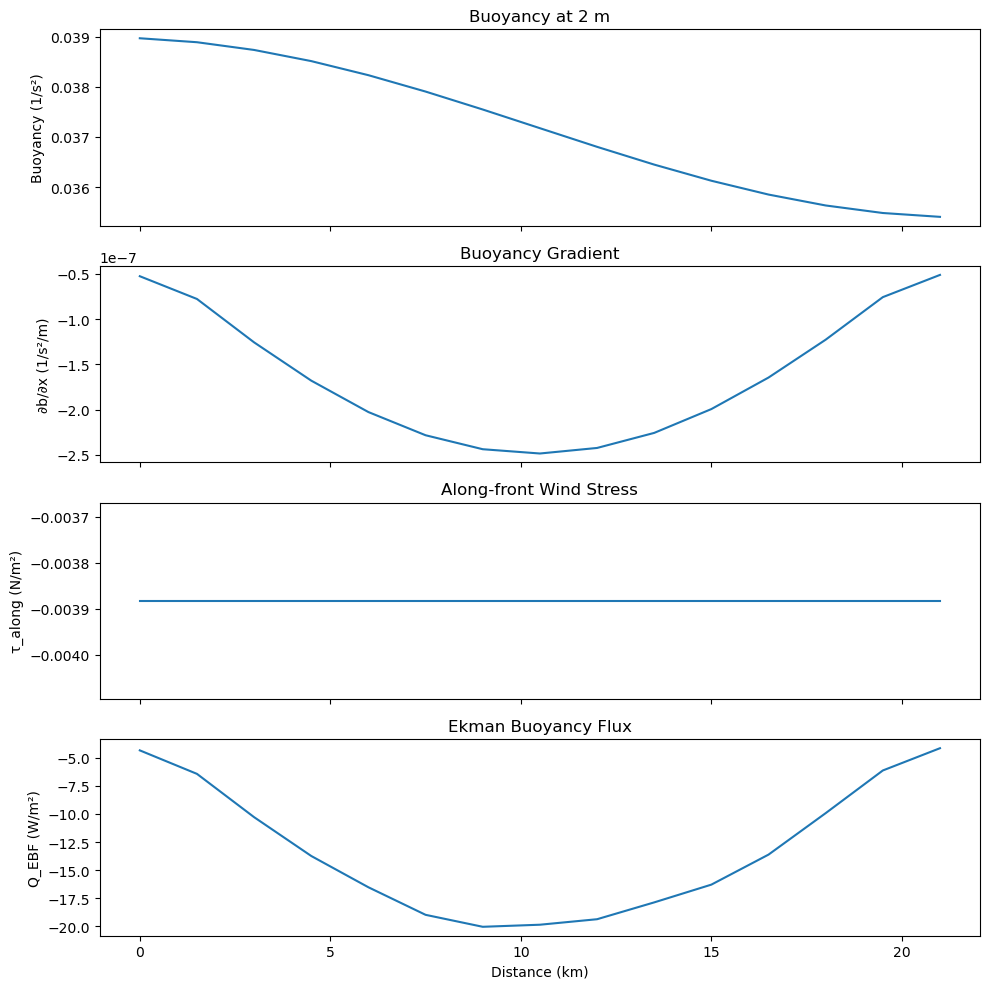

In [148]:
# Step 6: Plot b, dbdx, tau_along, and Q_EBF
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(dist_grid_clean / 1000, df_ctd['b_2m'])
axs[0].set_ylabel('Buoyancy (1/s²)')
axs[0].set_title('Buoyancy at 2 m')

axs[1].plot(dist_grid_clean / 1000, df_ctd['dbdx'])
axs[1].set_ylabel('∂b/∂x (1/s²/m)')
axs[1].set_title('Buoyancy Gradient')

axs[2].plot(dist_grid_clean / 1000, df_ctd['tau_along'])
axs[2].set_ylabel('τ_along (N/m²)')
axs[2].set_title('Along-front Wind Stress')

axs[3].plot(dist_grid_clean / 1000, df_ctd['Q_EBF'])
axs[3].set_ylabel('Q_EBF (W/m²)')
axs[3].set_title('Ekman Buoyancy Flux')
axs[3].set_xlabel('Distance (km)')

plt.tight_layout()
plt.show()

In [149]:
# Compute distances between CTD stations
station_distances_km = []
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist_m = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    station_distances_km.append(dist_m / 1000)

# Print distances
for i, dist in enumerate(station_distances_km, start=1):
    print(f"Distance between CTD_{i:02d} and CTD_{i+1:02d}: {dist:.2f} km")


Distance between CTD_01 and CTD_02: 1.84 km
Distance between CTD_02 and CTD_03: 2.00 km
Distance between CTD_03 and CTD_04: 1.78 km
Distance between CTD_04 and CTD_05: 1.90 km
Distance between CTD_05 and CTD_06: 1.94 km
Distance between CTD_06 and CTD_07: 1.80 km
Distance between CTD_07 and CTD_08: 1.89 km
Distance between CTD_08 and CTD_09: 1.89 km
Distance between CTD_09 and CTD_10: 1.82 km
Distance between CTD_10 and CTD_11: 1.97 km
Distance between CTD_11 and CTD_12: 2.06 km


Mean α (thermal expansion coefficient): 0.00015899122960389252
Coriolis parameter f: 0.00012231339297029653


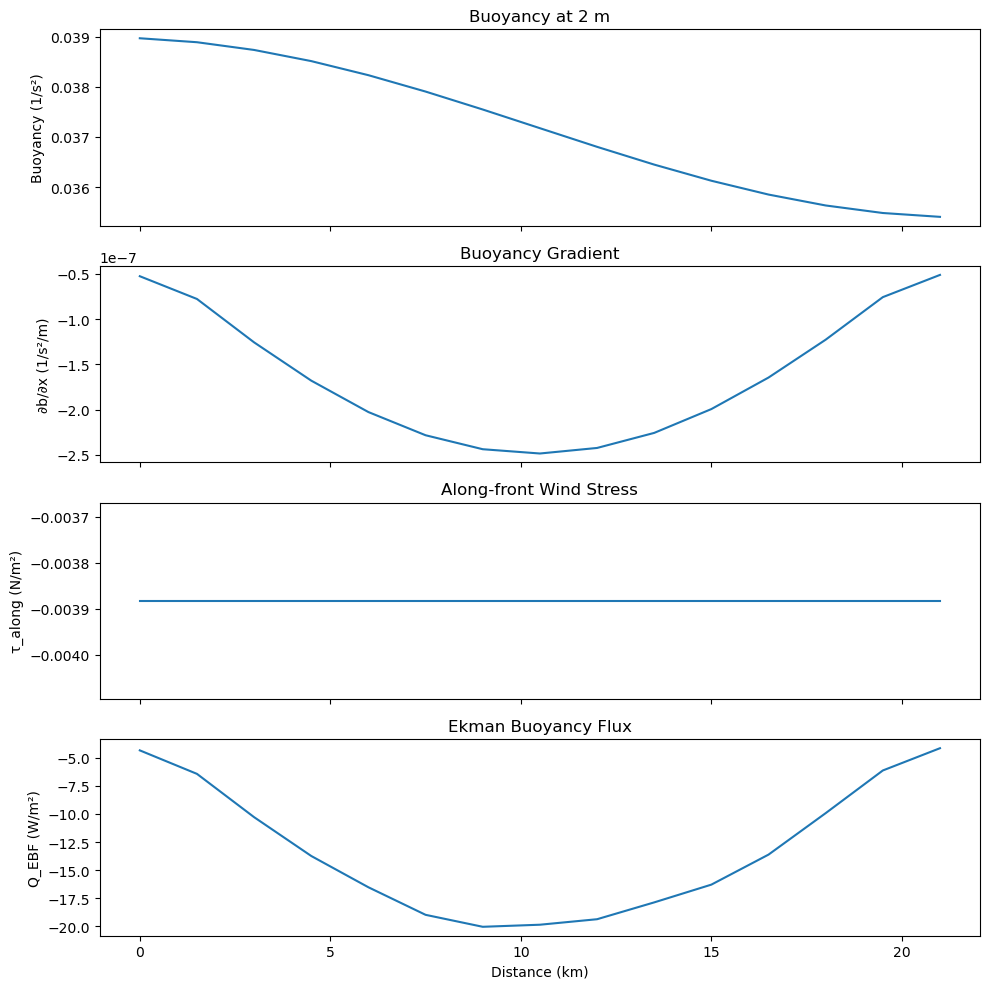

In [150]:
# --- Load and process CTD files ---

# --- Load CTD data files into memory ---
from pathlib import Path

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')
ctd_casts = process_ctd_casts(folder_path)

# [Functions unchanged...]

# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# Step 1: Generate interpolation grids for buoyancy, SA, and CT
from pyproj import Geod

dx = 1500  # increase interpolation step to reduce oversmoothing and match station spacing

def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=40):
    from scipy.interpolate import interp1d
    from scipy.ndimage import gaussian_filter1d

    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)  # 1 m vertical resolution

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)

    # Vertical interpolation for CTD_09 (index 4)
    z_index_2m = np.argmin(np.abs(z_reg - 2))
    if np.isnan(b_profiles[4, z_index_2m]):
        profile = b_profiles[4, :]
        if np.sum(~np.isnan(profile)) > 1:
            z_vals = z_reg[~np.isnan(profile)]
            b_vals = profile[~np.isnan(profile)]
            b_interp = interp1d(z_vals, b_vals, bounds_error=False, fill_value=np.nan)
            b_profiles[4, z_index_2m] = b_interp(z_reg[z_index_2m])

    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    b_2m = b_grid[np.argmin(np.abs(z_reg - 2))]

    # Interpolate to fill NaNs before smoothing
    mask = ~np.isnan(b_2m)
    b_2m_interp = np.interp(np.arange(len(b_2m)), np.flatnonzero(mask), b_2m[mask])
    b_2m_smooth = gaussian_filter1d(b_2m_interp, sigma=8)
    dbdx = np.gradient(b_2m_smooth, dx)

    return d_reg, b_2m_smooth, dbdx, z_reg, b_grid

dist_grid, b_smooth_2m, dbdx, depth_grid, b_grid = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# Step 2: Compute distances from CTD casts
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

# Step 3: Interpolate SA and CT
from scipy.interpolate import interp1d

for idx in [4]:  # Apply vertical interpolation to CTD_09
    for var in ['SA', 'CT']:
        profile = ctd_casts[idx][var]
        p = ctd_casts[idx]['p']
        z = gsw.z_from_p(p, ctd_casts[idx]['lat']) * -1
        if np.sum(~np.isnan(profile)) > 1:
            z_valid = z[~np.isnan(profile)]
            profile_valid = profile[~np.isnan(profile)]
            interp_fn = interp1d(z_valid, profile_valid, bounds_error=False, fill_value=np.nan)
            profile_interp = interp_fn(z)
            ctd_casts[idx][var] = profile_interp

SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

# Step 4: Extract SA and CT at 2m
SA_i = SA_grid[np.argmin(np.abs(depth_grid - 2)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 2)), :]

# Clean up current_dir_rad: fill missing values
if df_env['current_dir_rad'].isna().any():
    df_env['current_dir_rad'].fillna(method='ffill', inplace=True)
    df_env['current_dir_rad'].fillna(method='bfill', inplace=True)

# Step 5: Filter valid indices
valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_2m) & ~np.isnan(dbdx)

dist_grid_clean = dist_grid[valid_mask]
SA_i_clean = SA_i[valid_mask]
CT_i_clean = CT_i[valid_mask]
b_smooth_clean = b_smooth_2m[valid_mask]
dbdx_clean = dbdx[valid_mask]

# Compute Q_EBF
df_ctd = compute_Q_EBF_ctd(
    dist_grid_clean,
    SA_i_clean,
    CT_i_clean,
    b_smooth_clean,
    dbdx_clean,
    wind_speed=df_env['wind_speed'].iloc[0],
    wind_dir_rad=df_env['wind_dir_rad'].iloc[0],
    current_dir_rad=df_env['current_dir_rad'].iloc[0]
)

# Step 6: Plot b, dbdx, tau_along, and Q_EBF
import matplotlib.pyplot as plt

fig, axs = plt.subplots(4, 1, figsize=(10, 10), sharex=True)

axs[0].plot(dist_grid_clean / 1000, df_ctd['b_2m'])
axs[0].set_ylabel('Buoyancy (1/s²)')
axs[0].set_title('Buoyancy at 2 m')

axs[1].plot(dist_grid_clean / 1000, df_ctd['dbdx'])
axs[1].set_ylabel('∂b/∂x (1/s²/m)')
axs[1].set_title('Buoyancy Gradient')

axs[2].plot(dist_grid_clean / 1000, df_ctd['tau_along'])
axs[2].set_ylabel('τ_along (N/m²)')
axs[2].set_title('Along-front Wind Stress')

axs[3].plot(dist_grid_clean / 1000, df_ctd['Q_EBF'])
axs[3].set_ylabel('Q_EBF (W/m²)')
axs[3].set_title('Ekman Buoyancy Flux')
axs[3].set_xlabel('Distance (km)')

plt.tight_layout()
plt.show()


# Pipeline 2 CTD with changed interpolation

In [ ]:

# --- Load and process CTD files ---

# --- Load CTD data files into memory ---
from pathlib import Path

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')

def load_cnv(filepath):
    def dms_to_decimal(degrees, minutes, direction):
        decimal = float(degrees) + float(minutes) / 60
        if direction.upper() in ['S', 'W']:
            decimal *= -1
        return decimal

    with open(filepath, 'r', encoding='latin1') as f:
        lines = f.readlines()

    data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
    df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
    df.columns = [f'col_{i}' for i in range(df.shape[1])]

    lat = lon = None
    time_local = None
    for line in lines:
        if 'latitude' in line.lower():
            parts = line.split()
            try:
                lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'longitude' in line.lower():
            parts = line.split()
            try:
                lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'start time' in line.lower():
            try:
                time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
            except:
                continue

    time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
    return df, lat, lon, time_utc


def process_ctd_casts(folder_path):
    filenames = [
        'CTD_05_avg.cnv', 'CTD_06_avg.cnv', 'CTD_07_avg.cnv', 'CTD_08_avg.cnv',
        'CTD_09_avg.cnv', 'CTD_10_avg.cnv', 'CTD_11_avg.cnv', 'CTD_12_avg.cnv',
        'CTD_13_avg.cnv', 'CTD_14_avg.cnv', 'CTD_15_avg.cnv', 'CTD_16_avg.cnv'
    ]
    cast_data = []
    for file in filenames:
        full_path = Path(folder_path) / file
        df, lat, lon, time_utc = load_cnv(full_path)

        SP = df['col_9'].to_numpy()
        T = df['col_2'].to_numpy()
        p = df['col_1'].to_numpy()

        SA = gsw.SA_from_SP(SP, p, lon, lat)
        CT = gsw.CT_from_t(SA, T, p)
        rho = gsw.rho(SA, CT, p=0)

        cast_data.append({
            'time': time_utc,
            'lat': lat,
            'lon': lon,
            'SA': SA,
            'CT': CT,
            'p': p,
            'rho': rho
        })
    return cast_data

ctd_casts = process_ctd_casts(folder_path)

# [Functions unchanged...]
# --- Load Wind and ADCP data ---
def load_wind_adcp(wind_file, adcp_file):
    df_wind = pd.read_csv(wind_file)
    df_wind['datetime'] = pd.to_datetime(df_wind['ts'])
    wind_speed = df_wind['windspeed'].to_numpy()
    wind_dir_rad = np.deg2rad((df_wind['winddir'] + 180) % 360)

    adcp = pd.read_csv(adcp_file, sep="\t", skiprows=12, engine="python").iloc[3:-3].reset_index(drop=True)
    adcp = adcp.map(lambda x: str(x).replace(",", "."))

    def parse_int(x):
        try:
            return int(float(x))
        except:
            return 0

    ymdhms = adcp[['YR', 'MO', 'DA', 'HH', 'MM', 'SS']].apply(lambda col: col.map(parse_int)).to_numpy()
    adcp_time = [dt.datetime(2000 + y, m, d, hh, mm, ss) for y, m, d, hh, mm, ss in ymdhms]
    adcp_time = [pytz.timezone('Europe/Stockholm').localize(t).astimezone(pytz.utc).replace(tzinfo=None) for t in adcp_time]

    u = adcp[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
    v = adcp[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
    theta_current = np.arctan2(v, u)

    df_adcp = pd.DataFrame({
        'datetime': adcp_time,
        'theta_current': theta_current
    })

    df_interp = pd.DataFrame({
        'datetime': df_wind['datetime'],
        'wind_speed': np.interp(df_wind['datetime'].astype(np.int64), df_wind['datetime'].astype(np.int64), wind_speed),
        'wind_dir_rad': np.interp(df_wind['datetime'].astype(np.int64), df_wind['datetime'].astype(np.int64), wind_dir_rad),
        'current_dir_rad': np.interp(df_wind['datetime'].astype(np.int64), df_adcp['datetime'].astype(np.int64), df_adcp['theta_current'])
    })
    return df_interp


# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# --- Load wind and ADCP data ---
wind_file = folder_path / 'sk_weather.csv'
adcp_file = folder_path / 'adcp0507_postpro20may.txt'
df_env = load_wind_adcp(wind_file, adcp_file)


# --- Interpolate buoyancy onto regular grid ---
def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=40):
    from scipy.interpolate import interp1d
    from scipy.ndimage import gaussian_filter1d

    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)  # 1 m vertical resolution

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)
    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    b_2m = b_grid[np.argmin(np.abs(z_reg - 2))]
    b_2m_smooth = gaussian_filter1d(b_2m, sigma=2)
    dbdx = np.gradient(b_2m_smooth, dx)

    return d_reg, b_2m_smooth, dbdx, z_reg, b_grid


# # --- Compute Ekman Buoyancy Flux using updated interpolation ---
# def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
#     # Constants
#     g = 9.81
#     Cp = 4000  # J/kg/K
#     rho_air = 1.2  # kg/m^3
#     Cd = 1.5e-3  # drag coefficient
#     f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))

#     # Wind stress and along-front component
#     tau = Cd * rho_air * wind_speed ** 2
#     delta_theta = wind_dir_rad - current_dir_rad
#     tau_along = tau * np.cos(delta_theta)

#     # Thermal expansion coefficient (assume at 2m depth)
#     alpha = gsw.alpha(SA_i, CT_i, 0)

#     # Ekman buoyancy flux (converted to heat flux units)
#     Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

#     return pd.DataFrame({
#         'distance_m': dist_grid,
#         'Q_EBF': Q_EBF,
#         'b_2m': b_smooth,
#         'dbdx': dbdx,
#         'tau_along': tau_along
#     })



def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
    # Constants
    g = 9.81
    Cp = 4000  # J/kg/K
    rho_air = 1.2  # kg/m^3
    Cd = 1.5e-3  # drag coefficient
    f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))

    # Wind stress and along-front component
    tau = Cd * rho_air * wind_speed ** 2
    delta_theta = wind_dir_rad - current_dir_rad
    tau_along = tau * np.cos(delta_theta)

    # Thermal expansion coefficient (assume at 2m depth)
    alpha = gsw.alpha(SA_i, CT_i, 0)

    # Print α and f for inspection
    print("Mean α (thermal expansion coefficient):", np.nanmean(alpha))
    print("Coriolis parameter f:", f)

    # Ekman buoyancy flux (converted to heat flux units)
    Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

    return pd.DataFrame({
        'distance_m': dist_grid,
        'Q_EBF': Q_EBF,
        'b_2m': b_smooth,
        'dbdx': dbdx,
        'tau_along': tau_along
    })


# --- Interpolate SA and CT onto regular grid ---
def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
    from scipy.interpolate import griddata

    sa_points = []
    ct_points = []
    sa_values = []
    ct_values = []

    for i, cast in enumerate(cast_data):
        p = cast['p']
        SA = cast['SA']
        CT = cast['CT']
        z = gsw.z_from_p(p, cast['lat']) * -1  # convert to depth in meters
        mask = (z >= 0) & (z <= np.max(depth_grid))
        z = z[mask]
        SA = SA[mask]
        CT = CT[mask]

        for zi, sai, cti in zip(z, SA, CT):
            sa_points.append([distances[i], zi])
            ct_points.append([distances[i], zi])
            sa_values.append(sai)
            ct_values.append(cti)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
    CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')

    return SA_grid, CT_grid



# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# Step 1: Generate interpolation grids for buoyancy, SA, and CT
# from pyproj import Geod

# dx = 150  # increase interpolation step to reduce oversmoothing and match station spacing

# dist_grid, b_smooth_2m, dbdx, depth_grid, b_grid = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# # Step 2: Compute distances from CTD casts
# geod = Geod(ellps="WGS84")
# distances = [0]
# for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
#     _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
#     distances.append(distances[-1] + dist)
# # Print distance of CTD_09 (index 4) in kilometers
# print(f"CTD_09 is located at {distances[4] / 1000:.2f} km along the transect.")


# # Step 3: Interpolate SA and CT
# SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

# # Step 4: Extract SA and CT at 2m
# SA_i = SA_grid[np.argmin(np.abs(depth_grid - 2)), :]
# CT_i = CT_grid[np.argmin(np.abs(depth_grid - 2)), :]

# # Step 5: Compute Q_EBF
# df_ctd = compute_Q_EBF_ctd(
#     dist_grid, SA_i, CT_i, b_smooth_2m, dbdx,
#     wind_speed=df_env['wind_speed'].iloc[0],
#     wind_dir_rad=df_env['wind_dir_rad'].iloc[0],
#     current_dir_rad=df_env['current_dir_rad'].iloc[0]
# )

# --- Full pipeline: interpolation, EBF calculation, and visualization ---
# Step 1: Generate interpolation grids for buoyancy, SA, and CT
from pyproj import Geod

dx = 1500  # increase interpolation step to reduce oversmoothing and match station spacing

def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=40):
    from scipy.interpolate import interp1d
    from scipy.ndimage import gaussian_filter1d

    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)  # 1 m vertical resolution

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)

    # Vertical interpolation for CTD_09 (index 4)
    z_index_2m = np.argmin(np.abs(z_reg - 2))
    if np.isnan(b_profiles[4, z_index_2m]):
        profile = b_profiles[4, :]
        if np.sum(~np.isnan(profile)) > 1:
            z_vals = z_reg[~np.isnan(profile)]
            b_vals = profile[~np.isnan(profile)]
            b_interp = interp1d(z_vals, b_vals, bounds_error=False, fill_value=np.nan)
            b_profiles[4, z_index_2m] = b_interp(z_reg[z_index_2m])

    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    b_2m = b_grid[np.argmin(np.abs(z_reg - 5))]

    # Interpolate to fill NaNs before smoothing
    mask = ~np.isnan(b_2m)
    b_2m_interp = np.interp(np.arange(len(b_2m)), np.flatnonzero(mask), b_2m[mask])
    b_2m_smooth = gaussian_filter1d(b_2m_interp, sigma=8)
    dbdx = np.gradient(b_2m_smooth, dx)

    return d_reg, b_2m_smooth, dbdx, z_reg, b_grid

dist_grid, b_smooth_2m, dbdx, depth_grid, b_grid = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# Step 2: Compute distances from CTD casts
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

# Step 3: Interpolate SA and CT
from scipy.interpolate import interp1d

for idx in [4]:  # Apply vertical interpolation to CTD_09
    for var in ['SA', 'CT']:
        profile = ctd_casts[idx][var]
        p = ctd_casts[idx]['p']
        z = gsw.z_from_p(p, ctd_casts[idx]['lat']) * -1
        if np.sum(~np.isnan(profile)) > 1:
            z_valid = z[~np.isnan(profile)]
            profile_valid = profile[~np.isnan(profile)]
            interp_fn = interp1d(z_valid, profile_valid, bounds_error=False, fill_value=np.nan)
            profile_interp = interp_fn(z)
            ctd_casts[idx][var] = profile_interp

SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

# Step 4: Extract SA and CT at 5m (changed from 2 but no renaming)
SA_i = SA_grid[np.argmin(np.abs(depth_grid - 5)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 5)), :]

# Clean up current_dir_rad: fill missing values
if df_env['current_dir_rad'].isna().any():
    df_env['current_dir_rad'].fillna(method='ffill', inplace=True)
    df_env['current_dir_rad'].fillna(method='bfill', inplace=True)

# Step 5: Filter valid indices
valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_2m) & ~np.isnan(dbdx)

dist_grid_clean = dist_grid[valid_mask]
SA_i_clean = SA_i[valid_mask]
CT_i_clean = CT_i[valid_mask]
b_smooth_clean = b_smooth_2m[valid_mask]
dbdx_clean = dbdx[valid_mask]

# Compute Q_EBF
df_ctd = compute_Q_EBF_ctd(
    dist_grid_clean,
    SA_i_clean,
    CT_i_clean,
    b_smooth_clean,
    dbdx_clean,
    wind_speed=df_env['wind_speed'].iloc[0],
    wind_dir_rad=df_env['wind_dir_rad'].iloc[0],
    current_dir_rad=df_env['current_dir_rad'].iloc[0]
)

Mean α (thermal expansion coefficient): 0.00015547929695846106
Coriolis parameter f: 0.00012231339297029653


C:\Users\Sussi\AppData\Local\Temp\ipykernel_16368\1772018493.py:379: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_env['current_dir_rad'].fillna(method='ffill', inplace=True)
C:\Users\Sussi\AppData\Local\Temp\ipykernel_16368\1772018493.py:380: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_env['current_dir_rad'].fillna(method='bfill', inplace=True)


C:\Users\Sussi\AppData\Local\Temp\ipykernel_16368\3310053980.py:94: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


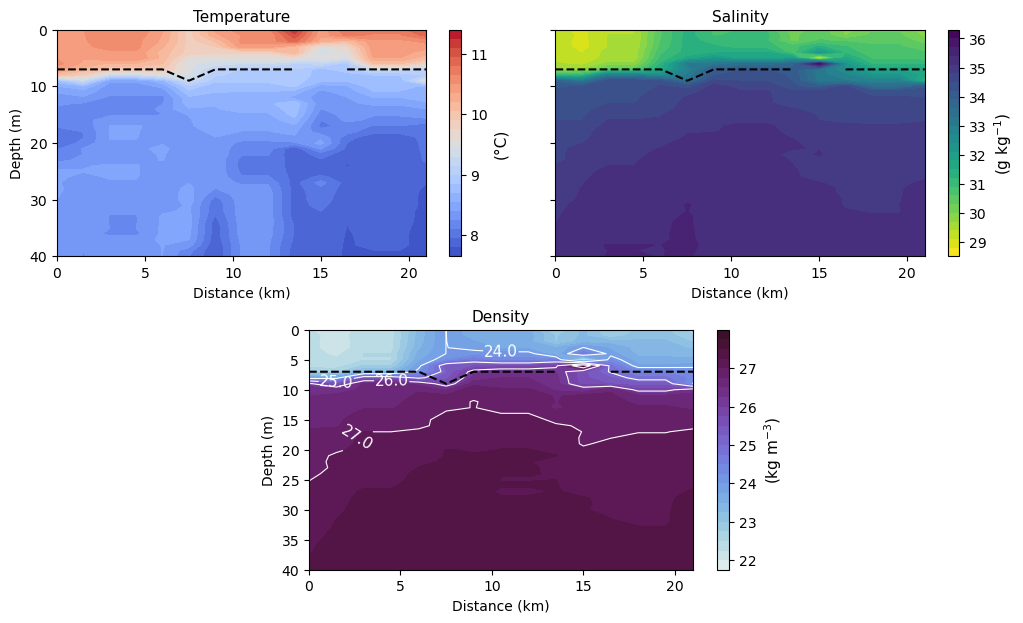

In [80]:
# Update Mixed Layer Depth (MLD) computation to be computed for each vertical profile in the interpolated grid

from scipy.interpolate import UnivariateSpline

def compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=7, delta_sigma=0.03):
    ref_index = np.argmin(np.abs(depth_grid - ref_depth))
    ref_density = sigma0_grid[ref_index, :]

    mld_array = np.full(sigma0_grid.shape[1], np.nan)
    for i in range(sigma0_grid.shape[1]):
        profile = sigma0_grid[:, i]
        if np.all(np.isnan(profile)) or np.isnan(ref_density[i]):
            continue

        delta = profile - ref_density[i]
        try:
            spline = UnivariateSpline(depth_grid, delta - delta_sigma, s=0)
            roots = spline.roots()
            if roots.size > 0:
                mld_array[i] = roots[0]
        except:
            continue
    return mld_array

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute mixed layer depth across interpolated grid using dynamic spline method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid)

# Interpolate MLD to match dist_grid
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
mld_interp = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])

# --- Plotting ---
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cmocean as cmo

fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], hspace=0.25, wspace=0.08, left=0.1, right=0.9, top=0.95, bottom=0.1)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_axes([0.31, 0.05, 0.4, 0.4])

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=11)
ax_temp.set_xlabel('Distance (km)')
ax_temp.set_ylabel('Depth (m)')
ax_temp.set_ylim(40, 0)
ax_temp.set_yticks(np.arange(0, 41, 10))
cb1 = plt.colorbar(cs1, ax=ax_temp, ticks=np.arange(int(np.nanmin(CT_grid)), int(np.nanmax(CT_grid)) + 1))
cb1.set_label('(°C)', fontsize=11)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=11)
ax_sali.set_xlabel('Distance (km)')
ax_sali.set_ylim(40, 0)
ax_sali.tick_params(axis='y', labelleft=False)
ax_sali.set_yticks(np.arange(0, 41, 10))
cb2 = plt.colorbar(cs2, ax=ax_sali, ticks=np.arange(int(np.nanmin(SA_grid)), int(np.nanmax(SA_grid)) + 1))
cb2.set_label(r'(g kg$^{-1}$)', fontsize=11)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=11, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=11)
ax_dens.set_xlabel('Distance (km)')
ax_dens.set_ylabel('Depth (m)')
ax_dens.set_ylim(40, 0)
ax_dens.set_xticks(np.arange(0, 21, 5))
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=11)

# Overlay MLD
ax_temp.plot(dist_grid / 1000, mld, 'k--', label='MLD')
#ax_temp.legend()
ax_sali.plot(dist_grid / 1000, mld, 'k--', label='MLD')
#ax_sali.legend()
ax_dens.plot(dist_grid / 1000, mld, 'k--', label='MLD')
#ax_dens.legend()

plt.tight_layout()
plt.show()

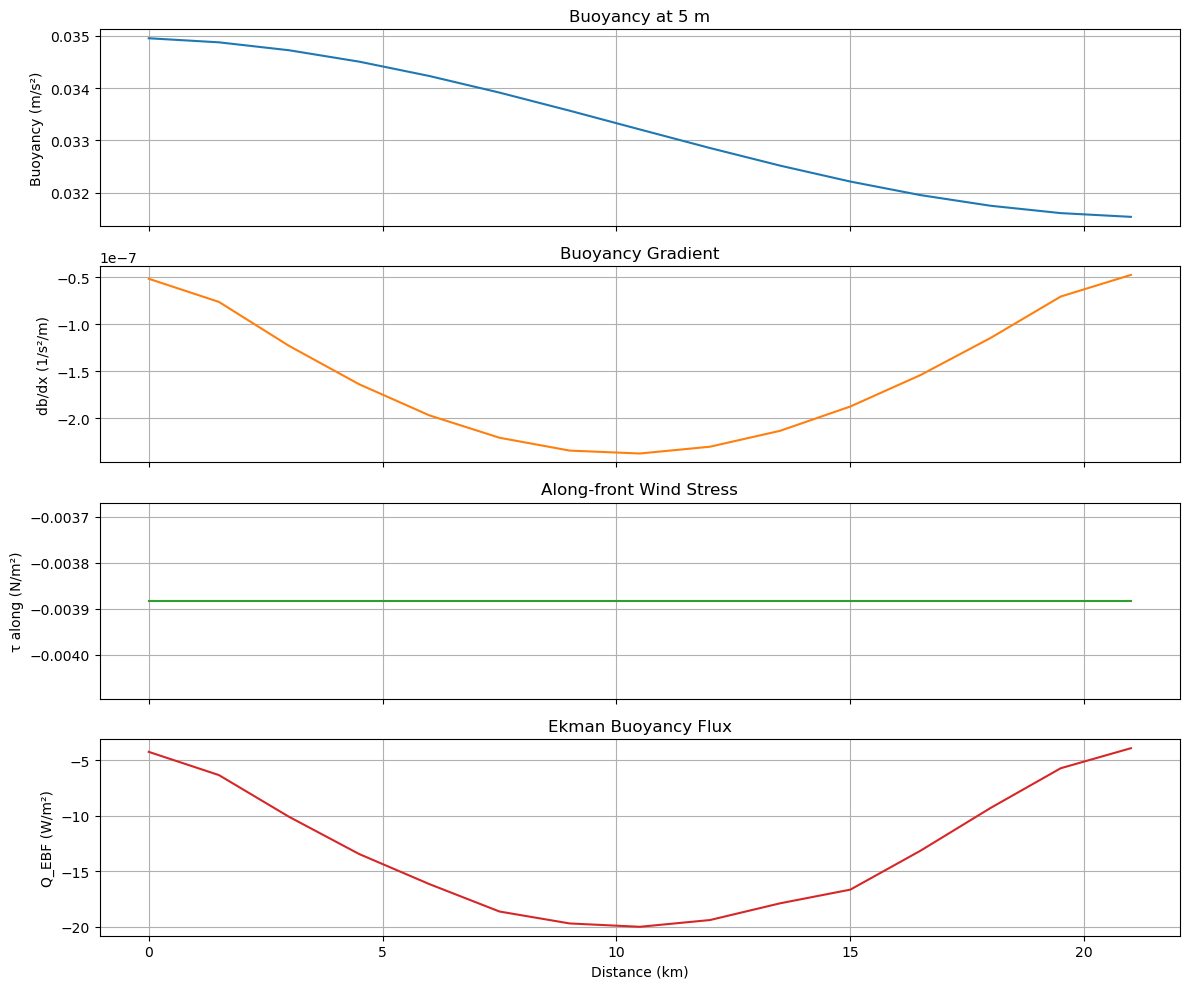

In [83]:
fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

# Plot Buoyancy at 5 m
axs[0].plot(dist_grid_clean / 1000, b_smooth_clean, label='Buoyancy (2m)')

axs[0].set_ylabel('Buoyancy (m/s²)')
axs[0].set_title('Buoyancy at 5 m')
axs[0].grid(True)

# Plot Gradient db/dx
axs[1].plot(dist_grid_clean / 1000, dbdx_clean, label='db/dx', color='tab:orange')
axs[1].set_ylabel('db/dx (1/s²/m)')
axs[1].set_title('Buoyancy Gradient')
axs[1].grid(True)

# Plot Tau Along
axs[2].plot(dist_grid_clean / 1000, df_ctd['tau_along'], label='Tau Along', color='tab:green')
axs[2].set_ylabel('τ along (N/m²)')
axs[2].set_title('Along-front Wind Stress')
axs[2].grid(True)

# Plot Q_EBF
axs[3].plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], label='Q_EBF', color='tab:red')
axs[3].set_ylabel('Q_EBF (W/m²)')
axs[3].set_xlabel('Distance (km)')
axs[3].set_title('Ekman Buoyancy Flux')
axs[3].grid(True)

plt.tight_layout()
plt.show()

C:\Users\Sussi\AppData\Local\Temp\ipykernel_16368\1341295565.py:87: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


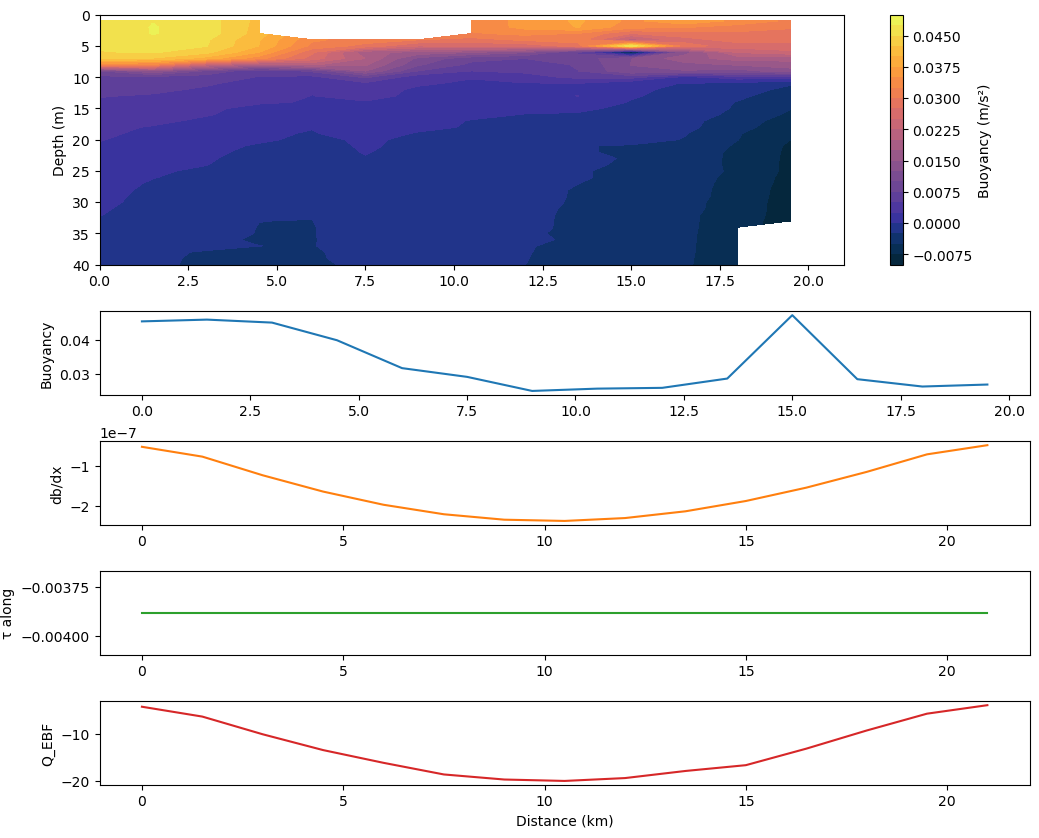

In [92]:
# Update Mixed Layer Depth (MLD) computation to be computed for each vertical profile in the interpolated grid

from scipy.interpolate import UnivariateSpline

def compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=10, delta_sigma=0.03):
    ref_index = np.argmin(np.abs(depth_grid - ref_depth))
    ref_density = sigma0_grid[ref_index, :]

    mld_array = np.full(sigma0_grid.shape[1], np.nan)
    for i in range(sigma0_grid.shape[1]):
        profile = sigma0_grid[:, i]
        if np.all(np.isnan(profile)) or np.isnan(ref_density[i]):
            continue

        delta = profile - ref_density[i]
        try:
            spline = UnivariateSpline(depth_grid, delta - delta_sigma, s=0)
            roots = spline.roots()
            if roots.size > 0:
                mld_array[i] = roots[0]
        except:
            continue
    return mld_array

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute mixed layer depth across interpolated grid using dynamic spline method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid)

# Interpolate MLD to match dist_grid
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
mld_interp = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])

# --- Extract buoyancy at 5 meters ---
b_5m = b_grid[np.argmin(np.abs(depth_grid - 5)), :]

# --- Plotting ---
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import cmocean as cmo

fig = plt.figure(figsize=(12, 10))
gs = gridspec.GridSpec(5, 1, height_ratios=[3, 1, 1, 1, 1], hspace=0.4)

# Full vertical buoyancy profile
ax0 = fig.add_subplot(gs[0])
bf = ax0.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb = fig.colorbar(bf, ax=ax0, orientation='vertical')
cb.set_label('Buoyancy (m/s²)')
#ax0.set_title('Vertical Buoyancy Profile')
ax0.set_ylabel('Depth (m)')
ax0.set_ylim(40, 0)


# Buoyancy at 5 m
ax1 = fig.add_subplot(gs[1])
ax1.plot(dist_grid / 1000, b_5m, label='Buoyancy (5m)')
ax1.set_ylabel('Buoyancy')
#ax1.set_title('Buoyancy at 5 m')


# Gradient db/dx
ax2 = fig.add_subplot(gs[2])
ax2.plot(dist_grid_clean / 1000, dbdx_clean, label='db/dx', color='tab:orange')
ax2.set_ylabel('db/dx')
#ax2.set_title('Buoyancy Gradient')


# Tau Along
ax3 = fig.add_subplot(gs[3])
ax3.plot(dist_grid_clean / 1000, df_ctd['tau_along'], label='Tau Along', color='tab:green')
ax3.set_ylabel('τ along')
#ax3.set_title('Along-front Wind Stress')


# Q_EBF
ax4 = fig.add_subplot(gs[4])
ax4.plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], label='Q_EBF', color='tab:red')
ax4.set_ylabel('Q_EBF')
ax4.set_xlabel('Distance (km)')
#ax4.set_title('Ekman Buoyancy Flux')


plt.tight_layout()
plt.show()

# Working pipeline, use this 30/5

Found NMEA time line: * NMEA UTC (Time) = May 07 2025 08:44:53
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:15:41
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:38:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:06:26
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:44:48
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:11:29
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:30:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:52:13
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:13:01
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:38:22
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:57:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 13:17:45


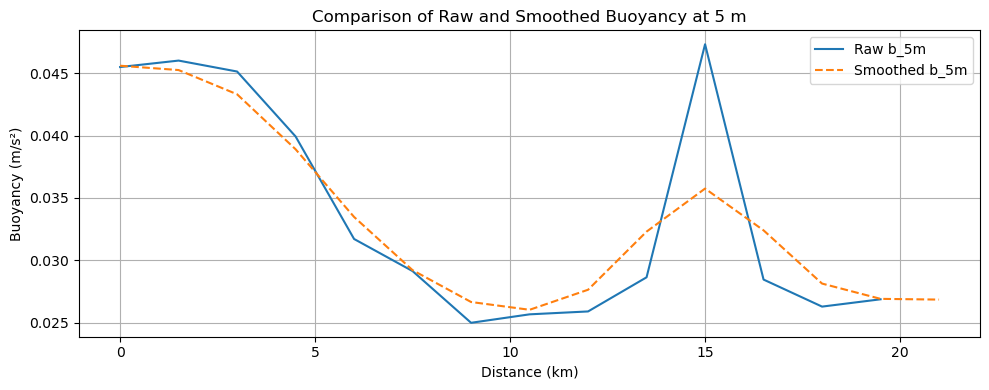

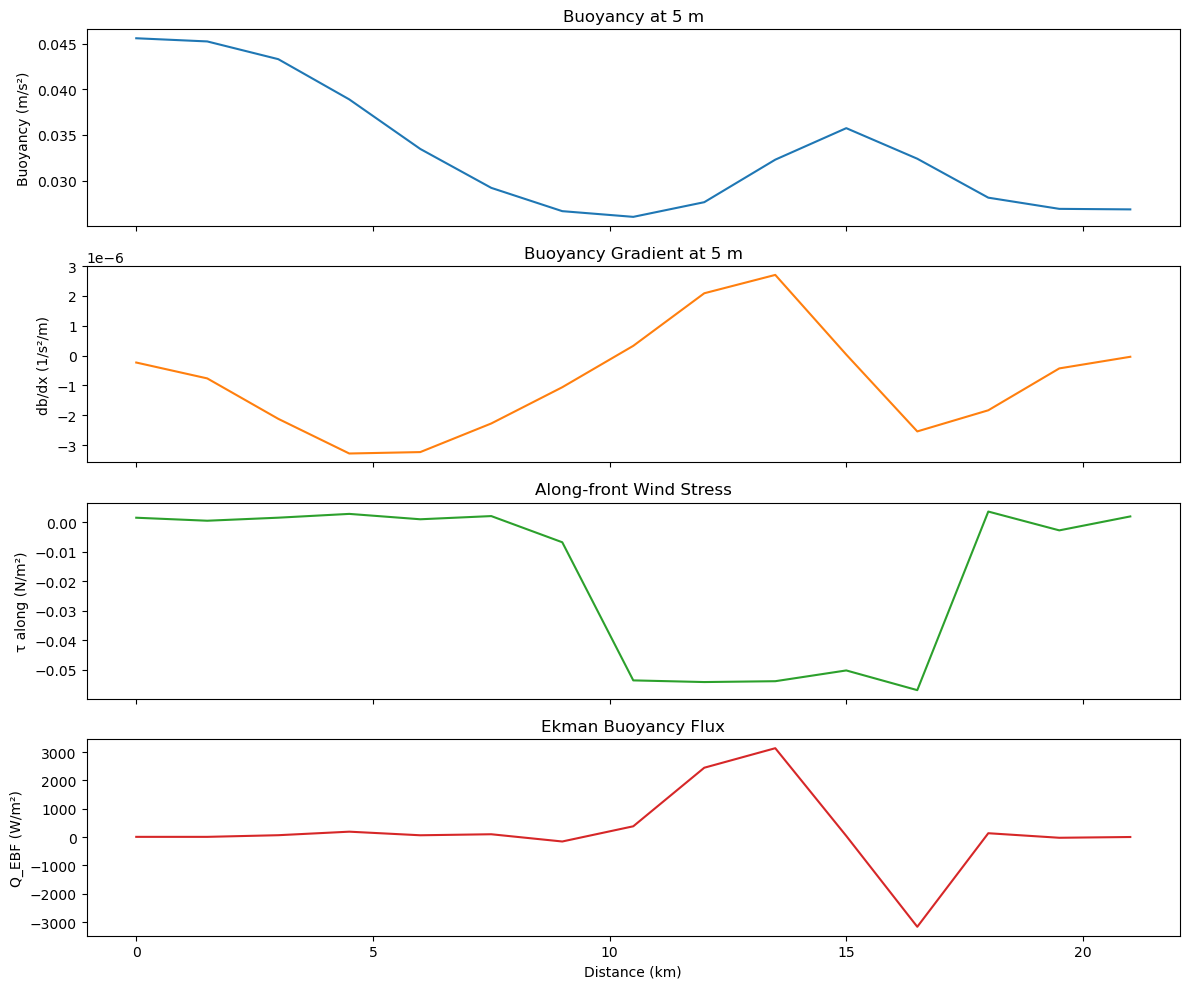

In [51]:
# --- Load and process CTD files ---

from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt
import pytz
import gsw
from pyproj import Geod
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean as cmo

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')


def load_cnv(filepath):
    def dms_to_decimal(degrees, minutes, direction):
        decimal = float(degrees) + float(minutes) / 60
        if direction.upper() in ['S', 'W']:
            decimal *= -1
        return decimal

    with open(filepath, 'r', encoding='latin1') as f:
        lines = f.readlines()

    data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
    df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
    df.columns = [f'col_{i}' for i in range(df.shape[1])]

    lat = lon = None
    time_local = None
    for line in lines:
        if 'latitude' in line.lower():
            parts = line.split()
            try:
                lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'longitude' in line.lower():
            parts = line.split()
            try:
                lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'nmea utc' in line.lower():
            print(f"Found NMEA time line: {line.strip()}")
            try:
                time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
            except Exception as e:
                print(f"Failed to parse time from line: {line.strip()} → {e}")
                continue

    time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
    return df, lat, lon, time_utc


def process_ctd_casts(folder_path):
    filenames = [
        'CTD_05_avg.cnv', 'CTD_06_avg.cnv', 'CTD_07_avg.cnv', 'CTD_08_avg.cnv',
        'CTD_09_avg.cnv', 'CTD_10_avg.cnv', 'CTD_11_avg.cnv', 'CTD_12_avg.cnv',
        'CTD_13_avg.cnv', 'CTD_14_avg.cnv', 'CTD_15_avg.cnv', 'CTD_16_avg.cnv'
    ]
    cast_data = []
    for file in filenames:
        full_path = Path(folder_path) / file
        df, lat, lon, time_utc = load_cnv(full_path)

        SP = df['col_9'].to_numpy()
        T = df['col_2'].to_numpy()
        p = df['col_1'].to_numpy()

        SA = gsw.SA_from_SP(SP, p, lon, lat)
        CT = gsw.CT_from_t(SA, T, p)
        rho = gsw.rho(SA, CT, p=0)

        cast_data.append({
            'time': time_utc + dt.timedelta(hours=2) if time_utc is not None else None,
            'lat': lat,
            'lon': lon,
            'SA': SA,
            'CT': CT,
            'p': p,
            'rho': rho
        })
    return cast_data


ctd_casts = process_ctd_casts(folder_path)


# --- Interpolate buoyancy onto regular grid ---
def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=20):
    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)
    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    
    b_5m = b_grid[np.argmin(np.abs(z_reg - 5))]
    mask = ~np.isnan(b_5m)
    b_5m_interp = np.interp(np.arange(len(b_5m)), np.flatnonzero(mask), b_5m[mask])
    b_5m_smooth = gaussian_filter1d(b_5m_interp, sigma=1)
    dbdx = np.gradient(b_5m_smooth, dx)

    b_smooth_5m = b_5m_smooth  # expose for debugging plot
    return d_reg, b_5m_smooth, dbdx, z_reg, b_grid, b_5m


dist_grid, b_smooth_5m, dbdx, depth_grid, b_grid, b_5m = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# Compute distances for each cast
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

# Interpolation of SA and CT
from scipy.interpolate import griddata

def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
    sa_points, sa_values = [], []
    ct_points, ct_values = [], []

    for i, cast in enumerate(cast_data):
        p = cast['p']
        SA = cast['SA']
        CT = cast['CT']
        z = gsw.z_from_p(p, cast['lat']) * -1
        mask = (z >= 0) & (z <= np.max(depth_grid))
        z = z[mask]
        SA = SA[mask]
        CT = CT[mask]
        for zi, sai, cti in zip(z, SA, CT):
            sa_points.append([distances[i], zi])
            sa_values.append(sai)
            ct_points.append([distances[i], zi])
            ct_values.append(cti)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
    CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')
    return SA_grid, CT_grid


SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

SA_i = SA_grid[np.argmin(np.abs(depth_grid - 5)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 5)), :]

# Interpolate environmental data to CTD transect times
df_env = pd.read_csv(folder_path / 'sk_weather.csv')
df_env['datetime'] = pd.to_datetime(df_env['ts'])
df_env['wind_dir_rad'] = np.deg2rad((df_env['winddir'] + 180) % 360)

valid_time_mask = [cast['time'] is not None for cast in ctd_casts]

# Log CTD casts with missing time for diagnostics
for i, valid in enumerate(valid_time_mask):
    if not valid:
        print(f"Warning: CTD cast at index {i} has no valid timestamp.")
valid_ctd_times = [cast['time'] for i, cast in enumerate(ctd_casts) if valid_time_mask[i]]
valid_distances = [dist for i, dist in enumerate(distances) if valid_time_mask[i]]

time_interp = np.interp(dist_grid, valid_distances, [t.timestamp() for t in valid_ctd_times])
times_dt = [dt.datetime.utcfromtimestamp(t) for t in time_interp]

df_env['ts_numeric'] = df_env['datetime'].astype(np.int64) / 1e9
wind_speed = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['windspeed'])
wind_dir_rad = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['wind_dir_rad'])
current_dir_rad = np.full_like(wind_speed, np.deg2rad(90))  # Placeholder or interpolate real current data if available

valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_5m) & ~np.isnan(dbdx)

dist_grid_clean = dist_grid[valid_mask]
SA_i_clean = SA_i[valid_mask]
CT_i_clean = CT_i[valid_mask]
b_smooth_clean = b_smooth_5m[valid_mask]
dbdx_clean = dbdx[valid_mask]
wind_speed = wind_speed[valid_mask]
wind_dir_rad = wind_dir_rad[valid_mask]
current_dir_rad = current_dir_rad[valid_mask]


# --- Compute Q_EBF ---
def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
    g = 9.81
    Cp = 4000
    rho_air = 1.2
    Cd = 1.5e-3
    f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
    tau = Cd * rho_air * wind_speed ** 2
    delta_theta = wind_dir_rad - current_dir_rad
    tau_along = tau * np.cos(delta_theta)
    alpha = gsw.alpha(SA_i, CT_i, 0)
    Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

    return pd.DataFrame({
        'distance_m': dist_grid,
        'Q_EBF': Q_EBF,
        'b_5m': b_smooth,
        'dbdx': dbdx,
        'tau_along': tau_along
    })


df_ctd = compute_Q_EBF_ctd(
    dist_grid_clean, SA_i_clean, CT_i_clean, b_smooth_clean, dbdx_clean,
    wind_speed, wind_dir_rad, current_dir_rad
)

# --- Plot Results ---

# --- Debug plot: Raw vs. Smoothed Buoyancy at 5 m ---
plt.figure(figsize=(10, 4))
plt.plot(dist_grid / 1000, b_5m, label='Raw b_5m')
plt.plot(dist_grid / 1000, b_smooth_5m, label='Smoothed b_5m', linestyle='--')
plt.xlabel('Distance (km)')
plt.ylabel('Buoyancy (m/s²)')
plt.title('Comparison of Raw and Smoothed Buoyancy at 5 m')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)

axs[0].plot(dist_grid_clean / 1000, b_smooth_clean)
axs[0].set_ylabel('Buoyancy (m/s²)')
axs[0].set_title('Buoyancy at 5 m')

axs[1].plot(dist_grid_clean / 1000, dbdx_clean, color='tab:orange')
axs[1].set_ylabel('db/dx (1/s²/m)')
axs[1].set_title('Buoyancy Gradient at 5 m')

axs[2].plot(dist_grid_clean / 1000, df_ctd['tau_along'], color='tab:green')
axs[2].set_ylabel('τ along (N/m²)')
axs[2].set_title('Along-front Wind Stress')

axs[3].plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], color='tab:red')
axs[3].set_ylabel('Q_EBF (W/m²)')
axs[3].set_xlabel('Distance (km)')
axs[3].set_title('Ekman Buoyancy Flux')

plt.tight_layout()
plt.show() 

C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\278857376.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


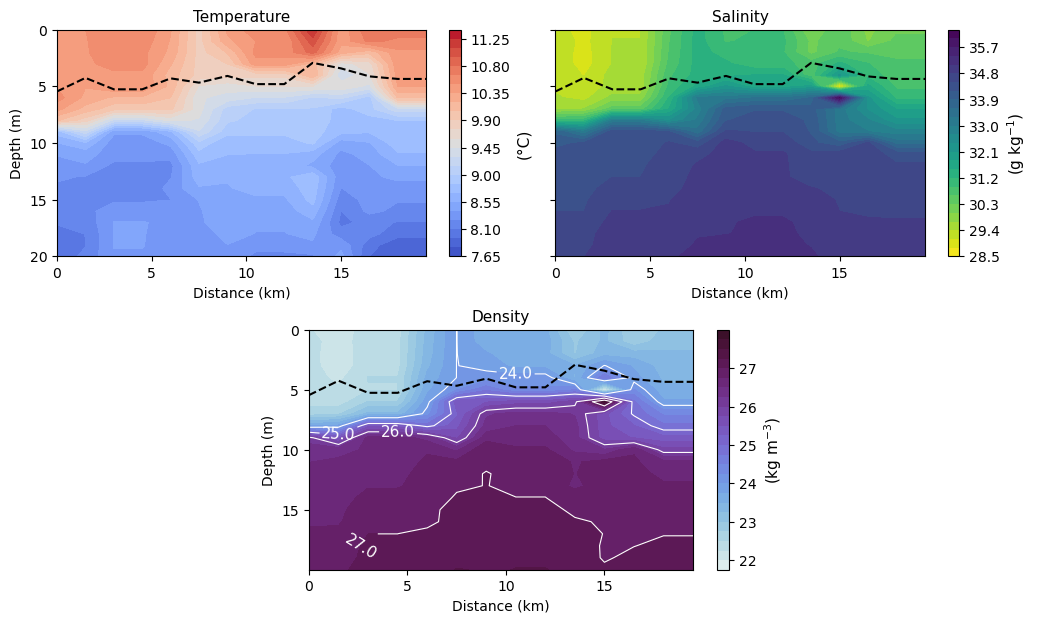

In [63]:
# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=4, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
if interp_indices.size > 0:
    mld = np.interp(dist_grid, dist_grid[interp_indices], mld_raw[mld_mask])
else:
    print("Warning: No valid MLD values found — setting MLD to NaN.")
    mld = np.full_like(dist_grid, np.nan)

# Plot temperature, salinity, and density with MLD overlay
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], hspace=0.25, wspace=0.08, left=0.1, right=0.9, top=0.95, bottom=0.1)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_axes([0.31, 0.05, 0.4, 0.4])


cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=11)
ax_temp.set_xlabel('Distance (km)')
ax_temp.set_ylabel('Depth (m)')
ax_temp.set_ylim(20, 0)
ax_temp.set_yticks(np.arange(0, 21, 5))
ax_temp.set_xlim(0, 19.5)
ax_temp.set_xticks(np.arange(0, 20, 5))
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=11)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=11)
ax_sali.set_xlabel('Distance (km)')
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.set_xticks(np.arange(0, 20, 5))
ax_sali.tick_params(axis='y', labelleft=False)
ax_sali.set_yticks(np.arange(0, 21, 5))
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=11)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=11, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=11)
ax_dens.set_xlabel('Distance (km)')
ax_dens.set_ylabel('Depth (m)')
ax_dens.set_xlim(0, 19.5)
ax_dens.set_xticks(np.arange(0, 20, 5))
ax_dens.set_ylim(20, 0)
ax_dens.set_yticks(np.arange(0, 20, 5))
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=11)

# Overlay MLD
ax_temp.plot(dist_grid / 1000, mld, 'k--', label='MLD')
ax_sali.plot(dist_grid / 1000, mld, 'k--', label='MLD')
ax_dens.plot(dist_grid / 1000, mld, 'k--', label='MLD')

plt.tight_layout()
plt.show()

C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\539789343.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


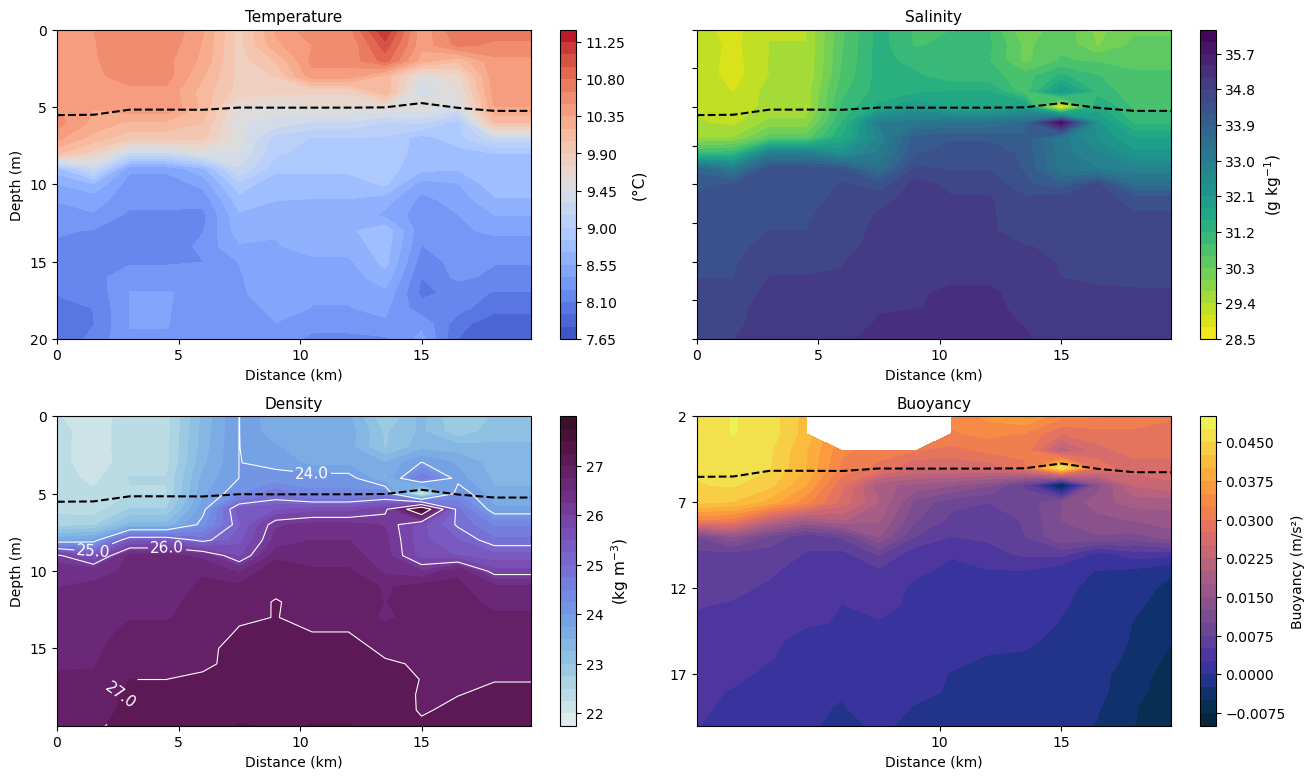

In [71]:
# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=5, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])

# Plot temperature, salinity, and density with MLD overlay
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], hspace=0.25, wspace=0.08, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=11)
ax_temp.set_xlabel('Distance (km)')
ax_temp.set_ylabel('Depth (m)')
ax_temp.set_ylim(20, 0)
ax_temp.set_yticks(np.arange(0, 21, 5))
ax_temp.set_xlim(0, 19.5)
ax_temp.set_xticks(np.arange(0, 20, 5))
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=11)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=11)
ax_sali.set_xlabel('Distance (km)')
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.set_xticks(np.arange(0, 20, 5))
ax_sali.tick_params(axis='y', labelleft=False)
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=11)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=11, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=11)
ax_dens.set_xlabel('Distance (km)')
ax_dens.set_ylabel('Depth (m)')
ax_dens.set_xlim(0, 19.5)
ax_dens.set_xticks(np.arange(0, 20, 5))
ax_dens.set_ylim(20, 0)
ax_dens.set_yticks(np.arange(0, 20, 5))
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=11)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy, orientation='vertical')
cb4.set_label('Buoyancy (m/s²)')
ax_buoy.set_title('Buoyancy', fontsize=11)
ax_buoy.set_xlabel('Distance (km)')
ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_xticks(np.arange(10, 20, 5))
ax_buoy.set_ylim(20, 5)
ax_buoy.set_yticks(np.arange(2, 20, 5))

# Overlay MLD on all subplots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

plt.tight_layout()
plt.show()

Higher res

In [83]:
# --- Load and process CTD files ---

from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt
import pytz
import gsw
from pyproj import Geod
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean as cmo

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')


def load_cnv(filepath):
    def dms_to_decimal(degrees, minutes, direction):
        decimal = float(degrees) + float(minutes) / 60
        if direction.upper() in ['S', 'W']:
            decimal *= -1
        return decimal

    with open(filepath, 'r', encoding='latin1') as f:
        lines = f.readlines()

    data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
    df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
    df.columns = [f'col_{i}' for i in range(df.shape[1])]

    lat = lon = None
    time_local = None
    for line in lines:
        if 'latitude' in line.lower():
            parts = line.split()
            try:
                lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'longitude' in line.lower():
            parts = line.split()
            try:
                lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'nmea utc' in line.lower():
            print(f"Found NMEA time line: {line.strip()}")
            try:
                time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
            except Exception as e:
                print(f"Failed to parse time from line: {line.strip()} → {e}")
                continue

    time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
    return df, lat, lon, time_utc


def process_ctd_casts(folder_path):
    filenames = [
        'CTD_05.cnv', 'CTD_06.cnv', 'CTD_07.cnv', 'CTD_08.cnv',
        'CTD_09.cnv', 'CTD_10.cnv', 'CTD_11.cnv', 'CTD_12.cnv',
        'CTD_13.cnv', 'CTD_14.cnv', 'CTD_15.cnv', 'CTD_16.cnv'
    ]
    cast_data = []
    for file in filenames:
        full_path = Path(folder_path) / file
        df, lat, lon, time_utc = load_cnv(full_path)

        SP = df['col_9'].to_numpy()
        T = df['col_2'].to_numpy()
        p = df['col_1'].to_numpy()

         # Filter out negative pressure values
        mask = (p >= 0) & (p <= 25)
        SP = SP[mask]
        T = T[mask]
        p = p[mask]

        SA = gsw.SA_from_SP(SP, p, lon, lat)
        CT = gsw.CT_from_t(SA, T, p)
        rho = gsw.sigma0(SA, CT) + 1000

        cast_data.append({
            'time': time_utc + dt.timedelta(hours=2) if time_utc is not None else None,
            'lat': lat,
            'lon': lon,
            'SA': SA,
            'CT': CT,
            'p': p,
            'rho': rho
        })
    return cast_data


ctd_casts = process_ctd_casts(folder_path)


# --- Interpolate buoyancy onto regular grid ---
def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=20):
    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)
    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    
    b_5m = b_grid[np.argmin(np.abs(z_reg - 5))]
    mask = ~np.isnan(b_5m)
    b_5m_interp = np.interp(np.arange(len(b_5m)), np.flatnonzero(mask), b_5m[mask])
    b_5m_smooth = gaussian_filter1d(b_5m_interp, sigma=1)
    dbdx = np.gradient(b_5m_smooth, dx)

    b_smooth_5m = b_5m_smooth  # expose for debugging plot
    return d_reg, b_5m_smooth, dbdx, z_reg, b_grid, b_5m


dist_grid, b_smooth_5m, dbdx, depth_grid, b_grid, b_5m = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# Compute distances for each cast
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

# Interpolation of SA and CT
from scipy.interpolate import griddata

def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
    sa_points, sa_values = [], []
    ct_points, ct_values = [], []

    for i, cast in enumerate(cast_data):
        p = cast['p']
        SA = cast['SA']
        CT = cast['CT']
        z = gsw.z_from_p(p, cast['lat']) * -1
        mask = (z >= 0) & (z <= np.max(depth_grid))
        z = z[mask]
        SA = SA[mask]
        CT = CT[mask]
        for zi, sai, cti in zip(z, SA, CT):
            sa_points.append([distances[i], zi])
            sa_values.append(sai)
            ct_points.append([distances[i], zi])
            ct_values.append(cti)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='linear')
    CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='linear')
    return SA_grid, CT_grid


SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

SA_i = SA_grid[np.argmin(np.abs(depth_grid - 5)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 5)), :]

# Interpolate environmental data to CTD transect times
df_env = pd.read_csv(folder_path / 'sk_weather.csv')
df_env['datetime'] = pd.to_datetime(df_env['ts'])
df_env['wind_dir_rad'] = np.deg2rad((df_env['winddir'] + 180) % 360)

valid_time_mask = [cast['time'] is not None for cast in ctd_casts]

# Log CTD casts with missing time for diagnostics
for i, valid in enumerate(valid_time_mask):
    if not valid:
        print(f"Warning: CTD cast at index {i} has no valid timestamp.")
valid_ctd_times = [cast['time'] for i, cast in enumerate(ctd_casts) if valid_time_mask[i]]
valid_distances = [dist for i, dist in enumerate(distances) if valid_time_mask[i]]

time_interp = np.interp(dist_grid, valid_distances, [t.timestamp() for t in valid_ctd_times])
times_dt = [dt.datetime.utcfromtimestamp(t) for t in time_interp]

df_env['ts_numeric'] = df_env['datetime'].astype(np.int64) / 1e9
wind_speed = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['windspeed'])
wind_dir_rad = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['wind_dir_rad'])
current_dir_rad = np.full_like(wind_speed, np.deg2rad(90))  # Placeholder or interpolate real current data if available

valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_5m) & ~np.isnan(dbdx)

dist_grid_clean = dist_grid[valid_mask]
SA_i_clean = SA_i[valid_mask]
CT_i_clean = CT_i[valid_mask]
b_smooth_clean = b_smooth_5m[valid_mask]
dbdx_clean = dbdx[valid_mask]
wind_speed = wind_speed[valid_mask]
wind_dir_rad = wind_dir_rad[valid_mask]
current_dir_rad = current_dir_rad[valid_mask]


# --- Compute Q_EBF ---
def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
    g = 9.81
    Cp = 4000
    rho_air = 1.2
    Cd = 1.5e-3
    f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
    tau = Cd * rho_air * wind_speed ** 2
    delta_theta = wind_dir_rad - current_dir_rad
    tau_along = tau * np.cos(delta_theta)
    alpha = gsw.alpha(SA_i, CT_i, 0)
    Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

    return pd.DataFrame({
        'distance_m': dist_grid,
        'Q_EBF': Q_EBF,
        'b_5m': b_smooth,
        'dbdx': dbdx,
        'tau_along': tau_along
    })


df_ctd = compute_Q_EBF_ctd(
    dist_grid_clean, SA_i_clean, CT_i_clean, b_smooth_clean, dbdx_clean,
    wind_speed, wind_dir_rad, current_dir_rad
)



Found NMEA time line: * NMEA UTC (Time) = May 07 2025 08:44:53
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:15:41
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:38:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:06:26
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:44:48
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:11:29
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:30:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:52:13
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:13:01
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:38:22
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:57:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 13:17:45


C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\3514566862.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


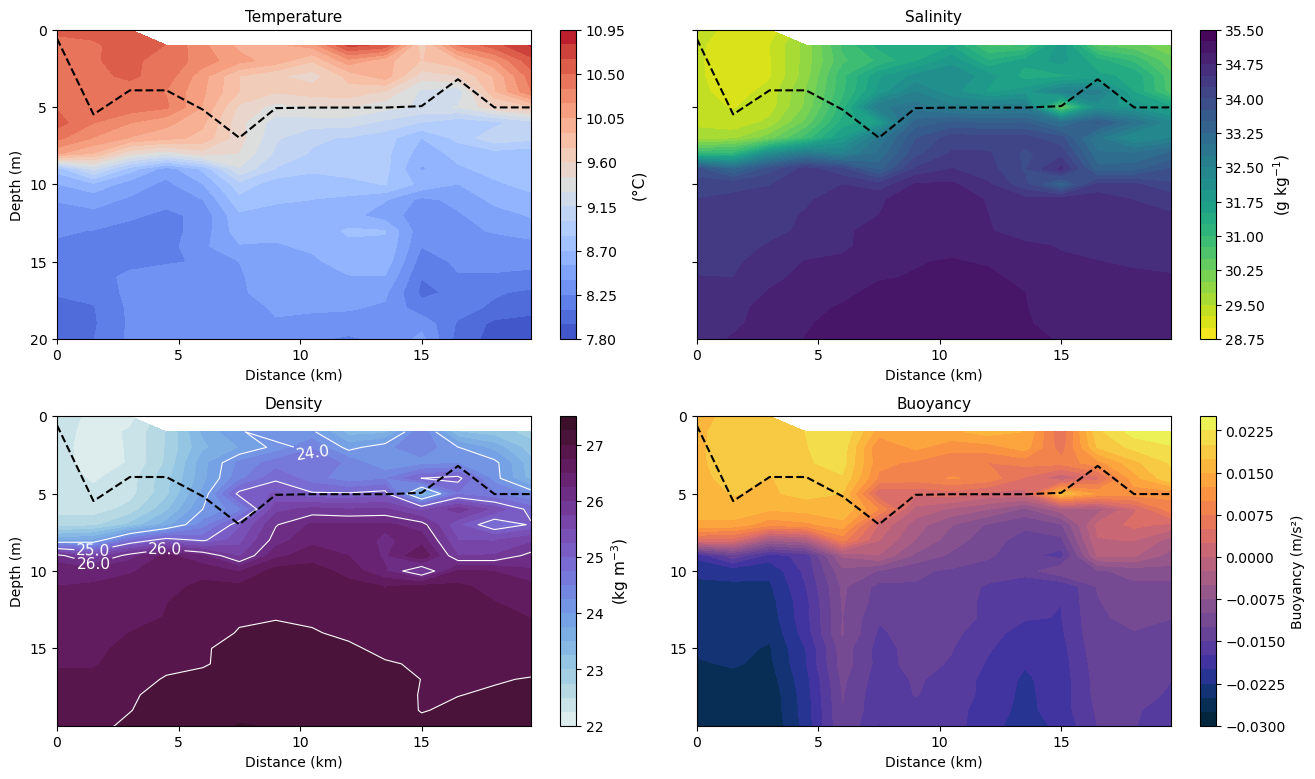

In [ ]:
# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=5, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
#mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])

# Plot temperature, salinity, and density with MLD overlay
fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2, figure=fig, height_ratios=[1, 1], hspace=0.25, wspace=0.08, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=11)
ax_temp.set_xlabel('Distance (km)')
ax_temp.set_ylabel('Depth (m)')
ax_temp.set_ylim(20, 0)
ax_temp.set_yticks(np.arange(0, 21, 5))
ax_temp.set_xlim(0, 19.5)
ax_temp.set_xticks(np.arange(0, 20, 5))
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=11)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=11)
ax_sali.set_xlabel('Distance (km)')
ax_sali.set_ylim(20, 0)
ax_sali.set_yticks(np.arange(0, 20, 5))
ax_sali.set_xlim(0, 19.5)
ax_sali.set_xticks(np.arange(0, 20, 5))
ax_sali.tick_params(axis='y', labelleft=False)
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=11)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=11, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=11)
ax_dens.set_xlabel('Distance (km)')
ax_dens.set_ylabel('Depth (m)')
ax_dens.set_xlim(0, 19.5)
ax_dens.set_xticks(np.arange(0, 20, 5))
ax_dens.set_ylim(20, 0)
ax_dens.set_yticks(np.arange(0, 20, 5))
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=11)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy, orientation='vertical')
cb4.set_label('Buoyancy (m/s²)')
ax_buoy.set_title('Buoyancy', fontsize=11)
ax_buoy.set_xlabel('Distance (km)')
ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_xticks(np.arange(0, 20, 5))
ax_buoy.set_ylim(20, 5)
ax_buoy.set_yticks(np.arange(0, 20, 5))

# Overlay MLD on all subplots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

plt.tight_layout()
plt.show()

In [160]:
# --- Load and process CTD files ---

from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt
import pytz
import gsw
from pyproj import Geod
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean as cmo

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')


def load_cnv(filepath):
    def dms_to_decimal(degrees, minutes, direction):
        decimal = float(degrees) + float(minutes) / 60
        if direction.upper() in ['S', 'W']:
            decimal *= -1
        return decimal

    with open(filepath, 'r', encoding='latin1') as f:
        lines = f.readlines()

    data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
    df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
    df.columns = [f'col_{i}' for i in range(df.shape[1])]

    lat = lon = None
    time_local = None
    for line in lines:
        if 'latitude' in line.lower():
            parts = line.split()
            try:
                lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'longitude' in line.lower():
            parts = line.split()
            try:
                lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'nmea utc' in line.lower():
            print(f"Found NMEA time line: {line.strip()}")
            try:
                time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
            except Exception as e:
                print(f"Failed to parse time from line: {line.strip()} → {e}")
                continue

    time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
    return df, lat, lon, time_utc


def process_ctd_casts(folder_path):
    filenames = [
        'CTD_05.cnv', 'CTD_06.cnv', 'CTD_07.cnv', 'CTD_08.cnv',
        'CTD_09.cnv', 'CTD_10.cnv', 'CTD_11.cnv', 'CTD_12.cnv',
        'CTD_13.cnv', 'CTD_14.cnv', 'CTD_15.cnv', 'CTD_16.cnv'
    ]
    cast_data = []
    for file in filenames:
        full_path = Path(folder_path) / file
        df, lat, lon, time_utc = load_cnv(full_path)

        SP = df['col_9'].to_numpy()
        T = df['col_2'].to_numpy()
        p = df['col_1'].to_numpy()

        # Filter out negative pressure values
        mask = (p >= 0) & (p <= 25)
        SP = SP[mask]
        T = T[mask]
        p = p[mask]

        SA = gsw.SA_from_SP(SP, p, lon, lat)
        CT = gsw.CT_from_t(SA, T, p)
        rho = gsw.sigma0(SA, CT) + 1000

        cast_data.append({
            'time': time_utc + dt.timedelta(hours=2) if time_utc is not None else None,
            'lat': lat,
            'lon': lon,
            'SA': SA,
            'CT': CT,
            'p': p,
            'rho': rho
        })
    return cast_data


ctd_casts = process_ctd_casts(folder_path)


# --- Interpolate buoyancy onto regular grid ---
def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=20):
    geod = Geod(ellps="WGS84")
    ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
    distances = [0]
    for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
        _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
        distances.append(distances[-1] + dist)

    d_reg = np.arange(0, distances[-1] + dx, dx)
    z_reg = np.arange(0, depth_max + 1, 1)

    b_profiles = []
    for cast in cast_data:
        rho = cast['rho']
        rho0 = np.nanmean(rho)
        b = 9.81 * (1 - rho / rho0)
        p = cast['p']
        z = gsw.z_from_p(p, cast['lat']) * -1
        interp_b = interp1d(z, b, bounds_error=False, fill_value=np.nan)
        b_profiles.append(interp_b(z_reg))

    b_profiles = np.array(b_profiles)
    b_grid = np.empty((len(z_reg), len(d_reg))) * np.nan
    for i, z_slice in enumerate(b_profiles.T):
        b_grid[i, :] = interp1d(distances, z_slice, bounds_error=False, fill_value=np.nan)(d_reg)

    b_3m = b_grid[np.argmin(np.abs(z_reg - 3))]
    mask = ~np.isnan(b_3m)
    b_3m_interp = np.interp(np.arange(len(b_3m)), np.flatnonzero(mask), b_3m[mask])
    b_3m_smooth = gaussian_filter1d(b_3m_interp, sigma=1)
    dbdx = np.gradient(b_3m_smooth, dx)

    b_smooth_3m = b_3m_smooth
    return d_reg, b_3m_smooth, dbdx, z_reg, b_grid, b_3m


dist_grid, b_smooth_3m, dbdx, depth_grid, b_grid, b_3m = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

# Compute distances for each cast
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

# Interpolation of SA and CT
from scipy.interpolate import griddata

def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
    sa_points, sa_values = [], []
    ct_points, ct_values = [], []

    for i, cast in enumerate(cast_data):
        p = cast['p']
        SA = cast['SA']
        CT = cast['CT']
        z = gsw.z_from_p(p, cast['lat']) * -1
        mask = (z >= 0) & (z <= np.max(depth_grid))
        z = z[mask]
        SA = SA[mask]
        CT = CT[mask]
        for zi, sai, cti in zip(z, SA, CT):
            sa_points.append([distances[i], zi])
            sa_values.append(sai)
            ct_points.append([distances[i], zi])
            ct_values.append(cti)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
    CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')
    return SA_grid, CT_grid


SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

SA_i = SA_grid[np.argmin(np.abs(depth_grid - 3)), :]
CT_i = CT_grid[np.argmin(np.abs(depth_grid - 3)), :]

# Interpolate environmental data to CTD transect times
df_env = pd.read_csv(folder_path / 'sk_weather.csv')
df_env['datetime'] = pd.to_datetime(df_env['ts'])
df_env['wind_dir_rad'] = np.deg2rad((df_env['winddir'] + 180) % 360)

valid_time_mask = [cast['time'] is not None for cast in ctd_casts]

# Log CTD casts with missing time for diagnostics
for i, valid in enumerate(valid_time_mask):
    if not valid:
        print(f"Warning: CTD cast at index {i} has no valid timestamp.")
valid_ctd_times = [cast['time'] for i, cast in enumerate(ctd_casts) if valid_time_mask[i]]
valid_distances = [dist for i, dist in enumerate(distances) if valid_time_mask[i]]

time_interp = np.interp(dist_grid, valid_distances, [t.timestamp() for t in valid_ctd_times])
times_dt = [dt.datetime.utcfromtimestamp(t) for t in time_interp]

df_env['ts_numeric'] = df_env['datetime'].astype(np.int64) / 1e9
wind_speed = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['windspeed'])
wind_dir_rad = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['wind_dir_rad'])
current_dir_rad = np.full_like(wind_speed, np.deg2rad(90))  # Placeholder or interpolate real current data if available

valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_3m) & ~np.isnan(dbdx)

dist_grid_clean = dist_grid[valid_mask]
SA_i_clean = SA_i[valid_mask]
CT_i_clean = CT_i[valid_mask]
b_smooth_clean = b_smooth_3m[valid_mask]
dbdx_clean = dbdx[valid_mask]
wind_speed = wind_speed[valid_mask]
wind_dir_rad = wind_dir_rad[valid_mask]
current_dir_rad = current_dir_rad[valid_mask]


# --- Compute Q_EBF ---
def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
    g = 9.81
    Cp = 4000
    rho_air = 1.2
    Cd = 1.5e-3
    f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
    tau = Cd * rho_air * wind_speed ** 2
    delta_theta = wind_dir_rad - current_dir_rad
    tau_along = tau * np.cos(delta_theta)
    alpha = gsw.alpha(SA_i, CT_i, 0)
    Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

    return pd.DataFrame({
        'distance_m': dist_grid,
        'Q_EBF': Q_EBF,
        'b_3m': b_smooth,
        'dbdx': dbdx,
        'tau_along': tau_along
    })


df_ctd = compute_Q_EBF_ctd(
    dist_grid_clean, SA_i_clean, CT_i_clean, b_smooth_clean, dbdx_clean,
    wind_speed, wind_dir_rad, current_dir_rad
)

Found NMEA time line: * NMEA UTC (Time) = May 07 2025 08:44:53
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:15:41
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:38:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:06:26
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:44:48
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:11:29
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:30:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:52:13
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:13:01
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:38:22
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:57:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 13:17:45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\961092268.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


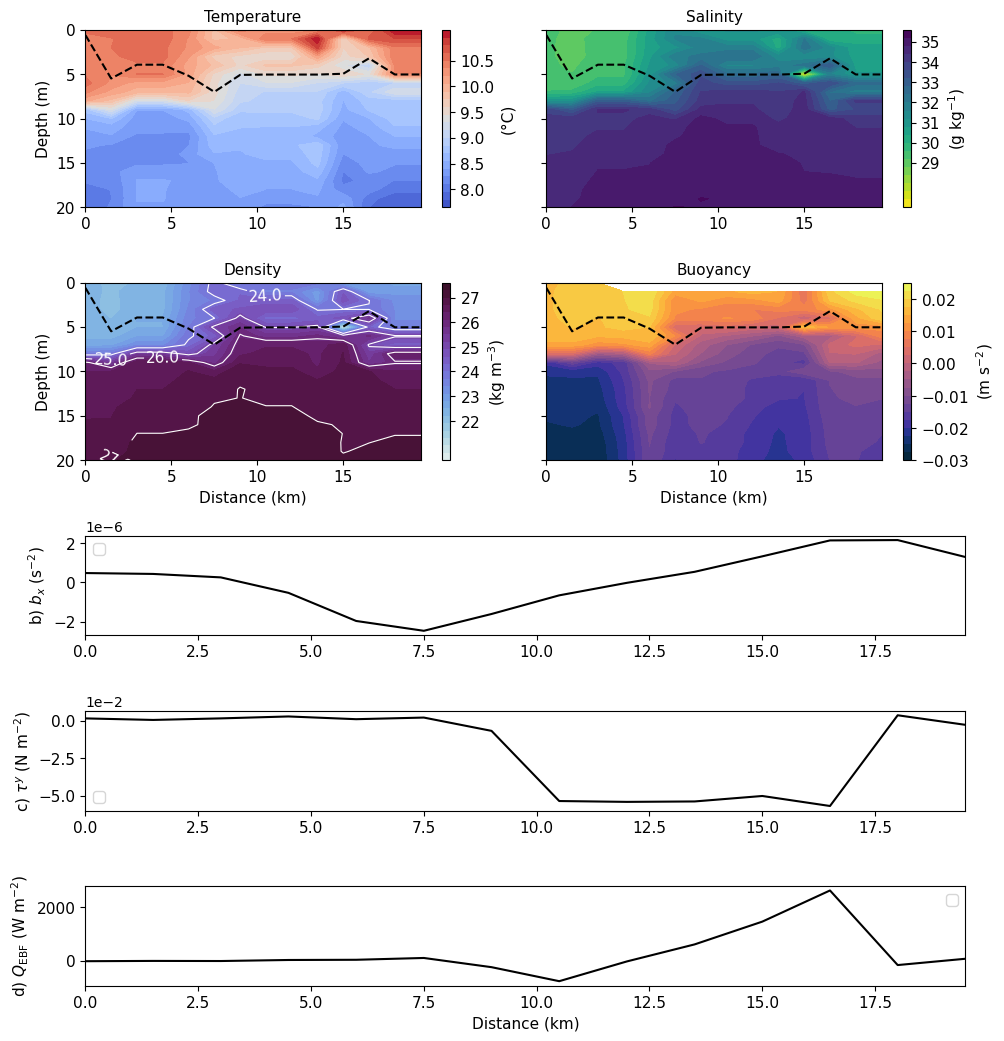

In [164]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator


# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=5, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
if interp_indices.size > 0:
    mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])
else:
    mld = np.full_like(dist_grid, np.nan, dtype=float)

# Plot vertical profiles and distance series
fig = plt.figure(figsize=(10, 13))
gs = gridspec.GridSpec(6, 2, figure=fig, height_ratios=[1.6, 1.6, 0.9, 0.9, 0.9, 0.9], hspace=0.6, wspace=0.1, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])
ax_grad = fig.add_subplot(gs[2, :])
ax_tao = fig.add_subplot(gs[3, :])
ax_flux = fig.add_subplot(gs[4, :])

common_fontsize = 11

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=common_fontsize)
#ax_temp.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_temp.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_temp.tick_params(axis='both', labelsize=common_fontsize)
ax_temp.set_ylim(20, 0)
ax_temp.set_xlim(0, 19.5)
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=common_fontsize)
cb1.set_ticks(np.arange(8, 11, 0.5))
cb1.ax.tick_params(labelsize=common_fontsize)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=common_fontsize)
#ax_sali.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.tick_params(axis='both', labelsize=common_fontsize)
ax_sali.tick_params(axis='y', labelleft=False)
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=common_fontsize)
cb2.set_ticks(np.arange(29, 36, 1))
cb2.ax.tick_params(labelsize=common_fontsize)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=common_fontsize, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=common_fontsize)
ax_dens.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_dens.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_dens.tick_params(axis='both', labelsize=common_fontsize)
ax_dens.set_xlim(0, 19.5)
ax_dens.set_ylim(20, 0)
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=common_fontsize)
cb3.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb3.ax.tick_params(labelsize=common_fontsize)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy)
cb4.set_label(r'(m s$^{-2}$)', fontsize=common_fontsize)
cb4.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb4.ax.tick_params(labelsize=common_fontsize)
cb4.set_ticks(np.arange(-0.03, 0.03, 0.01))
ax_buoy.set_title('Buoyancy', fontsize=common_fontsize)
ax_buoy.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_buoy.set_ylabel('Depth (m)', fontsize=common_fontsize)
#ax_buoy.tick_params(axis='both', labelsize=common_fontsize)

ax_buoy.tick_params(axis='both', labelsize=common_fontsize)
ax_buoy.tick_params(axis='y', labelleft=False)

ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_ylim(20, 0)

# Overlay MLD on vertical plots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

# Horizontal plots with their own axes
ax_grad.plot(dist_grid_clean / 1000, dbdx_clean, color='black')
ax_grad.set_ylabel(r'b) $b_x$ (s$^{-2}$)', fontsize=common_fontsize)
#ax_grad.set_title('Buoyancy Gradient', fontsize=common_fontsize)
#ax_grad.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_grad.legend(fontsize=common_fontsize)
ax_grad.set_xlim(0, 19.5)
ax_grad.tick_params(axis='both', labelsize=common_fontsize)

ax_tao.plot(dist_grid_clean / 1000, df_ctd['tau_along'], color='black')
ax_tao.set_ylabel(r'c) $\tau^y$ (N m$^{-2}$)', fontsize=common_fontsize)
#ax_tao.set_title('Wind Stress at 3 m', fontsize=common_fontsize)
ax_tao.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_tao.legend(fontsize=common_fontsize)
ax_tao.set_xlim(0, 19.5)
ax_tao.tick_params(axis='both', labelsize=common_fontsize)

ax_flux.plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], color='black')
ax_flux.set_ylabel('d) $Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=common_fontsize)
ax_flux.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_flux.set_title('Ekman Buoyancy Flux', fontsize=common_fontsize)
#ax_flux.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_flux.legend(fontsize=common_fontsize)
ax_flux.set_xlim(0, 19.5)
ax_flux.tick_params(axis='both', labelsize=common_fontsize)

plt.tight_layout()
plt.show()

# Interpolate boyancy too

In [167]:
  # --- Load and process CTD files ---
  
  from pathlib import Path
  import numpy as np
  import pandas as pd
  import datetime as dt
  import pytz
  import gsw
  from pyproj import Geod
  from scipy.interpolate import interp1d, UnivariateSpline, griddata
  from scipy.ndimage import gaussian_filter1d
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  import cmocean as cmo
  
  folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')
  
  
  def load_cnv(filepath):
      def dms_to_decimal(degrees, minutes, direction):
          decimal = float(degrees) + float(minutes) / 60
          if direction.upper() in ['S', 'W']:
              decimal *= -1
          return decimal

      with open(filepath, 'r', encoding='latin1') as f:
          lines = f.readlines()

      data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
      df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
      df.columns = [f'col_{i}' for i in range(df.shape[1])]

      lat = lon = None
      time_local = None
      for line in lines:
          if 'latitude' in line.lower():
              parts = line.split()
              try:
                  lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
              except:
                  continue
          if 'longitude' in line.lower():
              parts = line.split()
              try:
                  lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
              except:
                  continue
          if 'nmea utc' in line.lower():
              print(f"Found NMEA time line: {line.strip()}")
              try:
                  time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                  time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
              except Exception as e:
                  print(f"Failed to parse time from line: {line.strip()} → {e}")
                  continue

      time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
      return df, lat, lon, time_utc


  def process_ctd_casts(folder_path):
      filenames = [
          'CTD_05.cnv', 'CTD_06.cnv', 'CTD_07.cnv', 'CTD_08.cnv',
          'CTD_09.cnv', 'CTD_10.cnv', 'CTD_11.cnv', 'CTD_12.cnv',
          'CTD_13.cnv', 'CTD_14.cnv', 'CTD_15.cnv', 'CTD_16.cnv'
      ]
      cast_data = []
      for file in filenames:
          full_path = Path(folder_path) / file
          df, lat, lon, time_utc = load_cnv(full_path)

          SP = df['col_9'].to_numpy()
          T = df['col_2'].to_numpy()
          p = df['col_1'].to_numpy()

          # Filter out negative pressure values
          mask = (p >= 0) & (p <= 25)
          SP = SP[mask]
          T = T[mask]
          p = p[mask]

          SA = gsw.SA_from_SP(SP, p, lon, lat)
          CT = gsw.CT_from_t(SA, T, p)
          rho = gsw.sigma0(SA, CT) + 1000

          cast_data.append({
              'time': time_utc + dt.timedelta(hours=2) if time_utc is not None else None,
              'lat': lat,
              'lon': lon,
              'SA': SA,
              'CT': CT,
              'p': p,
              'rho': rho
          })
      return cast_data


  ctd_casts = process_ctd_casts(folder_path)


  # --- Interpolate buoyancy onto regular grid ---
  def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=20):
      geod = Geod(ellps="WGS84")
      ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
      distances = [0]
      for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
          _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
          distances.append(distances[-1] + dist)

      d_reg = np.arange(0, distances[-1] + dx, dx)
      z_reg = np.arange(0, depth_max + 1, 1)

      b_points, b_values = [], []
      for i, cast in enumerate(cast_data):
          rho = cast['rho']
          rho0 = np.nanmean(rho)
          b = 9.81 * (1 - rho / rho0)
          p = cast['p']
          z = gsw.z_from_p(p, cast['lat']) * -1
          mask = (z >= 0) & (z <= np.max(z_reg))
          z = z[mask]
          b = b[mask]
          for zi, bi in zip(z, b):
              b_points.append([distances[i], zi])
              b_values.append(bi)

      grid_x, grid_z = np.meshgrid(d_reg, z_reg)
      b_grid = griddata(b_points, b_values, (grid_x, grid_z), method='nearest')

      # Interpolate only where missing
      b_grid_interp = griddata(b_points, b_values, (grid_x, grid_z), method='linear')
      mask_missing = np.isnan(b_grid)
      b_grid[mask_missing] = b_grid_interp[mask_missing]

      b_3m = b_grid[np.argmin(np.abs(z_reg - 3))]
      mask = ~np.isnan(b_3m)
      b_3m_interp = np.interp(np.arange(len(b_3m)), np.flatnonzero(mask), b_3m[mask])
      b_3m_smooth = gaussian_filter1d(b_3m_interp, sigma=1)
      dbdx = np.gradient(b_3m_smooth, dx)

      b_smooth_3m = b_3m_smooth
      return d_reg, b_smooth_3m, dbdx, z_reg, b_grid, b_3m


  dist_grid, b_smooth_3m, dbdx, depth_grid, b_grid, b_3m = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

  # Compute distances for each cast
  geod = Geod(ellps="WGS84")
  distances = [0]
  for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
      _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
      distances.append(distances[-1] + dist)

  # Interpolation of SA and CT

  def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
      sa_points, sa_values = [], []
      ct_points, ct_values = [], []

      for i, cast in enumerate(cast_data):
          p = cast['p']
          SA = cast['SA']
          CT = cast['CT']
          z = gsw.z_from_p(p, cast['lat']) * -1
          mask = (z >= 0) & (z <= np.max(depth_grid))
          z = z[mask]
          SA = SA[mask]
          CT = CT[mask]
          for zi, sai, cti in zip(z, SA, CT):
              sa_points.append([distances[i], zi])
              sa_values.append(sai)
              ct_points.append([distances[i], zi])
              ct_values.append(cti)

      grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
      SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
      CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')
      return SA_grid, CT_grid


  SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)

  SA_i = SA_grid[np.argmin(np.abs(depth_grid - 3)), :]
  CT_i = CT_grid[np.argmin(np.abs(depth_grid - 3)), :]

  # Interpolate environmental data to CTD transect times
  df_env = pd.read_csv(folder_path / 'sk_weather.csv')
  df_env['datetime'] = pd.to_datetime(df_env['ts'])
  df_env['wind_dir_rad'] = np.deg2rad((df_env['winddir'] + 180) % 360)

  valid_time_mask = [cast['time'] is not None for cast in ctd_casts]

  # Log CTD casts with missing time for diagnostics
  for i, valid in enumerate(valid_time_mask):
      if not valid:
          print(f"Warning: CTD cast at index {i} has no valid timestamp.")
  valid_ctd_times = [cast['time'] for i, cast in enumerate(ctd_casts) if valid_time_mask[i]]
  valid_distances = [dist for i, dist in enumerate(distances) if valid_time_mask[i]]

  time_interp = np.interp(dist_grid, valid_distances, [t.timestamp() for t in valid_ctd_times])
  times_dt = [dt.datetime.utcfromtimestamp(t) for t in time_interp]

  df_env['ts_numeric'] = df_env['datetime'].astype(np.int64) / 1e9
  wind_speed = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['windspeed'])
  wind_dir_rad = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['wind_dir_rad'])
  current_dir_rad = np.full_like(wind_speed, np.deg2rad(90))  # Placeholder or interpolate real current data if available

  valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_3m) & ~np.isnan(dbdx)

  dist_grid_clean = dist_grid[valid_mask]
  SA_i_clean = SA_i[valid_mask]
  CT_i_clean = CT_i[valid_mask]
  b_smooth_clean = b_smooth_3m[valid_mask]
  dbdx_clean = dbdx[valid_mask]
  wind_speed = wind_speed[valid_mask]
  wind_dir_rad = wind_dir_rad[valid_mask]
  current_dir_rad = current_dir_rad[valid_mask]


  # --- Compute Q_EBF ---
  def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
      g = 9.81
      Cp = 4000
      rho_air = 1.2
      Cd = 1.5e-3
      f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
      tau = Cd * rho_air * wind_speed ** 2
      delta_theta = wind_dir_rad - current_dir_rad
      tau_along = tau * np.cos(delta_theta)
      alpha = gsw.alpha(SA_i, CT_i, 0)
      Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

      return pd.DataFrame({
          'distance_m': dist_grid,
          'Q_EBF': Q_EBF,
          'b_3m': b_smooth,
          'dbdx': dbdx,
          'tau_along': tau_along
      })


  df_ctd = compute_Q_EBF_ctd(
      dist_grid_clean, SA_i_clean, CT_i_clean, b_smooth_clean, dbdx_clean,
      wind_speed, wind_dir_rad, current_dir_rad
  )


Found NMEA time line: * NMEA UTC (Time) = May 07 2025 08:44:53
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:15:41
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:38:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:06:26
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:44:48
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:11:29
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:30:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:52:13
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:13:01
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:38:22
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:57:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 13:17:45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\3744766345.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


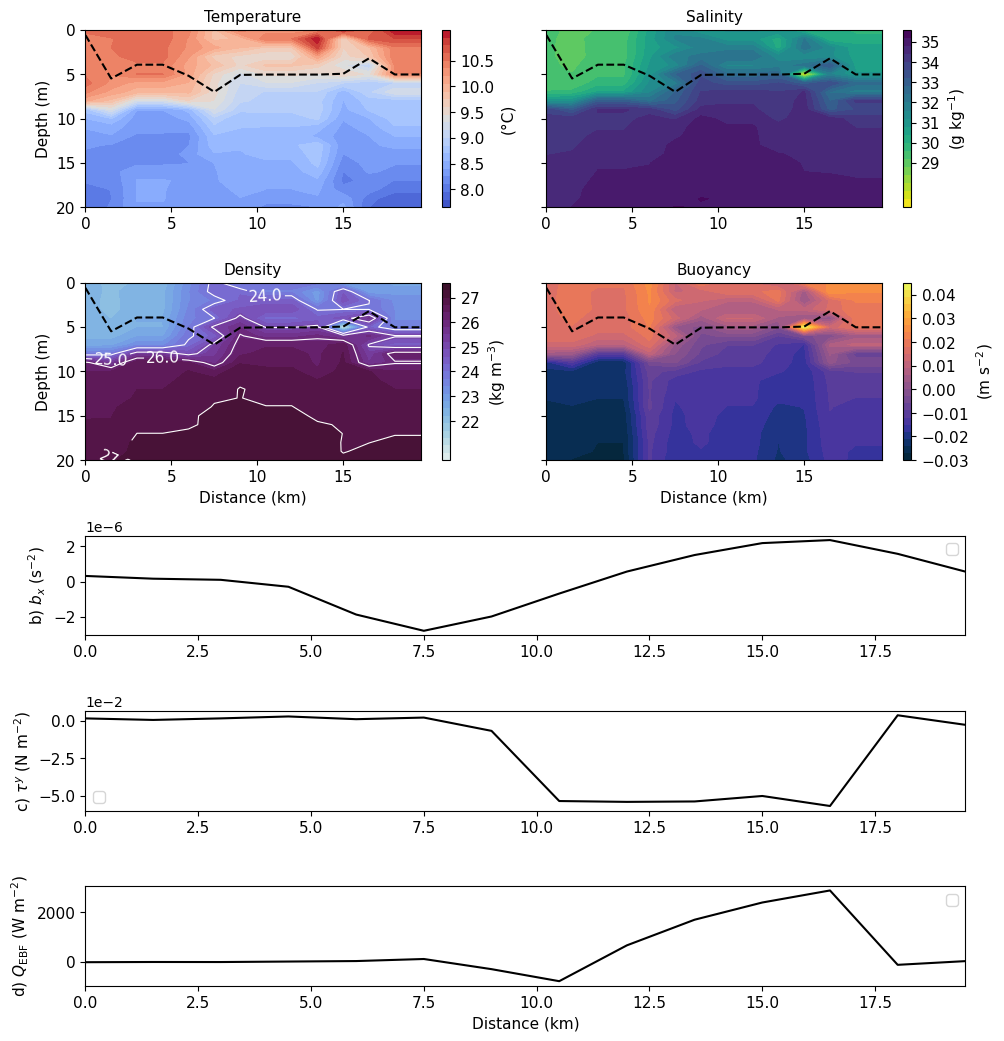

In [171]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator


# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=5, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
if interp_indices.size > 0:
    mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])
else:
    mld = np.full_like(dist_grid, np.nan, dtype=float)

# Plot vertical profiles and distance series
fig = plt.figure(figsize=(10, 13))
gs = gridspec.GridSpec(6, 2, figure=fig, height_ratios=[1.6, 1.6, 0.9, 0.9, 0.9, 0.9], hspace=0.6, wspace=0.1, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])
ax_grad = fig.add_subplot(gs[2, :])
ax_tao = fig.add_subplot(gs[3, :])
ax_flux = fig.add_subplot(gs[4, :])

common_fontsize = 11

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=common_fontsize)
#ax_temp.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_temp.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_temp.tick_params(axis='both', labelsize=common_fontsize)
ax_temp.set_ylim(20, 0)
ax_temp.set_xlim(0, 19.5)
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=common_fontsize)
cb1.set_ticks(np.arange(8, 11, 0.5))
cb1.ax.tick_params(labelsize=common_fontsize)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=common_fontsize)
#ax_sali.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.tick_params(axis='both', labelsize=common_fontsize)
ax_sali.tick_params(axis='y', labelleft=False)
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=common_fontsize)
cb2.set_ticks(np.arange(29, 36, 1))
cb2.ax.tick_params(labelsize=common_fontsize)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=common_fontsize, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=common_fontsize)
ax_dens.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_dens.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_dens.tick_params(axis='both', labelsize=common_fontsize)
ax_dens.set_xlim(0, 19.5)
ax_dens.set_ylim(20, 0)
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=common_fontsize)
cb3.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb3.ax.tick_params(labelsize=common_fontsize)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy)
cb4.set_label(r'(m s$^{-2}$)', fontsize=common_fontsize)
cb4.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb4.ax.tick_params(labelsize=common_fontsize)
cb4.set_ticks(np.arange(-0.03, 0.05, 0.01))
ax_buoy.set_title('Buoyancy', fontsize=common_fontsize)
ax_buoy.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_buoy.set_ylabel('Depth (m)', fontsize=common_fontsize)
#ax_buoy.tick_params(axis='both', labelsize=common_fontsize)

ax_buoy.tick_params(axis='both', labelsize=common_fontsize)
ax_buoy.tick_params(axis='y', labelleft=False)

ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_ylim(20, 0)

# Overlay MLD on vertical plots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

# Horizontal plots with their own axes
ax_grad.plot(dist_grid_clean / 1000, dbdx_clean, color='black')
ax_grad.set_ylabel(r'b) $b_x$ (s$^{-2}$)', fontsize=common_fontsize)
#ax_grad.set_title('Buoyancy Gradient', fontsize=common_fontsize)
#ax_grad.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_grad.legend(fontsize=common_fontsize)
ax_grad.set_xlim(0, 19.5)
ax_grad.tick_params(axis='both', labelsize=common_fontsize)

ax_tao.plot(dist_grid_clean / 1000, df_ctd['tau_along'], color='black')
ax_tao.set_ylabel(r'c) $\tau^y$ (N m$^{-2}$)', fontsize=common_fontsize)
#ax_tao.set_title('Wind Stress at 3 m', fontsize=common_fontsize)
ax_tao.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_tao.legend(fontsize=common_fontsize)
ax_tao.set_xlim(0, 19.5)
ax_tao.tick_params(axis='both', labelsize=common_fontsize)

ax_flux.plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], color='black')
ax_flux.set_ylabel('d) $Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=common_fontsize)
ax_flux.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_flux.set_title('Ekman Buoyancy Flux', fontsize=common_fontsize)
#ax_flux.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_flux.legend(fontsize=common_fontsize)
ax_flux.set_xlim(0, 19.5)
ax_flux.tick_params(axis='both', labelsize=common_fontsize)

plt.tight_layout()
plt.show()

# Fixed curretn

In [175]:
  # --- Load and process CTD files ---

  from pathlib import Path
  import numpy as np
  import pandas as pd
  import datetime as dt
  import pytz
  import gsw
  from pyproj import Geod
  from scipy.interpolate import interp1d, UnivariateSpline, griddata
  from scipy.ndimage import gaussian_filter1d
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  import cmocean as cmo

  folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')

  def load_cnv(filepath):
      def dms_to_decimal(degrees, minutes, direction):
          decimal = float(degrees) + float(minutes) / 60
          if direction.upper() in ['S', 'W']:
              decimal *= -1
          return decimal

      with open(filepath, 'r', encoding='latin1') as f:
          lines = f.readlines()

      data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
      df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
      df.columns = [f'col_{i}' for i in range(df.shape[1])]

      lat = lon = None
      time_local = None
      for line in lines:
          if 'latitude' in line.lower():
              parts = line.split()
              try:
                  lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
              except:
                  continue
          if 'longitude' in line.lower():
              parts = line.split()
              try:
                  lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
              except:
                  continue
          if 'nmea utc' in line.lower():
              print(f"Found NMEA time line: {line.strip()}")
              try:
                  time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                  time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
              except Exception as e:
                  print(f"Failed to parse time from line: {line.strip()} → {e}")
                  continue

      time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
      return df, lat, lon, time_utc

  def process_ctd_casts(folder_path):
      filenames = [
          'CTD_05.cnv', 'CTD_06.cnv', 'CTD_07.cnv', 'CTD_08.cnv',
          'CTD_09.cnv', 'CTD_10.cnv', 'CTD_11.cnv', 'CTD_12.cnv',
          'CTD_13.cnv', 'CTD_14.cnv', 'CTD_15.cnv', 'CTD_16.cnv'
      ]
      cast_data = []
      for file in filenames:
          full_path = Path(folder_path) / file
          df, lat, lon, time_utc = load_cnv(full_path)

          SP = df['col_9'].to_numpy()
          T = df['col_2'].to_numpy()
          p = df['col_1'].to_numpy()

          # Filter out negative pressure values
          mask = (p >= 0) & (p <= 25)
          SP = SP[mask]
          T = T[mask]
          p = p[mask]

          SA = gsw.SA_from_SP(SP, p, lon, lat)
          CT = gsw.CT_from_t(SA, T, p)
          rho = gsw.sigma0(SA, CT) + 1000

          cast_data.append({
              'time': time_utc + dt.timedelta(hours=2) if time_utc is not None else None,
              'lat': lat,
              'lon': lon,
              'SA': SA,
              'CT': CT,
              'p': p,
              'rho': rho
          })
      return cast_data

  ctd_casts = process_ctd_casts(folder_path)

  # --- Interpolate buoyancy onto regular grid ---
  def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=20):
      geod = Geod(ellps="WGS84")
      ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
      distances = [0]
      for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
          _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
          distances.append(distances[-1] + dist)

      d_reg = np.arange(0, distances[-1] + dx, dx)
      z_reg = np.arange(0, depth_max + 1, 1)

      b_points, b_values = [], []
      for i, cast in enumerate(cast_data):
          rho = cast['rho']
          rho0 = 1025
          b = 9.81 * (1 - rho / rho0)
          p = cast['p']
          z = gsw.z_from_p(p, cast['lat']) * -1
          mask = (z >= 0) & (z <= np.max(z_reg))
          z = z[mask]
          b = b[mask]
          for zi, bi in zip(z, b):
              b_points.append([distances[i], zi])
              b_values.append(bi)

      grid_x, grid_z = np.meshgrid(d_reg, z_reg)
      b_grid = griddata(b_points, b_values, (grid_x, grid_z), method='nearest')
      b_grid_interp = griddata(b_points, b_values, (grid_x, grid_z), method='linear')
      mask_missing = np.isnan(b_grid)
      b_grid[mask_missing] = b_grid_interp[mask_missing]

      b_3m = b_grid[np.argmin(np.abs(z_reg - 3))]
      mask = ~np.isnan(b_3m)
      b_3m_interp = np.interp(np.arange(len(b_3m)), np.flatnonzero(mask), b_3m[mask])
      b_3m_smooth = gaussian_filter1d(b_3m_interp, sigma=1)
      dbdx = np.gradient(b_3m_smooth, dx)

      b_smooth_3m = b_3m_smooth
      return d_reg, b_smooth_3m, dbdx, z_reg, b_grid, b_3m

  dist_grid, b_smooth_3m, dbdx, depth_grid, b_grid, b_3m = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

  geod = Geod(ellps="WGS84")
  distances = [0]
  for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
      _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
      distances.append(distances[-1] + dist)

  def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
      sa_points, sa_values = [], []
      ct_points, ct_values = [], []

      for i, cast in enumerate(cast_data):
          p = cast['p']
          SA = cast['SA']
          CT = cast['CT']
          z = gsw.z_from_p(p, cast['lat']) * -1
          mask = (z >= 0) & (z <= np.max(depth_grid))
          z = z[mask]
          SA = SA[mask]
          CT = CT[mask]
          for zi, sai, cti in zip(z, SA, CT):
              sa_points.append([distances[i], zi])
              sa_values.append(sai)
              ct_points.append([distances[i], zi])
              ct_values.append(cti)

      grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
      SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
      CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')
      return SA_grid, CT_grid

  SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)
  SA_i = SA_grid[np.argmin(np.abs(depth_grid - 3)), :]
  CT_i = CT_grid[np.argmin(np.abs(depth_grid - 3)), :]

  df_env = pd.read_csv(folder_path / 'sk_weather.csv')
  df_env['datetime'] = pd.to_datetime(df_env['ts'])
  df_env['wind_dir_rad'] = np.deg2rad((df_env['winddir'] + 180) % 360)

  valid_time_mask = [cast['time'] is not None for cast in ctd_casts]
  for i, valid in enumerate(valid_time_mask):
      if not valid:
          print(f"Warning: CTD cast at index {i} has no valid timestamp.")
  valid_ctd_times = [cast['time'] for i, cast in enumerate(ctd_casts) if valid_time_mask[i]]
  valid_distances = [dist for i, dist in enumerate(distances) if valid_time_mask[i]]

  time_interp = np.interp(dist_grid, valid_distances, [t.timestamp() for t in valid_ctd_times])
  times_dt = [dt.datetime.utcfromtimestamp(t) for t in time_interp]

  df_env['ts_numeric'] = df_env['datetime'].astype(np.int64) / 1e9
  wind_speed = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['windspeed'])
  wind_dir_rad = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['wind_dir_rad'])

  # Load and interpolate current direction from ADCP
  adcp_file = folder_path / 'adcp0507_postpro20may.txt'
  adcp = pd.read_csv(adcp_file, sep="\t", skiprows=12, engine="python").iloc[3:-3].reset_index(drop=True)
  adcp = adcp.map(lambda x: str(x).replace(",", "."))

  def parse_int(x):
      try:
          return int(float(x))
      except:
          return 0

  ymdhms = adcp[['YR', 'MO', 'DA', 'HH', 'MM', 'SS']].apply(lambda col: col.map(parse_int)).to_numpy()
  adcp_time = [dt.datetime(2000 + y, m, d, hh, mm, ss) for y, m, d, hh, mm, ss in ymdhms]
  adcp_time = [pytz.timezone('Europe/Stockholm').localize(t).astimezone(pytz.utc).replace(tzinfo=None) for t in adcp_time]

  u = adcp[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
  v = adcp[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
  theta_current = np.arctan2(v, u)

  theta_time = np.array([t.timestamp() for t in adcp_time])
  theta_values = theta_current
  current_dir_rad = np.interp(
      [t.timestamp() for t in times_dt],
      theta_time,
      theta_values
  )

  valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_3m) & ~np.isnan(dbdx)

  dist_grid_clean = dist_grid[valid_mask]
  SA_i_clean = SA_i[valid_mask]
  CT_i_clean = CT_i[valid_mask]
  b_smooth_clean = b_smooth_3m[valid_mask]
  dbdx_clean = dbdx[valid_mask]
  wind_speed = wind_speed[valid_mask]
  wind_dir_rad = wind_dir_rad[valid_mask]
  current_dir_rad = current_dir_rad[valid_mask]

  def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
      g = 9.81
      Cp = 4000
      rho_air = 1.2
      Cd = 1.5e-3
      f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
      tau = Cd * rho_air * wind_speed ** 2
      delta_theta = wind_dir_rad - current_dir_rad
      tau_along = tau * np.cos(delta_theta)
      alpha = gsw.alpha(SA_i, CT_i, 0)
      Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

      return pd.DataFrame({
          'distance_m': dist_grid,
          'Q_EBF': Q_EBF,
          'b_3m': b_smooth,
          'dbdx': dbdx,
          'tau_along': tau_along
      })

  df_ctd = compute_Q_EBF_ctd(
      dist_grid_clean, SA_i_clean, CT_i_clean, b_smooth_clean, dbdx_clean,
      wind_speed, wind_dir_rad, current_dir_rad
  )


Found NMEA time line: * NMEA UTC (Time) = May 07 2025 08:44:53
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:15:41
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:38:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:06:26
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:44:48
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:11:29
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:30:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:52:13
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:13:01
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:38:22
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:57:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 13:17:45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\3744766345.py:126: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


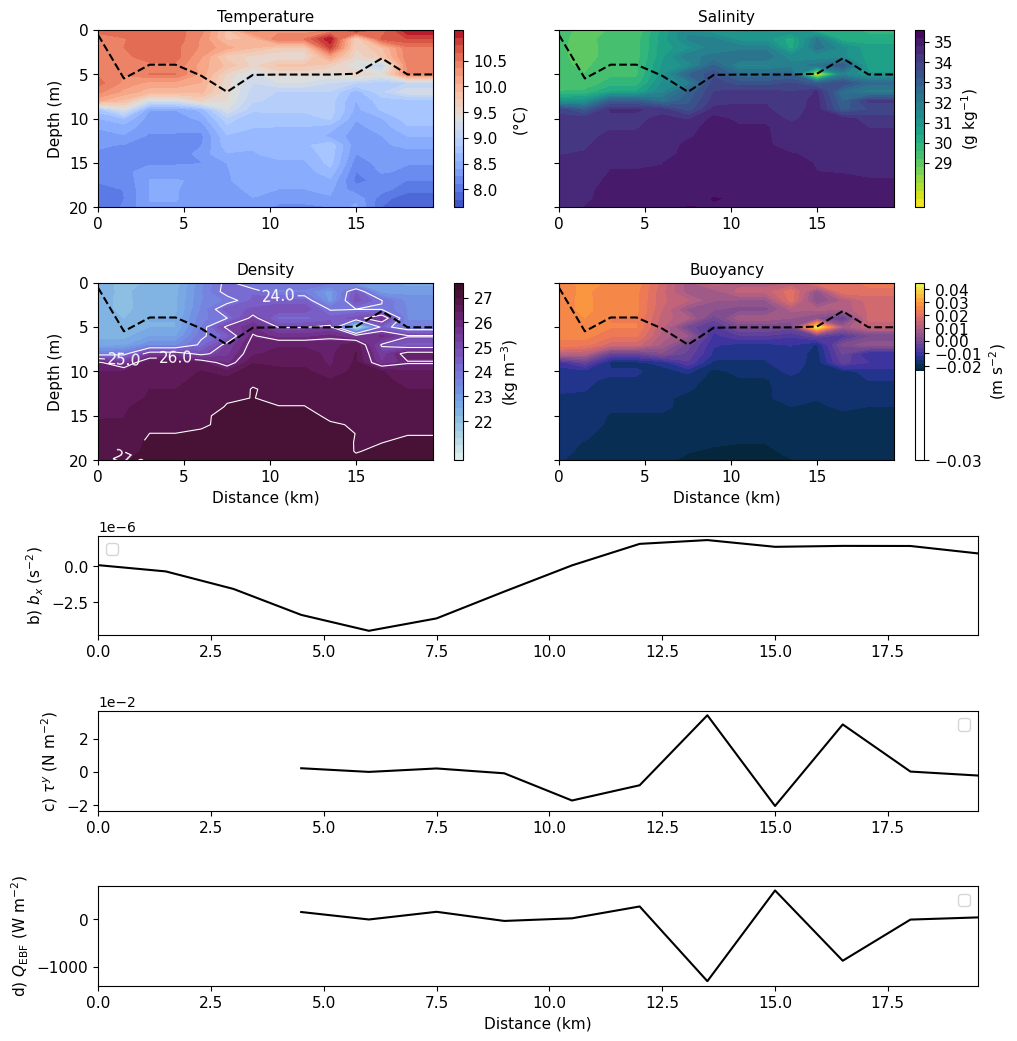

In [176]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator


# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=5, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
if interp_indices.size > 0:
    mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])
else:
    mld = np.full_like(dist_grid, np.nan, dtype=float)

# Plot vertical profiles and distance series
fig = plt.figure(figsize=(10, 13))
gs = gridspec.GridSpec(6, 2, figure=fig, height_ratios=[1.6, 1.6, 0.9, 0.9, 0.9, 0.9], hspace=0.6, wspace=0.1, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])
ax_grad = fig.add_subplot(gs[2, :])
ax_tao = fig.add_subplot(gs[3, :])
ax_flux = fig.add_subplot(gs[4, :])

common_fontsize = 11

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=common_fontsize)
#ax_temp.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_temp.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_temp.tick_params(axis='both', labelsize=common_fontsize)
ax_temp.set_ylim(20, 0)
ax_temp.set_xlim(0, 19.5)
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=common_fontsize)
cb1.set_ticks(np.arange(8, 11, 0.5))
cb1.ax.tick_params(labelsize=common_fontsize)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=common_fontsize)
#ax_sali.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.tick_params(axis='both', labelsize=common_fontsize)
ax_sali.tick_params(axis='y', labelleft=False)
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=common_fontsize)
cb2.set_ticks(np.arange(29, 36, 1))
cb2.ax.tick_params(labelsize=common_fontsize)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=common_fontsize, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=common_fontsize)
ax_dens.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_dens.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_dens.tick_params(axis='both', labelsize=common_fontsize)
ax_dens.set_xlim(0, 19.5)
ax_dens.set_ylim(20, 0)
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=common_fontsize)
cb3.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb3.ax.tick_params(labelsize=common_fontsize)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy)
cb4.set_label(r'(m s$^{-2}$)', fontsize=common_fontsize)
cb4.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb4.ax.tick_params(labelsize=common_fontsize)
cb4.set_ticks(np.arange(-0.03, 0.05, 0.01))
ax_buoy.set_title('Buoyancy', fontsize=common_fontsize)
ax_buoy.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_buoy.set_ylabel('Depth (m)', fontsize=common_fontsize)
#ax_buoy.tick_params(axis='both', labelsize=common_fontsize)

ax_buoy.tick_params(axis='both', labelsize=common_fontsize)
ax_buoy.tick_params(axis='y', labelleft=False)

ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_ylim(20, 0)

# Overlay MLD on vertical plots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

# Horizontal plots with their own axes
ax_grad.plot(dist_grid_clean / 1000, dbdx_clean, color='black')
ax_grad.set_ylabel(r'b) $b_x$ (s$^{-2}$)', fontsize=common_fontsize)
#ax_grad.set_title('Buoyancy Gradient', fontsize=common_fontsize)
#ax_grad.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_grad.legend(fontsize=common_fontsize)
ax_grad.set_xlim(0, 19.5)
ax_grad.tick_params(axis='both', labelsize=common_fontsize)

ax_tao.plot(dist_grid_clean / 1000, df_ctd['tau_along'], color='black')
ax_tao.set_ylabel(r'c) $\tau^y$ (N m$^{-2}$)', fontsize=common_fontsize)
#ax_tao.set_title('Wind Stress at 3 m', fontsize=common_fontsize)
ax_tao.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_tao.legend(fontsize=common_fontsize)
ax_tao.set_xlim(0, 19.5)
ax_tao.tick_params(axis='both', labelsize=common_fontsize)

ax_flux.plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], color='black')
ax_flux.set_ylabel('d) $Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=common_fontsize)
ax_flux.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_flux.set_title('Ekman Buoyancy Flux', fontsize=common_fontsize)
#ax_flux.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_flux.legend(fontsize=common_fontsize)
ax_flux.set_xlim(0, 19.5)
ax_flux.tick_params(axis='both', labelsize=common_fontsize)

plt.tight_layout()
plt.show()

In [180]:
  # --- Load and process CTD files ---

  from pathlib import Path
  import numpy as np
  import pandas as pd
  import datetime as dt
  import pytz
  import gsw
  from pyproj import Geod
  from scipy.interpolate import interp1d, UnivariateSpline, griddata
  from scipy.ndimage import gaussian_filter1d
  import matplotlib.pyplot as plt
  import matplotlib.gridspec as gridspec
  import cmocean as cmo

  folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')

  def load_cnv(filepath):
      def dms_to_decimal(degrees, minutes, direction):
          decimal = float(degrees) + float(minutes) / 60
          if direction.upper() in ['S', 'W']:
              decimal *= -1
          return decimal

      with open(filepath, 'r', encoding='latin1') as f:
          lines = f.readlines()

      data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
      df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
      df.columns = [f'col_{i}' for i in range(df.shape[1])]

      lat = lon = None
      time_local = None
      for line in lines:
          if 'latitude' in line.lower():
              parts = line.split()
              try:
                  lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
              except:
                  continue
          if 'longitude' in line.lower():
              parts = line.split()
              try:
                  lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
              except:
                  continue
          if 'nmea utc' in line.lower():
              print(f"Found NMEA time line: {line.strip()}")
              try:
                  time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                  time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
              except Exception as e:
                  print(f"Failed to parse time from line: {line.strip()} → {e}")
                  continue

      time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
      return df, lat, lon, time_utc

  def process_ctd_casts(folder_path):
      filenames = [
          'CTD_05.cnv', 'CTD_06.cnv', 'CTD_07.cnv', 'CTD_08.cnv',
          'CTD_09.cnv', 'CTD_10.cnv', 'CTD_11.cnv', 'CTD_12.cnv',
          'CTD_13.cnv', 'CTD_14.cnv', 'CTD_15.cnv', 'CTD_16.cnv'
      ]
      cast_data = []
      for file in filenames:
          full_path = Path(folder_path) / file
          df, lat, lon, time_utc = load_cnv(full_path)

          SP = df['col_9'].to_numpy()
          T = df['col_2'].to_numpy()
          p = df['col_1'].to_numpy()

          # Filter out negative pressure values
          mask = (p >= 0) & (p <= 25)
          SP = SP[mask]
          T = T[mask]
          p = p[mask]

          SA = gsw.SA_from_SP(SP, p, lon, lat)
          CT = gsw.CT_from_t(SA, T, p)
          rho = gsw.sigma0(SA, CT) + 1000

          cast_data.append({
              'time': time_utc + dt.timedelta(hours=2) if time_utc is not None else None,
              'lat': lat,
              'lon': lon,
              'SA': SA,
              'CT': CT,
              'p': p,
              'rho': rho
          })
      return cast_data

  ctd_casts = process_ctd_casts(folder_path)

  # --- Interpolate buoyancy onto regular grid ---
  def interpolate_buoyancy_transect(cast_data, dx=1500, depth_max=20):
      geod = Geod(ellps="WGS84")
      ref_lon, ref_lat = cast_data[0]['lon'], cast_data[0]['lat']
      distances = [0]
      for c1, c2 in zip(cast_data[:-1], cast_data[1:]):
          _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
          distances.append(distances[-1] + dist)

      d_reg = np.arange(0, distances[-1] + dx, dx)
      z_reg = np.arange(0, depth_max + 1, 1)

      b_points, b_values = [], []
      for i, cast in enumerate(cast_data):
          rho = cast['rho']
          rho0 = 1025
          b = 9.81 * (1 - rho / rho0)
          p = cast['p']
          z = gsw.z_from_p(p, cast['lat']) * -1
          mask = (z >= 0) & (z <= np.max(z_reg))
          z = z[mask]
          b = b[mask]
          for zi, bi in zip(z, b):
              b_points.append([distances[i], zi])
              b_values.append(bi)

      grid_x, grid_z = np.meshgrid(d_reg, z_reg)
      b_grid = griddata(b_points, b_values, (grid_x, grid_z), method='nearest')
      b_grid_interp = griddata(b_points, b_values, (grid_x, grid_z), method='linear')

      # Only interpolate missing surface values
      surface_idx = 0  # assuming z_reg[0] == 0
      surface_mask = np.isnan(b_grid[surface_idx])
      b_grid[surface_idx, surface_mask] = b_grid_interp[surface_idx, surface_mask]

      b_3m = b_grid[np.argmin(np.abs(z_reg - 3))]
      mask = ~np.isnan(b_3m)
      b_3m_interp = np.interp(np.arange(len(b_3m)), np.flatnonzero(mask), b_3m[mask])
      b_3m_smooth = gaussian_filter1d(b_3m_interp, sigma=1)
      dbdx = np.gradient(b_3m_smooth, dx)

      b_smooth_3m = b_3m_smooth
      return d_reg, b_smooth_3m, dbdx, z_reg, b_grid, b_3m

  dist_grid, b_smooth_3m, dbdx, depth_grid, b_grid, b_3m = interpolate_buoyancy_transect(ctd_casts, depth_max=40)

  geod = Geod(ellps="WGS84")
  distances = [0]
  for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
      _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
      distances.append(distances[-1] + dist)

  def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
      sa_points, sa_values = [], []
      ct_points, ct_values = [], []

      for i, cast in enumerate(cast_data):
          p = cast['p']
          SA = cast['SA']
          CT = cast['CT']
          z = gsw.z_from_p(p, cast['lat']) * -1
          mask = (z >= 0) & (z <= np.max(depth_grid))
          z = z[mask]
          SA = SA[mask]
          CT = CT[mask]
          for zi, sai, cti in zip(z, SA, CT):
              sa_points.append([distances[i], zi])
              sa_values.append(sai)
              ct_points.append([distances[i], zi])
              ct_values.append(cti)

      grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
      SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='nearest')
      CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='nearest')
      return SA_grid, CT_grid

  SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)
  SA_i = SA_grid[np.argmin(np.abs(depth_grid - 3)), :]
  CT_i = CT_grid[np.argmin(np.abs(depth_grid - 3)), :]

  df_env = pd.read_csv(folder_path / 'sk_weather.csv')
  df_env['datetime'] = pd.to_datetime(df_env['ts'])
  df_env['wind_dir_rad'] = np.deg2rad((df_env['winddir'] + 180) % 360)

  valid_time_mask = [cast['time'] is not None for cast in ctd_casts]
  for i, valid in enumerate(valid_time_mask):
      if not valid:
          print(f"Warning: CTD cast at index {i} has no valid timestamp.")
  valid_ctd_times = [cast['time'] for i, cast in enumerate(ctd_casts) if valid_time_mask[i]]
  valid_distances = [dist for i, dist in enumerate(distances) if valid_time_mask[i]]

  time_interp = np.interp(dist_grid, valid_distances, [t.timestamp() for t in valid_ctd_times])
  times_dt = [dt.datetime.utcfromtimestamp(t) for t in time_interp]

  df_env['ts_numeric'] = df_env['datetime'].astype(np.int64) / 1e9
  wind_speed = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['windspeed'])
  wind_dir_rad = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['wind_dir_rad'])

  # Load and interpolate current direction from ADCP
  adcp_file = folder_path / 'adcp0507_postpro20may.txt'
  adcp = pd.read_csv(adcp_file, sep="\t", skiprows=12, engine="python").iloc[3:-3].reset_index(drop=True)
  adcp = adcp.map(lambda x: str(x).replace(",", "."))

  def parse_int(x):
      try:
          return int(float(x))
      except:
          return 0

  ymdhms = adcp[['YR', 'MO', 'DA', 'HH', 'MM', 'SS']].apply(lambda col: col.map(parse_int)).to_numpy()
  adcp_time = [dt.datetime(2000 + y, m, d, hh, mm, ss) for y, m, d, hh, mm, ss in ymdhms]
  adcp_time = [pytz.timezone('Europe/Stockholm').localize(t).astimezone(pytz.utc).replace(tzinfo=None) for t in adcp_time]

  u = adcp[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
  v = adcp[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
  theta_current = np.arctan2(v, u)

  theta_time = np.array([t.timestamp() for t in adcp_time])
  theta_values = theta_current
  current_dir_rad = np.interp(
      [t.timestamp() for t in times_dt],
      theta_time,
      theta_values
  )

  valid_mask = ~np.isnan(SA_i) & ~np.isnan(CT_i) & ~np.isnan(b_smooth_3m) & ~np.isnan(dbdx)

  dist_grid_clean = dist_grid[valid_mask]
  SA_i_clean = SA_i[valid_mask]
  CT_i_clean = CT_i[valid_mask]
  b_smooth_clean = b_smooth_3m[valid_mask]
  dbdx_clean = dbdx[valid_mask]
  wind_speed = wind_speed[valid_mask]
  wind_dir_rad = wind_dir_rad[valid_mask]
  current_dir_rad = current_dir_rad[valid_mask]

  def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
      g = 9.81
      Cp = 4000
      rho_air = 1.2
      Cd = 1.5e-3
      f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
      tau = Cd * rho_air * wind_speed ** 2
      delta_theta = wind_dir_rad - current_dir_rad
      tau_along = tau * np.cos(delta_theta)
      alpha = gsw.alpha(SA_i, CT_i, 0)
      Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

      return pd.DataFrame({
          'distance_m': dist_grid,
          'Q_EBF': Q_EBF,
          'b_3m': b_smooth,
          'dbdx': dbdx,
          'tau_along': tau_along
      })

  df_ctd = compute_Q_EBF_ctd(
      dist_grid_clean, SA_i_clean, CT_i_clean, b_smooth_clean, dbdx_clean,
      wind_speed, wind_dir_rad, current_dir_rad
  )


Found NMEA time line: * NMEA UTC (Time) = May 07 2025 08:44:53
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:15:41
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:38:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:06:26
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:44:48
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:11:29
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:30:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:52:13
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:13:01
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:38:22
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:57:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 13:17:45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\1206604441.py:130: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


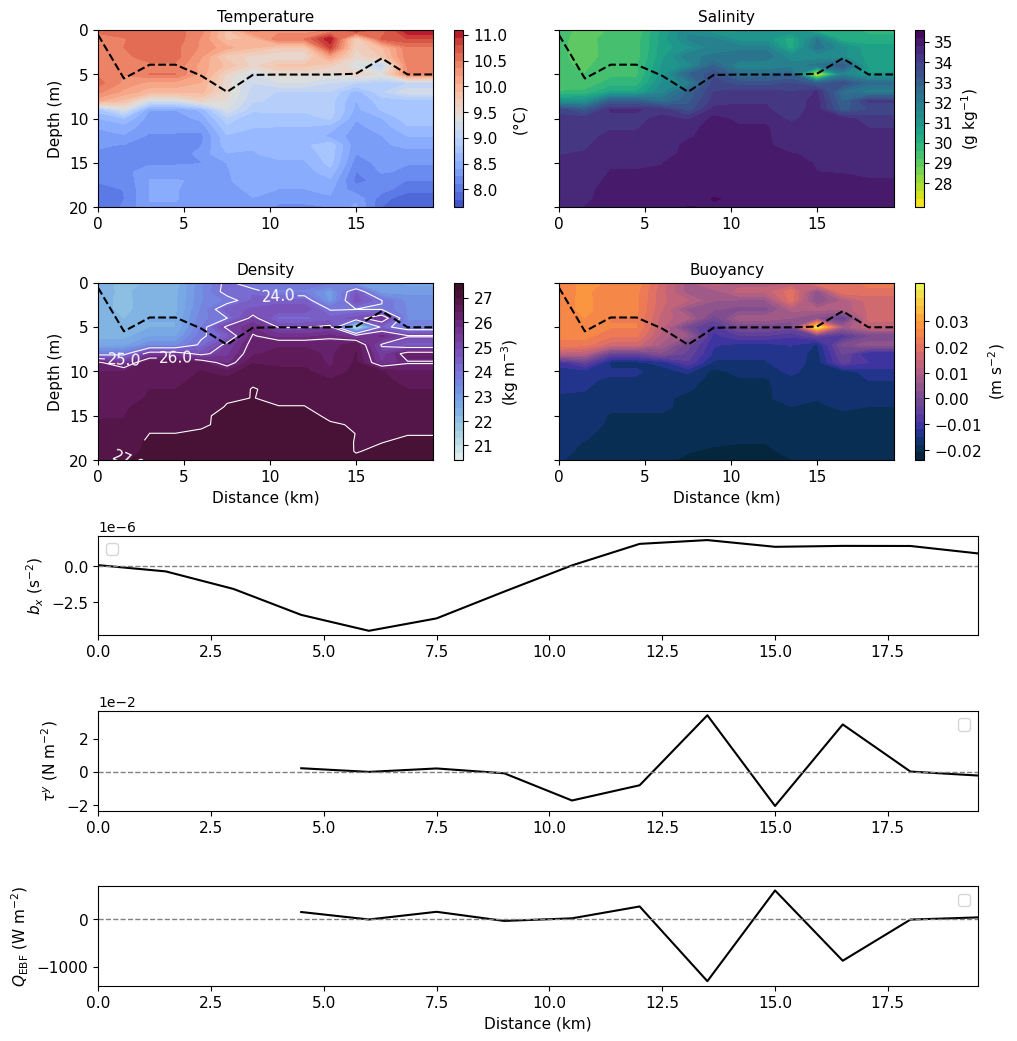

In [218]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator


# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=5, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)
if interp_indices.size > 0:
    mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])
else:
    mld = np.full_like(dist_grid, np.nan, dtype=float)

# Plot vertical profiles and distance series
fig = plt.figure(figsize=(10, 13))
gs = gridspec.GridSpec(6, 2, figure=fig, height_ratios=[1.6, 1.6, 0.9, 0.9, 0.9, 0.9], hspace=0.6, wspace=0.1, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])
ax_grad = fig.add_subplot(gs[2, :])
ax_tao = fig.add_subplot(gs[3, :])
ax_flux = fig.add_subplot(gs[4, :])

common_fontsize = 11

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=common_fontsize)
#ax_temp.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_temp.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_temp.tick_params(axis='both', labelsize=common_fontsize)
ax_temp.set_ylim(20, 0)
ax_temp.set_xlim(0, 19.5)
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=common_fontsize)
cb1.set_ticks(np.arange(8, 11.5, 0.5))
cb1.ax.tick_params(labelsize=common_fontsize)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=common_fontsize)
#ax_sali.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.tick_params(axis='both', labelsize=common_fontsize)
ax_sali.tick_params(axis='y', labelleft=False)
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=common_fontsize)
cb2.set_ticks(np.arange(28, 36, 1))
cb2.ax.tick_params(labelsize=common_fontsize)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=common_fontsize, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=common_fontsize)
ax_dens.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_dens.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_dens.tick_params(axis='both', labelsize=common_fontsize)
ax_dens.set_xlim(0, 19.5)
ax_dens.set_ylim(20, 0)
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[21, 22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=common_fontsize)
cb3.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb3.ax.tick_params(labelsize=common_fontsize)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy)
cb4.set_label(r'(m s$^{-2}$)', fontsize=common_fontsize)
cb4.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb4.ax.tick_params(labelsize=common_fontsize)
cb4.set_ticks(np.arange(-0.02, 0.04, 0.01))
ax_buoy.set_title('Buoyancy', fontsize=common_fontsize)
ax_buoy.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_buoy.set_ylabel('Depth (m)', fontsize=common_fontsize)
#ax_buoy.tick_params(axis='both', labelsize=common_fontsize)

ax_buoy.tick_params(axis='both', labelsize=common_fontsize)
ax_buoy.tick_params(axis='y', labelleft=False)

ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_ylim(20, 0)

# Overlay MLD on vertical plots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

# Horizontal plots with their own axes
ax_grad.plot(dist_grid_clean / 1000, dbdx_clean, color='black')
ax_grad.set_ylabel(r'$b_x$ (s$^{-2}$)', fontsize=common_fontsize)
#ax_grad.set_title('Buoyancy Gradient', fontsize=common_fontsize)
#ax_grad.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_grad.legend(fontsize=common_fontsize)
ax_grad.set_xlim(0, 19.5)
#ax_grad.set_ylim(-0.0002,0.00002)
ax_grad.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_grad.tick_params(axis='both', labelsize=common_fontsize)

ax_tao.plot(dist_grid_clean / 1000, df_ctd['tau_along'], color='black')
ax_tao.set_ylabel(r'$\tau^y$ (N m$^{-2}$)', fontsize=common_fontsize)
#ax_tao.set_title('Wind Stress at 3 m', fontsize=common_fontsize)
ax_tao.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_tao.legend(fontsize=common_fontsize)
ax_tao.set_xlim(0, 19.5)
ax_tao.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_tao.tick_params(axis='both', labelsize=common_fontsize)

ax_flux.plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], color='black')
ax_flux.set_ylabel('$Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=common_fontsize)
ax_flux.set_xlabel('Distance (km)', fontsize=common_fontsize)
#ax_flux.set_title('Ekman Buoyancy Flux', fontsize=common_fontsize)
#ax_flux.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_flux.legend(fontsize=common_fontsize)
ax_flux.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_flux.set_xlim(0, 19.5)
ax_flux.tick_params(axis='both', labelsize=common_fontsize)

plt.tight_layout()
plt.show()

# Now shift x-axis tick labels by +35 km for all columns
for ax_col in axs[-1]:  # Bottom row of plots
    ax_col.figure.canvas.draw()  # Ensure ticks are initialized
    ticks = ax_col.get_xticks()
    tick_labels = [f"{tick + 35:.0f}" for tick in ticks]
    ax_col.set_xticks(ticks)  # Re-set original ticks
    ax_col.set_xticklabels(tick_labels)


In [213]:
tau_along_ctd = df_ctd['tau_along'].values

# NaN-safe stats
print("df_ctd['tau_along'] summary:")
print("Mean:", np.nanmean(tau_along_ctd))
print("Max: ", np.nanmax(tau_along_ctd))
print("Min: ", np.nanmin(tau_along_ctd))

# Print first and last 20 values
print("\nFirst 20 values:")
print(tau_along_ctd[:20])

print("\nLast 20 values:")
print(tau_along_ctd[-20:])
print(tau_along_ctd.shape)


df_ctd['tau_along'] summary:
Mean: 0.0014040243561280993
Max:  0.03397193322147546
Min:  -0.02050014862341819

First 20 values:
[            nan             nan             nan  2.16327861e-03
 -2.92509850e-05  2.03527986e-03 -8.73872794e-04 -1.72034242e-02
 -8.05309029e-03  3.39719332e-02 -2.05001486e-02  2.84670678e-02
  1.64961519e-04 -2.22055170e-03 -1.07389012e-03]

Last 20 values:
[            nan             nan             nan  2.16327861e-03
 -2.92509850e-05  2.03527986e-03 -8.73872794e-04 -1.72034242e-02
 -8.05309029e-03  3.39719332e-02 -2.05001486e-02  2.84670678e-02
  1.64961519e-04 -2.22055170e-03 -1.07389012e-03]
(15,)


In [ ]:
tau_along_reg values for Day 2 (plotted):
Mean: -0.01714119244827359
Max:  0.03994092140617309
Min:  -0.10776313761807448

First 20 values:
[        nan         nan         nan         nan         nan         nan
 -0.09775894 -0.0994263  -0.10109367 -0.10276104 -0.1044284  -0.10609577
 -0.10776314 -0.10565713 -0.10347452 -0.10129192 -0.09910932 -0.09692671
 -0.09474411 -0.0925615 ]

Last 20 values:
[0.03994092 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092
 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092
 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092 0.03994092
 0.03994092 0.03994092]
(333,)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\2171583294.py:119: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


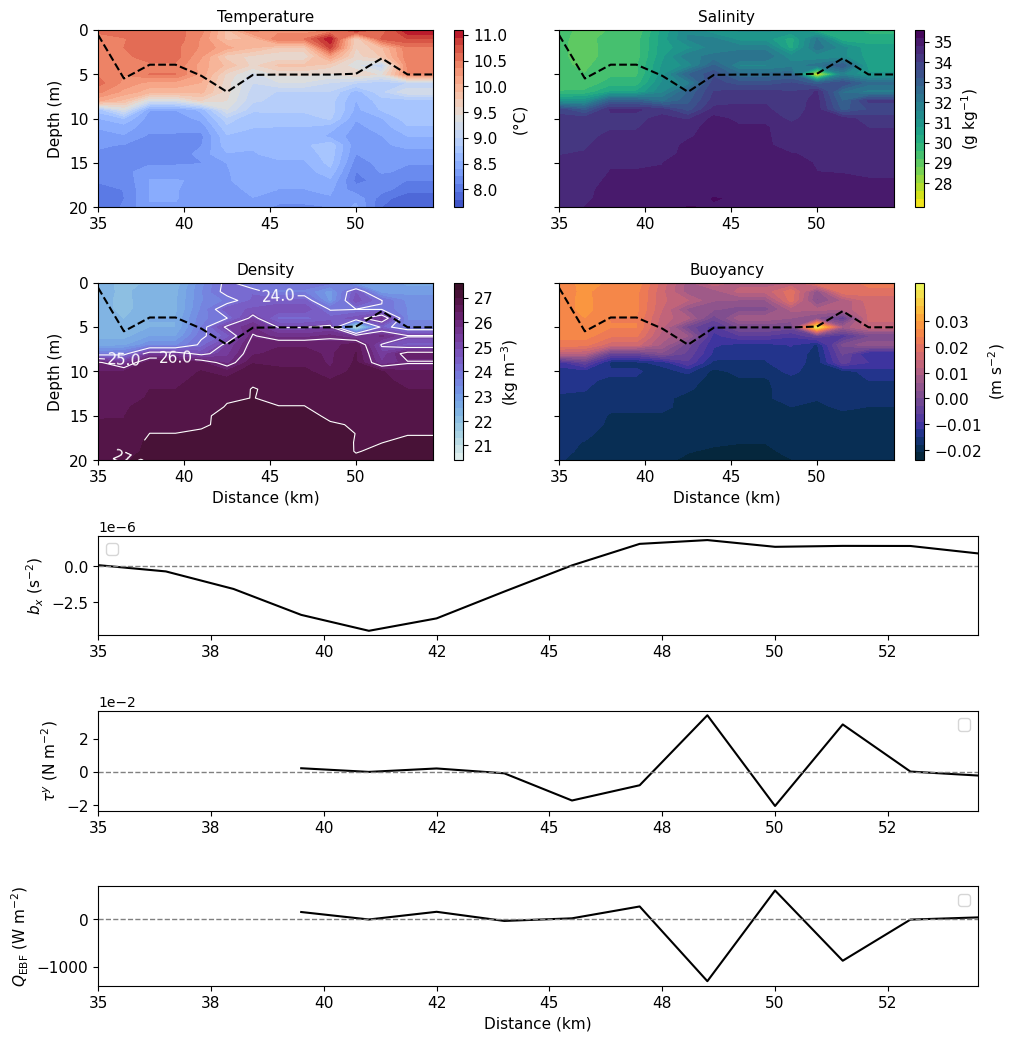

In [221]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)

# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=5, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)

if interp_indices.size > 0:
    mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])
else:
    mld = np.full_like(dist_grid, np.nan, dtype=float)

# Plot vertical profiles and distance series
fig = plt.figure(figsize=(10, 13))
gs = gridspec.GridSpec(6, 2, figure=fig, height_ratios=[1.6, 1.6, 0.9, 0.9, 0.9, 0.9], hspace=0.6, wspace=0.1, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])
ax_grad = fig.add_subplot(gs[2, :])
ax_tao = fig.add_subplot(gs[3, :])
ax_flux = fig.add_subplot(gs[4, :])

common_fontsize = 11

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=common_fontsize)
ax_temp.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_temp.tick_params(axis='both', labelsize=common_fontsize)
ax_temp.set_ylim(20, 0)
ax_temp.set_xlim(0, 19.5)
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=common_fontsize)
cb1.set_ticks(np.arange(8, 11.5, 0.5))
cb1.ax.tick_params(labelsize=common_fontsize)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis_r')
ax_sali.set_title('Salinity', fontsize=common_fontsize)
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.tick_params(axis='both', labelsize=common_fontsize)
ax_sali.tick_params(axis='y', labelleft=False)
cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=common_fontsize)
cb2.set_ticks(np.arange(28, 36, 1))
cb2.ax.tick_params(labelsize=common_fontsize)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=common_fontsize, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=common_fontsize)
ax_dens.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_dens.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_dens.tick_params(axis='both', labelsize=common_fontsize)
ax_dens.set_xlim(0, 19.5)
ax_dens.set_ylim(20, 0)
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[21, 22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=common_fontsize)
cb3.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb3.ax.tick_params(labelsize=common_fontsize)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy)
cb4.set_label(r'(m s$^{-2}$)', fontsize=common_fontsize)
cb4.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb4.ax.tick_params(labelsize=common_fontsize)
cb4.set_ticks(np.arange(-0.02, 0.04, 0.01))
ax_buoy.set_title('Buoyancy', fontsize=common_fontsize)
ax_buoy.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_buoy.tick_params(axis='both', labelsize=common_fontsize)
ax_buoy.tick_params(axis='y', labelleft=False)
ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_ylim(20, 0)

# Overlay MLD on vertical plots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

# Horizontal plots with their own axes
ax_grad.plot(dist_grid_clean / 1000, dbdx_clean, color='black')
ax_grad.set_ylabel(r'$b_x$ (s$^{-2}$)', fontsize=common_fontsize)
ax_grad.legend(fontsize=common_fontsize)
ax_grad.set_xlim(0, 19.5)
ax_grad.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_grad.tick_params(axis='both', labelsize=common_fontsize)

ax_tao.plot(dist_grid_clean / 1000, df_ctd['tau_along'], color='black')
ax_tao.set_ylabel(r'$\tau^y$ (N m$^{-2}$)', fontsize=common_fontsize)
ax_tao.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_tao.legend(fontsize=common_fontsize)
ax_tao.set_xlim(0, 19.5)
ax_tao.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_tao.tick_params(axis='both', labelsize=common_fontsize)

ax_flux.plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], color='black')
ax_flux.set_ylabel('$Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=common_fontsize)
ax_flux.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_flux.legend(fontsize=common_fontsize)
ax_flux.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_flux.set_xlim(0, 19.5)
ax_flux.tick_params(axis='both', labelsize=common_fontsize)

plt.tight_layout()
plt.draw()

from matplotlib.ticker import FuncFormatter

def offset_ticks(x, pos):
    return f"{x + 35:.0f}"

formatter = FuncFormatter(offset_ticks)

for ax in [ax_temp, ax_sali, ax_dens, ax_buoy, ax_grad, ax_tao, ax_flux]:
    ax.xaxis.set_major_formatter(formatter)


plt.show()


# Using db instead of depth to compute the depth

In [260]:
# --- Load and process CTD files ---

from pathlib import Path
import numpy as np
import pandas as pd
import datetime as dt
import pytz
import gsw
from pyproj import Geod
from scipy.interpolate import interp1d, UnivariateSpline, griddata
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean as cmo
from matplotlib.ticker import FuncFormatter

folder_path = Path(r'C:\Users\Sussi\OneDrive - University of Gothenburg\Master\observing\project\PROJECT-1\Data')

def load_cnv(filepath):
    def dms_to_decimal(degrees, minutes, direction):
        decimal = float(degrees) + float(minutes) / 60
        if direction.upper() in ['S', 'W']:
            decimal *= -1
        return decimal

    with open(filepath, 'r', encoding='latin1') as f:
        lines = f.readlines()

    data_start = next(i for i, l in enumerate(lines) if '*END*' in l) + 1
    df = pd.read_csv(filepath, skiprows=data_start, delim_whitespace=True, encoding='latin1', header=None)
    df.columns = [f'col_{i}' for i in range(df.shape[1])]

    lat = lon = None
    time_local = None
    for line in lines:
        if 'latitude' in line.lower():
            parts = line.split()
            try:
                lat = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'longitude' in line.lower():
            parts = line.split()
            try:
                lon = dms_to_decimal(parts[-3], parts[-2], parts[-1])
            except:
                continue
        if 'nmea utc' in line.lower():
            print(f"Found NMEA time line: {line.strip()}")
            try:
                time_local = dt.datetime.strptime(line.split('=')[-1].strip(), '%b %d %Y %H:%M:%S')
                time_local = pytz.timezone('Europe/Stockholm').localize(time_local)
            except Exception as e:
                print(f"Failed to parse time from line: {line.strip()} → {e}")
                continue

    time_utc = time_local.astimezone(pytz.utc).replace(tzinfo=None) if time_local is not None else None
    return df, lat, lon, time_utc

# Update process_ctd_casts to loosen depth mask

def process_ctd_casts(folder_path):
    filenames = [
        'CTD_05.cnv', 'CTD_06.cnv', 'CTD_07.cnv', 'CTD_08.cnv',
        'CTD_09.cnv', 'CTD_10.cnv', 'CTD_11.cnv', 'CTD_12.cnv',
        'CTD_13.cnv', 'CTD_14.cnv', 'CTD_15.cnv', 'CTD_16.cnv'
    ]
    cast_data = []
    for file in filenames:
        full_path = Path(folder_path) / file
        df, lat, lon, time_utc = load_cnv(full_path)

        SP = df['col_9'].to_numpy()
        T = df['col_2'].to_numpy()
        p = df['col_1'].to_numpy()

        mask = (p >= -0.5) & (p <= 25)
        SP = SP[mask]
        T = T[mask]
        p = p[mask]

        SA = gsw.SA_from_SP(SP, p, lon, lat)
        CT = gsw.CT_from_t(SA, T, p)
        rho = gsw.sigma0(SA, CT) + 1000
        b = 9.81 * (1 - rho / 1025)
        z = -gsw.z_from_p(p, lat)

        valid_z_mask = z >= -1  # Loosened from z >= 0
        SA = SA[valid_z_mask]
        CT = CT[valid_z_mask]
        rho = rho[valid_z_mask]
        b = b[valid_z_mask]
        p = p[valid_z_mask]
        z = z[valid_z_mask]

        cast_data.append({
            'time': time_utc + dt.timedelta(hours=2) if time_utc is not None else None,
            'lat': lat,
            'lon': lon,
            'SA': SA,
            'CT': CT,
            'p': p,
            'z': z,
            'rho': rho,
            'b': b
        })
    return cast_data

ctd_casts = process_ctd_casts(folder_path)

# --- Calculate distances between CTD stations ---
geod = Geod(ellps="WGS84")
distances = [0]
for c1, c2 in zip(ctd_casts[:-1], ctd_casts[1:]):
    _, _, dist = geod.inv(c1['lon'], c1['lat'], c2['lon'], c2['lat'])
    distances.append(distances[-1] + dist)

dx = 1500
depth_grid = np.arange(0, 41, 1)
dist_grid = np.arange(0, distances[-1] + dx, dx)

# --- Interpolate buoyancy using z directly ---
def interpolate_b_transect(cast_data, distances, dist_grid, depth_grid):
    b_points, b_values = [], []

    for i, cast in enumerate(cast_data):
        z = cast['z']
        b = cast['b']
        mask = (z >= 0) & (z <= np.max(depth_grid))
        z = z[mask]
        b = b[mask]
        for zi, bi in zip(z, b):
            b_points.append([distances[i], zi])
            b_values.append(bi)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    b_grid = griddata(b_points, b_values, (grid_x, grid_z), method='nearest')
    return b_grid

b_grid = interpolate_b_transect(ctd_casts, distances, dist_grid, depth_grid)
b_3m = b_grid[np.argmin(np.abs(depth_grid - 3)), :]
dbdx = np.gradient(b_3m, dx)

# --- Add further computations and use consistent depth ---
df_env = pd.read_csv(folder_path / 'sk_weather.csv')
df_env['datetime'] = pd.to_datetime(df_env['ts'])
df_env['wind_dir_rad'] = np.deg2rad((df_env['winddir'] + 180) % 360)

valid_time_mask = [cast['time'] is not None for cast in ctd_casts]
for i, valid in enumerate(valid_time_mask):
    if not valid:
        print(f"Warning: CTD cast at index {i} has no valid timestamp.")
valid_ctd_times = [cast['time'] for i, cast in enumerate(ctd_casts) if valid_time_mask[i]]
valid_distances = [dist for i, dist in enumerate(distances) if valid_time_mask[i]]

time_interp = np.interp(dist_grid, valid_distances, [t.timestamp() for t in valid_ctd_times])
times_dt = [dt.datetime.utcfromtimestamp(t) for t in time_interp]

df_env['ts_numeric'] = df_env['datetime'].astype(np.int64) / 1e9
wind_speed = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['windspeed'])
wind_dir_rad = np.interp([t.timestamp() for t in times_dt], df_env['ts_numeric'], df_env['wind_dir_rad'])

# Load and interpolate current direction from ADCP
adcp_file = folder_path / 'adcp0507_postpro20may.txt'
adcp = pd.read_csv(adcp_file, sep="\t", skiprows=12, engine="python").iloc[3:-3].reset_index(drop=True)
adcp = adcp.map(lambda x: str(x).replace(",", "."))

def parse_int(x):
    try:
        return int(float(x))
    except:
        return 0

ymdhms = adcp[['YR', 'MO', 'DA', 'HH', 'MM', 'SS']].apply(lambda col: col.map(parse_int)).to_numpy()
adcp_time = [dt.datetime(2000 + y, m, d, hh, mm, ss) for y, m, d, hh, mm, ss in ymdhms]
adcp_time = [pytz.timezone('Europe/Stockholm').localize(t).astimezone(pytz.utc).replace(tzinfo=None) for t in adcp_time]

u = adcp[[f"Eas{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
v = adcp[[f"Nor{'.'+str(i) if i else ''}" for i in range(10)]].astype(float).to_numpy().mean(axis=1) / 1000
theta_current = np.arctan2(v, u)

theta_time = np.array([t.timestamp() for t in adcp_time])
theta_values = theta_current
current_dir_rad = np.interp(
    [t.timestamp() for t in times_dt],
    theta_time,
    theta_values
)

# Filter out invalid values
valid_mask = ~np.isnan(b_3m)
valid_mask &= ~np.isnan(dbdx)

b_smooth_clean = b_3m[valid_mask]
dbdx_clean = dbdx[valid_mask]
dist_grid_clean = dist_grid[valid_mask]
wind_speed = wind_speed[valid_mask]
wind_dir_rad = wind_dir_rad[valid_mask]
current_dir_rad = current_dir_rad[valid_mask]

# Interpolate SA and CT for alpha computation

def interpolate_SA_CT_transect(cast_data, distances, dist_grid, depth_grid):
    sa_points, sa_values = [], []
    ct_points, ct_values = [], []

    for i, cast in enumerate(cast_data):
        z = cast['z']
        SA = cast['SA']
        CT = cast['CT']
        # Loosen the mask to include slightly negative z values close to surface
        mask = (z >= -1) & (z <= np.max(depth_grid))
        z = z[mask]
        SA = SA[mask]
        CT = CT[mask]
        for zi, sai, cti in zip(z, SA, CT):
            sa_points.append([distances[i], zi])
            sa_values.append(sai)
            ct_points.append([distances[i], zi])
            ct_values.append(cti)

    grid_x, grid_z = np.meshgrid(dist_grid, depth_grid)
    SA_grid = griddata(sa_points, sa_values, (grid_x, grid_z), method='linear')
    CT_grid = griddata(ct_points, ct_values, (grid_x, grid_z), method='linear')
    return SA_grid, CT_grid

SA_grid, CT_grid = interpolate_SA_CT_transect(ctd_casts, distances, dist_grid, depth_grid)
SA_3m = SA_grid[np.argmin(np.abs(depth_grid - 3)), :]
CT_3m = CT_grid[np.argmin(np.abs(depth_grid - 3)), :]

SA_i_clean = SA_3m[valid_mask]
CT_i_clean = CT_3m[valid_mask]

def compute_Q_EBF_ctd(dist_grid, SA_i, CT_i, b_smooth, dbdx, wind_speed, wind_dir_rad, current_dir_rad):
    g = 9.81
    Cp = 4000
    rho_air = 1.2
    Cd = 1.5e-3
    f = 2 * 7.2921e-5 * np.sin(np.deg2rad(57))
    tau = Cd * rho_air * wind_speed ** 2
    delta_theta = wind_dir_rad - current_dir_rad
    tau_along = tau * np.cos(delta_theta)
    alpha = gsw.alpha(SA_i, CT_i, 0)
    Q_EBF = -(dbdx * tau_along) * (Cp / (alpha * g * f))

    return pd.DataFrame({
        'distance_m': dist_grid,
        'Q_EBF': Q_EBF,
        'b_3m': b_smooth,
        'dbdx': dbdx,
        'tau_along': tau_along
    })

df_ctd = compute_Q_EBF_ctd(
    dist_grid_clean, SA_i_clean, CT_i_clean, b_smooth_clean, dbdx_clean,
    wind_speed, wind_dir_rad, current_dir_rad
)


Found NMEA time line: * NMEA UTC (Time) = May 07 2025 08:44:53
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:15:41
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 09:38:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:06:26
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 10:44:48
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:11:29
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:30:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 11:52:13
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:13:01
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:38:22
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 12:57:52
Found NMEA time line: * NMEA UTC (Time) = May 07 2025 13:17:45


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
C:\Users\Sussi\AppData\Local\Temp\ipykernel_18056\3966333839.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


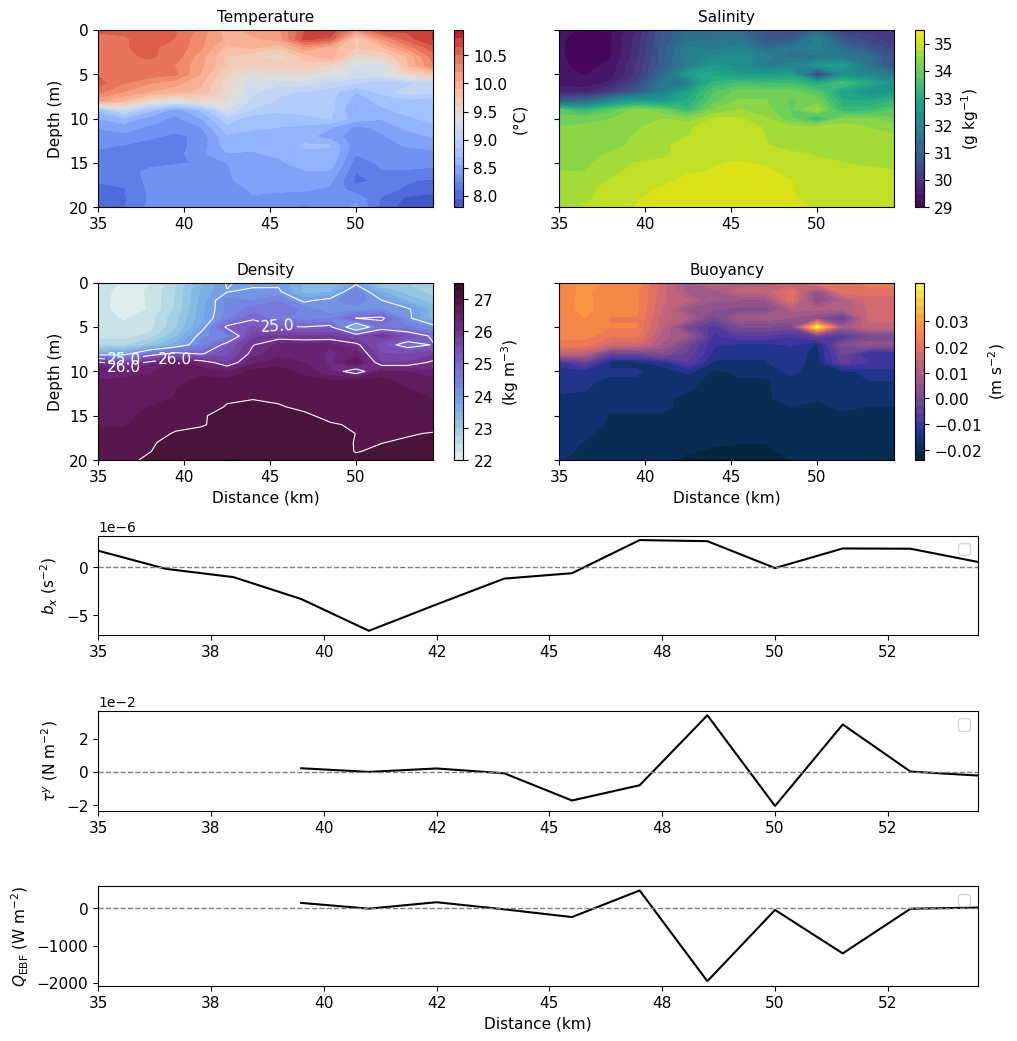

In [261]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import MaxNLocator, FormatStrFormatter


# --- Compute and Plot MLD and Hydrography ---

# Compute sigma0 (density anomaly)
sigma0_grid = gsw.sigma0(SA_grid, CT_grid)



# Compute MLD using spline-based method
mld_raw = compute_mld_interpolated_spline(sigma0_grid, depth_grid, ref_depth=0, delta_sigma=0.03)
mld_mask = ~np.isnan(mld_raw)
interp_indices = np.flatnonzero(mld_mask)

if interp_indices.size > 0:
    mld = np.interp(np.arange(len(dist_grid)), interp_indices, mld_raw[mld_mask])
else:
    mld = np.full_like(dist_grid, np.nan, dtype=float)

# Plot vertical profiles and distance series
fig = plt.figure(figsize=(10, 13))
gs = gridspec.GridSpec(6, 2, figure=fig, height_ratios=[1.6, 1.6, 0.9, 0.9, 0.9, 0.9], hspace=0.6, wspace=0.1, left=0.07, right=0.95, top=0.95, bottom=0.08)

ax_temp = fig.add_subplot(gs[0, 0])
ax_sali = fig.add_subplot(gs[0, 1])
ax_dens = fig.add_subplot(gs[1, 0])
ax_buoy = fig.add_subplot(gs[1, 1])
ax_grad = fig.add_subplot(gs[2, :])
ax_tao = fig.add_subplot(gs[3, :])
ax_flux = fig.add_subplot(gs[4, :])

common_fontsize = 11

cs1 = ax_temp.contourf(dist_grid / 1000, depth_grid, CT_grid, levels=25, cmap='coolwarm')
ax_temp.set_title('Temperature', fontsize=common_fontsize)
ax_temp.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_temp.tick_params(axis='both', labelsize=common_fontsize)
ax_temp.set_ylim(20, 0)
ax_temp.set_xlim(0, 19.5)
cb1 = plt.colorbar(cs1, ax=ax_temp)
cb1.set_label('(°C)', fontsize=common_fontsize)
cb1.set_ticks(np.arange(8, 11, 0.5))
cb1.ax.tick_params(labelsize=common_fontsize)

cs2 = ax_sali.contourf(dist_grid / 1000, depth_grid, SA_grid, levels=25, cmap='viridis')
ax_sali.set_title('Salinity', fontsize=common_fontsize)
ax_sali.set_ylim(20, 0)
ax_sali.set_xlim(0, 19.5)
ax_sali.tick_params(axis='both', labelsize=common_fontsize)
ax_sali.tick_params(axis='y', labelleft=False)
#ax_sali.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)

cb2 = plt.colorbar(cs2, ax=ax_sali)
cb2.set_label(r'(g kg$^{-1}$)', fontsize=common_fontsize)
cb2.set_ticks(np.arange(29, 36, 1))
cb2.ax.tick_params(labelsize=common_fontsize)

cs3 = ax_dens.contourf(dist_grid / 1000, depth_grid, sigma0_grid, levels=25, cmap=cmo.cm.dense)
levels = [24, 25, 26, 27, 28]
valid_levels = [lvl for lvl in levels if np.nanmin(sigma0_grid) <= lvl <= np.nanmax(sigma0_grid)]
contours = ax_dens.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
manual_positions = [
    (dist_grid[len(dist_grid) // 2] / 1000, 3),
    (dist_grid[len(dist_grid) // 11] / 1000, 9),
    (dist_grid[len(dist_grid) // 5] / 1000, 11),
    (dist_grid[len(dist_grid) // 10] / 1000, 15),
]
ax_dens.clabel(contours, contours.levels, inline=True, fontsize=common_fontsize, fmt="%.1f", manual=manual_positions)
ax_dens.set_title('Density', fontsize=common_fontsize)
ax_dens.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_dens.set_ylabel('Depth (m)', fontsize=common_fontsize)
ax_dens.tick_params(axis='both', labelsize=common_fontsize)
ax_dens.set_xlim(0, 19.5)
ax_dens.set_ylim(20, 0)
cb3 = plt.colorbar(cs3, ax=ax_dens, ticks=[21, 22, 23, 24, 25, 26, 27])
cb3.set_label(r'(kg m$^{-3}$)', fontsize=common_fontsize)
cb3.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb3.ax.tick_params(labelsize=common_fontsize)

bf = ax_buoy.contourf(dist_grid / 1000, depth_grid, b_grid, levels=25, cmap=cmo.cm.thermal)
cb4 = plt.colorbar(bf, ax=ax_buoy)
cb4.set_label(r'(m s$^{-2}$)', fontsize=common_fontsize)
cb4.ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
cb4.ax.tick_params(labelsize=common_fontsize)
cb4.set_ticks(np.arange(-0.02, 0.04, 0.01))
ax_buoy.set_title('Buoyancy', fontsize=common_fontsize)
#ax_buoy.contour(dist_grid / 1000, depth_grid, sigma0_grid, colors='white', linewidths=0.8, levels=valid_levels)
ax_buoy.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_buoy.tick_params(axis='both', labelsize=common_fontsize)
ax_buoy.tick_params(axis='y', labelleft=False)
ax_buoy.set_xlim(0, 19.5)
ax_buoy.set_ylim(20, 0)

# Overlay MLD on vertical plots
for ax in [ax_temp, ax_sali, ax_dens, ax_buoy]:
    ax.plot(dist_grid / 1000, mld, 'k--', label='MLD')

# Horizontal plots with their own axes
ax_grad.plot(dist_grid_clean / 1000, dbdx_clean, color='black')
ax_grad.set_ylabel(r'$b_x$ (s$^{-2}$)', fontsize=common_fontsize)
ax_grad.legend(fontsize=common_fontsize)
ax_grad.set_xlim(0, 19.5)
ax_grad.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_grad.tick_params(axis='both', labelsize=common_fontsize)

ax_tao.plot(dist_grid_clean / 1000, df_ctd['tau_along'], color='black')
ax_tao.set_ylabel(r'$\tau^y$ (N m$^{-2}$)', fontsize=common_fontsize)
ax_tao.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax_tao.legend(fontsize=common_fontsize)
ax_tao.set_xlim(0, 19.5)
ax_tao.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_tao.tick_params(axis='both', labelsize=common_fontsize)

ax_flux.plot(dist_grid_clean / 1000, df_ctd['Q_EBF'], color='black')
ax_flux.set_ylabel('$Q_{\mathrm{EBF}}$ (W m$^{-2}$)', fontsize=common_fontsize)
ax_flux.set_xlabel('Distance (km)', fontsize=common_fontsize)
ax_flux.legend(fontsize=common_fontsize)
ax_flux.axhline(0, color='gray', linestyle='--', linewidth=1)
ax_flux.set_xlim(0, 19.5)
ax_flux.tick_params(axis='both', labelsize=common_fontsize)


plt.tight_layout()
plt.draw()

from matplotlib.ticker import FuncFormatter

def offset_ticks(x, pos):
    return f"{x + 35:.0f}"

formatter = FuncFormatter(offset_ticks)

for ax in [ax_temp, ax_sali, ax_dens, ax_buoy, ax_grad, ax_tao, ax_flux]:
    ax.xaxis.set_major_formatter(formatter)




plt.show()
